# 0.0 IMPORTS

In [1]:
import optuna
import warnings
import pickle
import pandas     as pd
import numpy      as np
import seaborn    as sns
import scikitplot as skplt
from xgboost               import XGBClassifier 
from lightgbm              import LGBMClassifier
from IPython.display       import Image
from optuna.samplers       import TPESampler
from sklearn.metrics       import accuracy_score, classification_report
from IPython.core.display  import HTML
from scipy      import stats           as ss
from matplotlib import pyplot          as plt
from sklearn    import ensemble        as en
from sklearn    import neighbors       as nh
from sklearn    import linear_model    as lm
from sklearn    import preprocessing   as pp
from sklearn    import model_selection as ms

C:\Users\PICHAU\anaconda3\envs\pa_hi\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 Helper functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt((chi2corr/n) / ( min( kcorr-1, rcorr-1 )))


def precision_at_k (data, k):
    #reset index
    data = data.reset_index(drop=True)

    #create ranking order
    data['ranking'] = data.index + 1

    #create precision at k
    data['precision_at_k'] = data['Response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']


def recall_at_k (data, k):
    #reset index
    data = data.reset_index(drop=True)

    #create ranking order
    data['ranking'] = data.index + 1

    #create recall at k
    data['recall_at_k'] = data['Response'].cumsum() / data['Response'].sum()
    
    return data.loc[k, 'recall_at_k']


def resultssp(data, yhat, yhat1, model_name, k):
    
    data['score'] = yhat[:, 1].tolist()
    data = data.sort_values('score', ascending=False)
    
    # precision_at_k
    precision_k = precision_at_k(data, k)
    # recall_at_k
    recall_k = recall_at_k(data, k)
    
    accuracy = accuracy_score(y_val, yhat1)
    
    return pd.DataFrame({'Precision @k': precision_k, 
                         'Recall @k': recall_k,
                         'Accuracy': accuracy}, index=[model_name])


def cg_curve(yhat, y_val):    
    cgc = pd.DataFrame()
    cgc['prediction'] = yhat[:,1].tolist()
    cgc['real'] = y_val.tolist()

    # ordering by prediction
    cgc = cgc.sort_values('prediction', ascending=False)

    # Percentage of intereset ( Propensity Score )
    cgc['real_cum'] = cgc['real'].cumsum() 
    cgc['real_cum_perc'] = 100*cgc['real_cum']/cgc['real'].sum()

    # Percentage of Base ( Clients )
    cgc['base'] = range(1, len(cgc) + 1)
    cgc['base_cum_perc'] = 100*cgc['base']/len(cgc)
    
    # Basline model
    cgc['baseline'] = cgc['base_cum_perc']
    
    return cgc


def cross_validation(model_name, model, x_train, y_train, k, verbose=False):
    precision_k_list = []
    recall_k_list = []
    
    kfs = ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
    
    for cv_train, cv_val in kfs.split(x_train, y_train):
        
        xtrain_val = x_train.iloc[cv_train]
        ytrain_val = y_train.iloc[cv_train]
        
        xval = x_train.iloc[cv_val]
        yval = y_train.iloc[cv_val]
        
        # model
        model.fit(xtrain_val, ytrain_val)

        # prediction
        yhat = model.predict_proba(xval)
        yhat1 = model.predict(xval)
        
        # training and validation dataset
        data = xval.copy()
        data['Response'] = yval.copy()

        #propensity score
        data['score'] = yhat[:, 1].tolist()

        data = data.sort_values('score', ascending = False)

        # performance
        precision_k = precision_at_k(data, k)
        precision_k_list.append(precision_k)
        
        recall_k = recall_at_k(data, k)
        recall_k_list.append(recall_k)
        
        acc = accuracy_score(yval, yhat1)
        
    return pd.DataFrame({'Precision @k CV': np.round(np.mean(precision_k_list), 3),
                         'Recall @k CV': np.round(np.mean(recall_k_list), 3),
                         'Accuracy': np.round(np.mean(acc), 3)},index=[model_name])

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()

In [3]:
warnings.filterwarnings('ignore')

In [133]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading dataset

In [4]:
path = "C:/Users/PICHAU/repos/pa_hi/pa_hi/"

In [5]:
df_raw = pd.read_csv(path + "data/raw/train.csv")

In [6]:
df_raw.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
7,8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1
8,9,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28,0
9,10,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80,0


# 1.0 Data Description

In [7]:
df1 = df_raw.copy()

## 1.1 Data info

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## 1.2 Check NA's

In [9]:
df1.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

## 1.3 Descriptive statisc

In [10]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.3.1 Numerical attributes

In [11]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenar
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,Age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,Driving_License,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,Region_Code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,Previously_Insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,Annual_Premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,Policy_Sales_Channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,Vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,Response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0 Feature Engineering

In [12]:
df2 = df1.copy()

In [13]:
df2['Vehicle_Age'].unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [14]:
df2['Vehicle_Age'] = df2['Vehicle_Age'].apply(lambda x: 'over_2_years'      if x== '> 2 Years' else
                                                        'between_1_2_years' if x== '1-2 Year'  else 
                                                        'below_1_year')

In [15]:
df2['Vehicle_Damage'].unique()

array(['Yes', 'No'], dtype=object)

In [16]:
df2['Vehicle_Damage'] = df2['Vehicle_Damage'].apply(lambda x: 1 if x== 'Yes' else 0)

# 3.0 Data Filtering

In [17]:
df3 = df2.copy()

# 4.0 EDA

In [18]:
df4 = df3.copy()

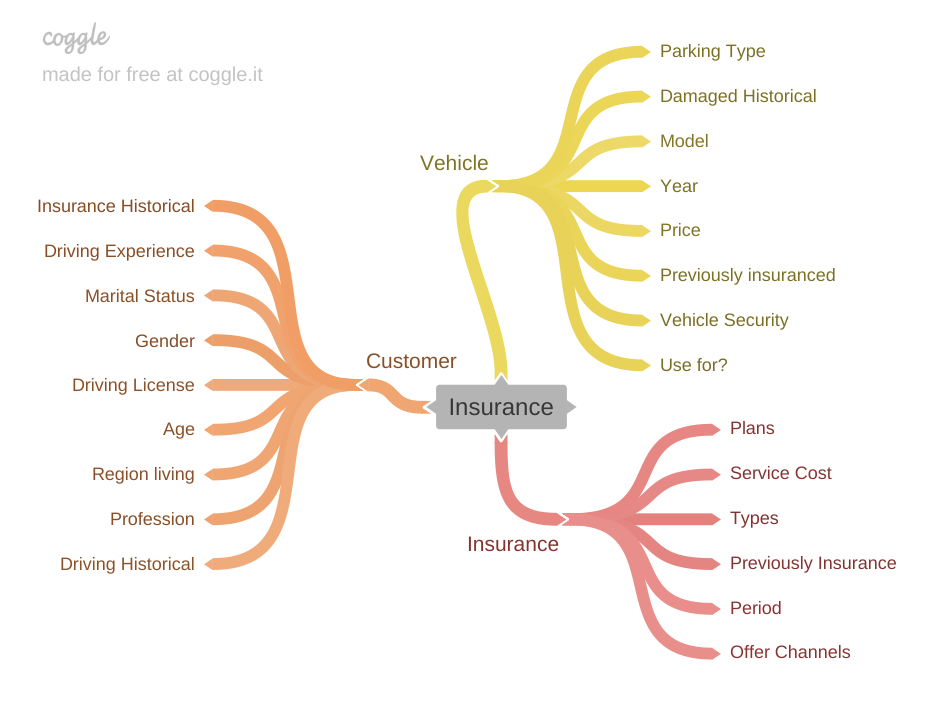

In [19]:
Image(path +'image/hypotheses.png')

## 4.1 Univariate analysis

In [20]:
df4.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

<AxesSubplot:xlabel='Response', ylabel='Age'>

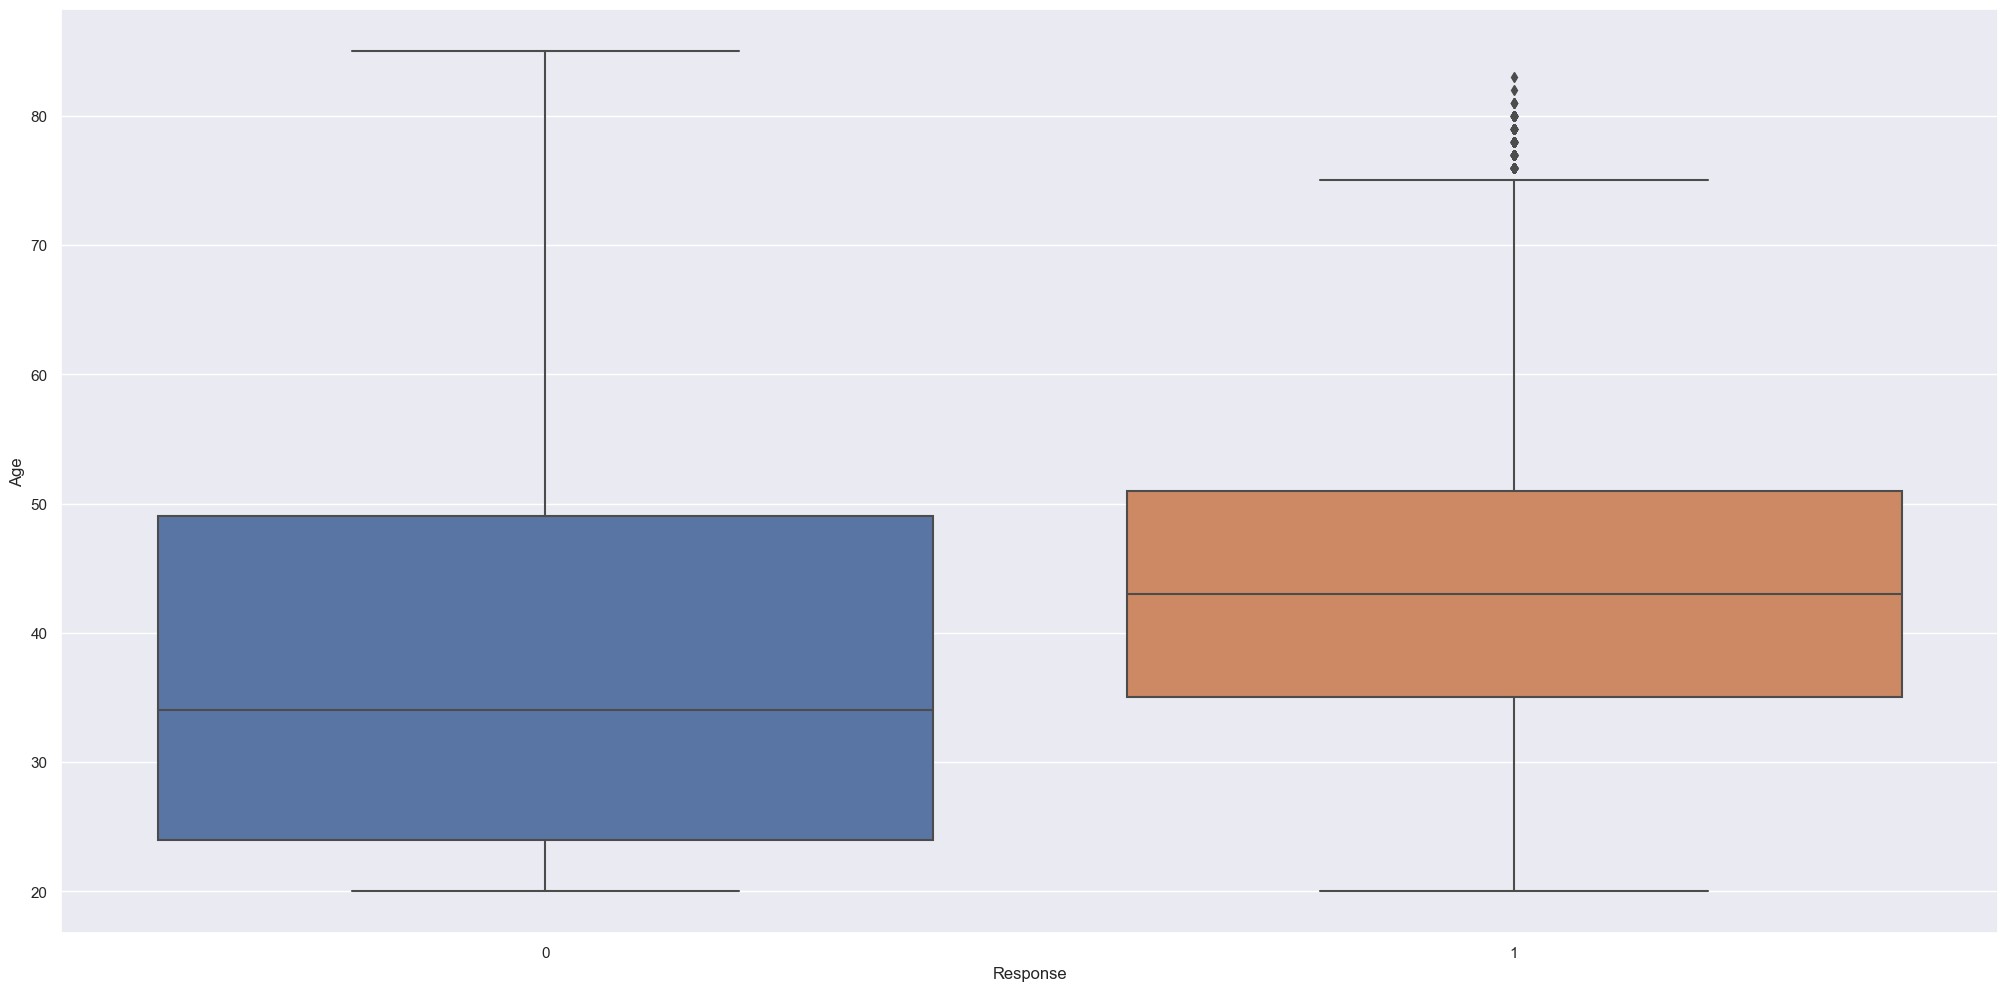

In [148]:
#Age
sns.boxplot(x='Response',y='Age',data=df4)

<AxesSubplot:xlabel='Age', ylabel='Count'>

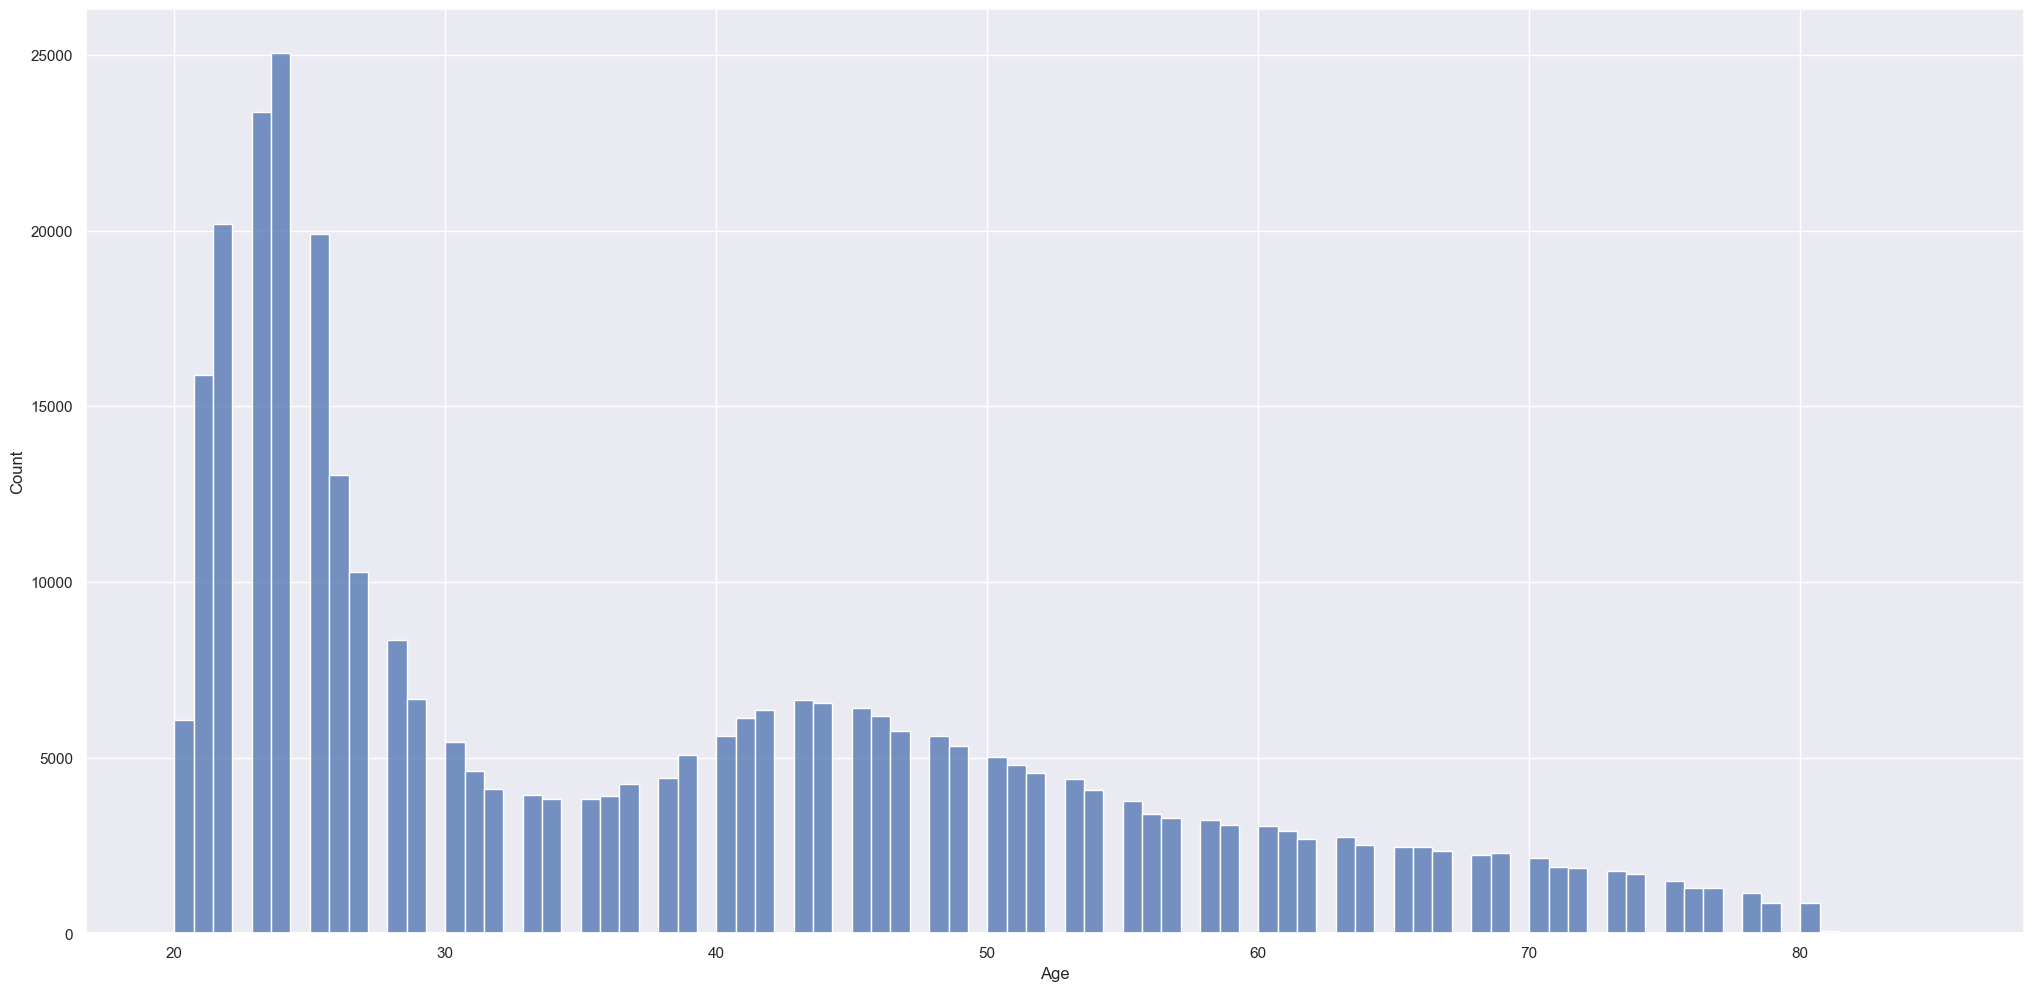

In [149]:
aux0 = df4.loc[df4['Response']==0, 'Age']
sns.histplot(aux0)

<AxesSubplot:xlabel='Age', ylabel='Count'>

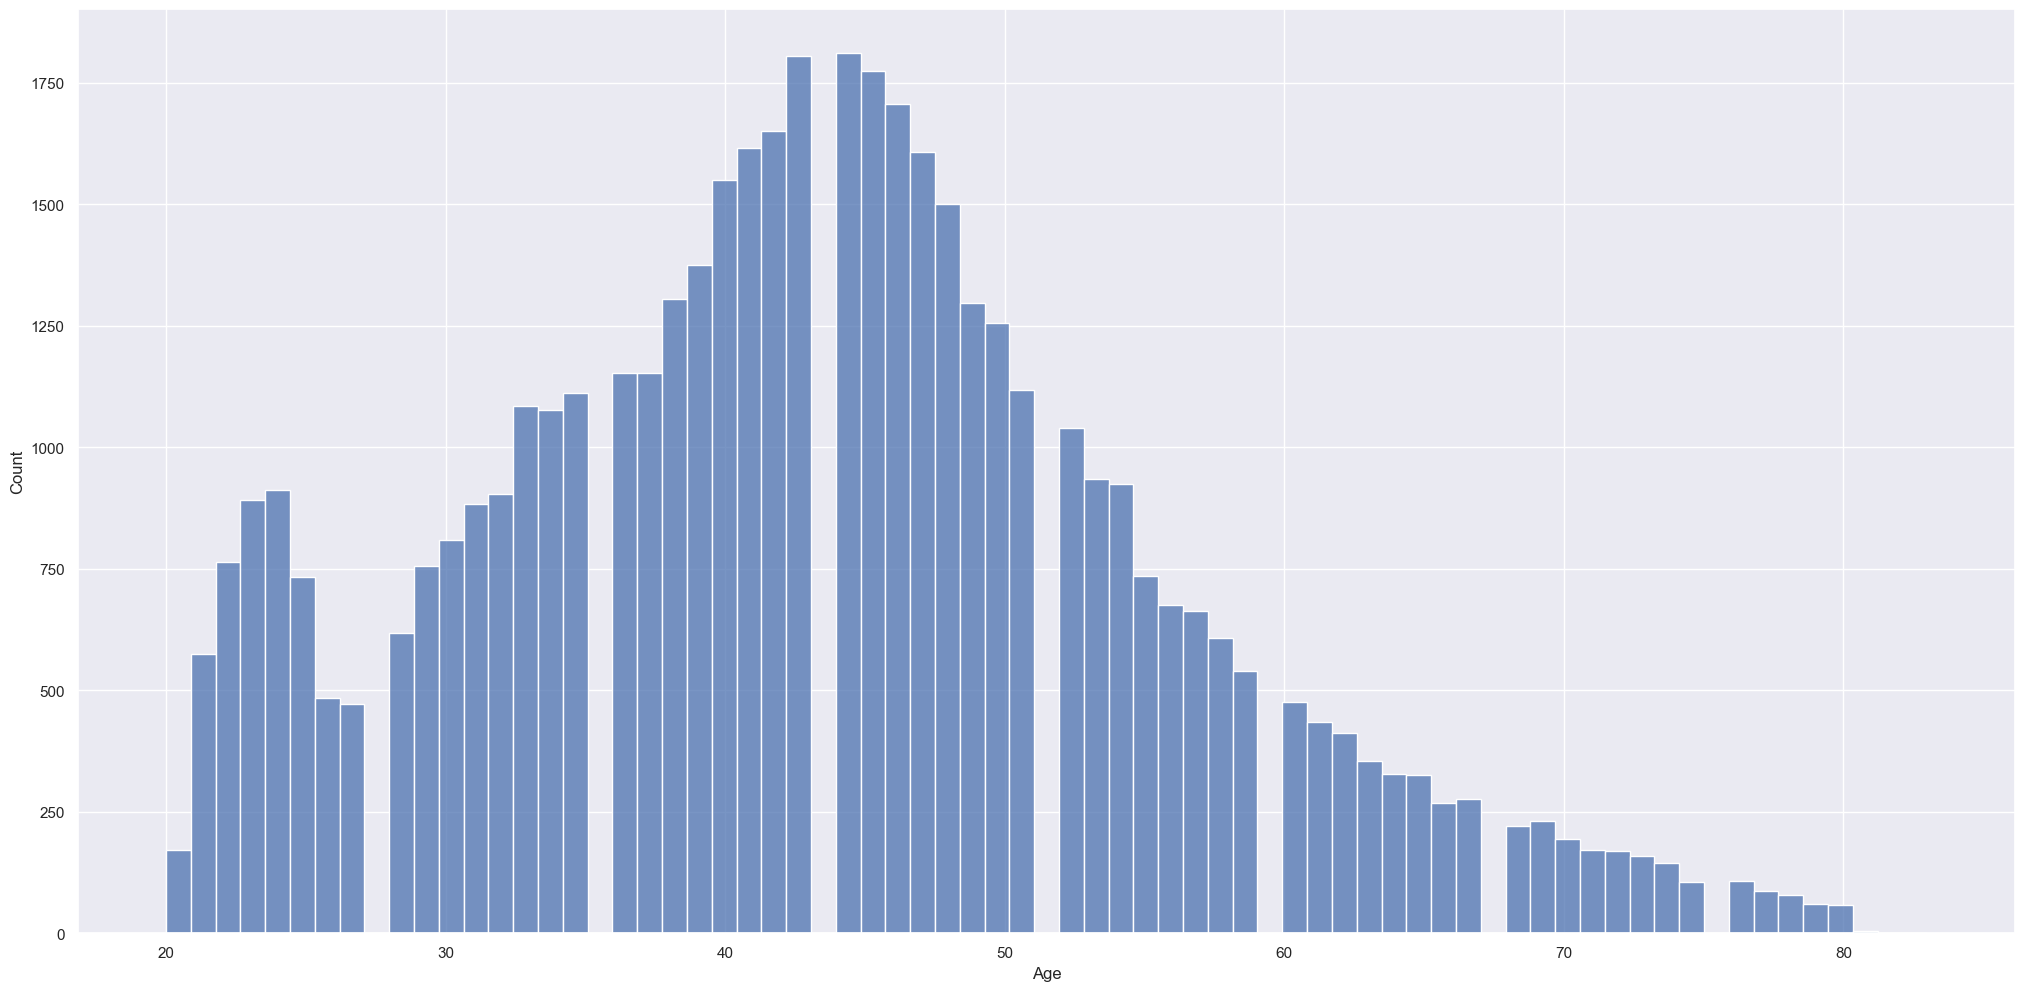

In [150]:
aux0 = df4.loc[df4['Response']==1, 'Age']
sns.histplot(aux0)

In [24]:
#Gender
df4[['Gender', 'Response']].value_counts().reset_index()

,Gender,Response,0
0,Male,0,177564
1,Female,0,156835
2,Male,1,28525
3,Female,1,18185


In [25]:
#Driving_License
aux = df4[['Driving_License','Response']].groupby('Response').sum().reset_index()
aux

,Response,Driving_License
0,0,333628
1,1,46669


<AxesSubplot:xlabel='Region_Code', ylabel='id'>

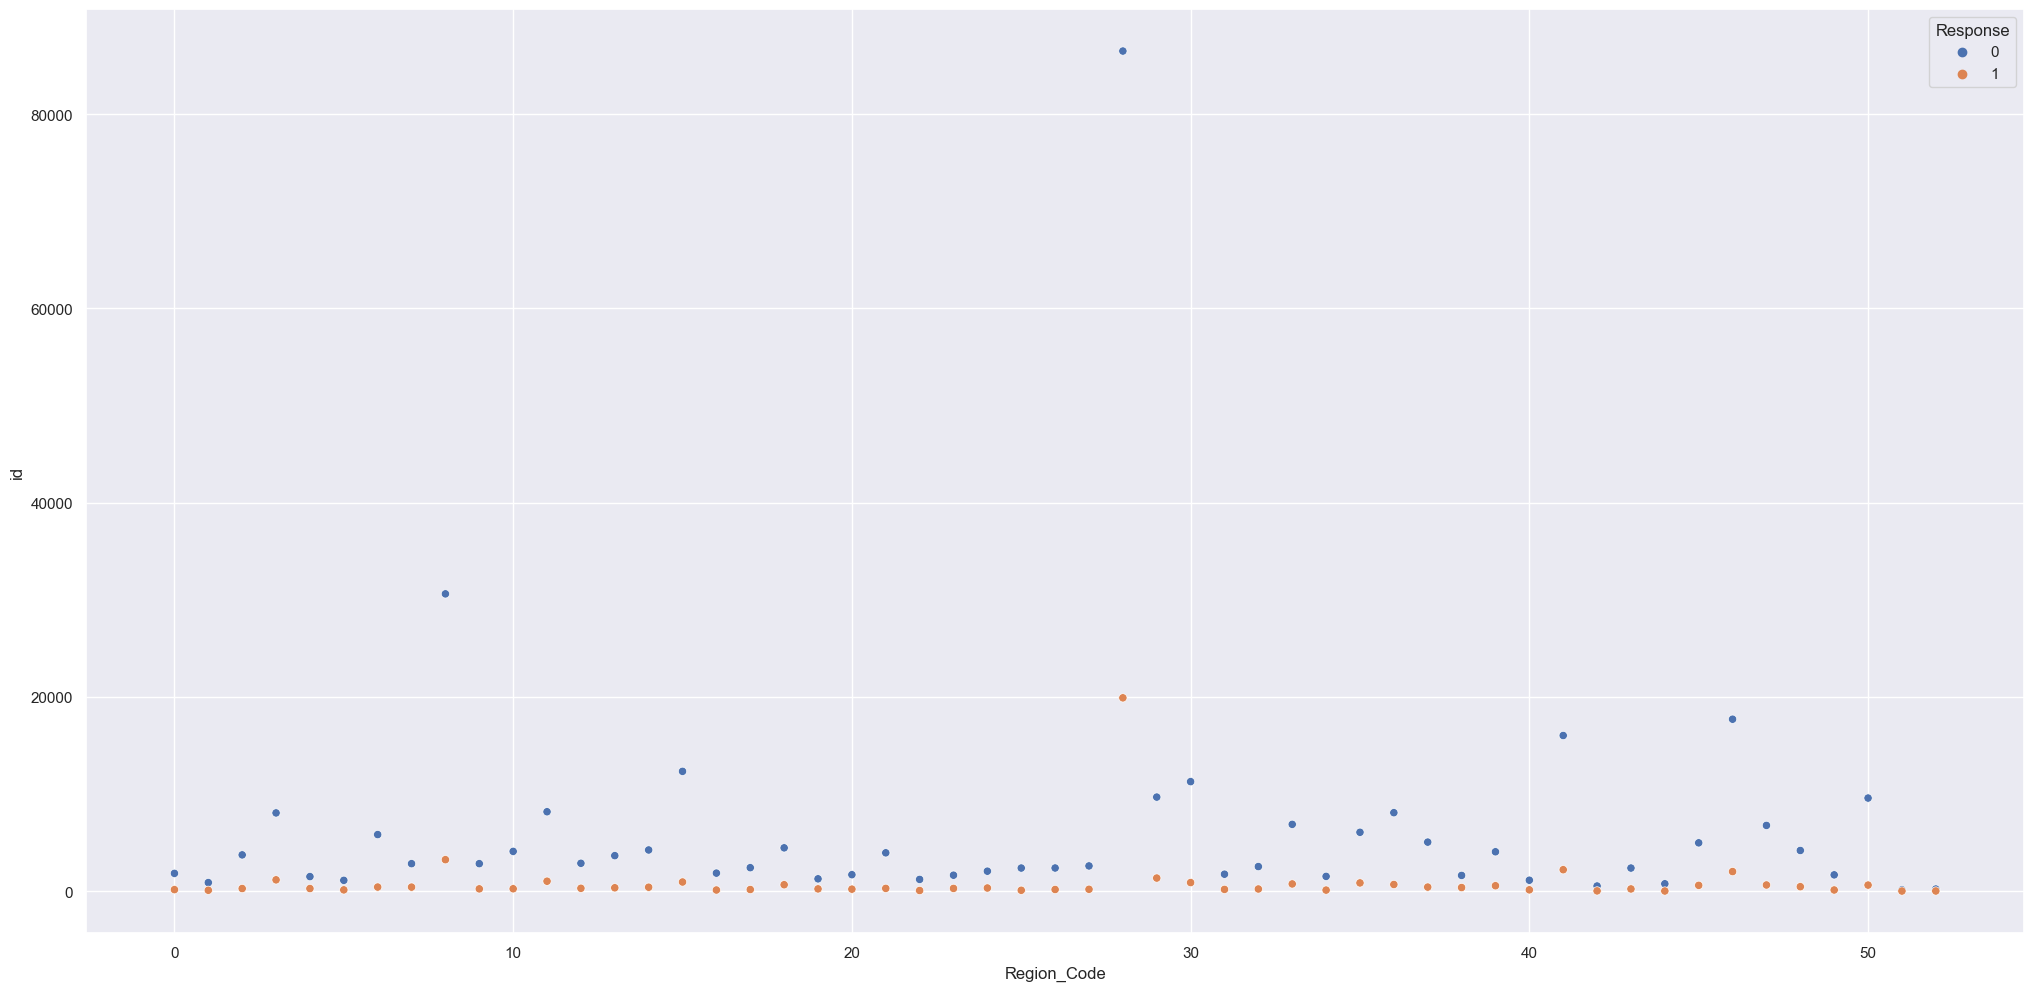

In [134]:
#Region_Code
aux0 = df4[['id', 'Region_Code', 'Response']].groupby(['Region_Code','Response']).count().reset_index()
sns.scatterplot (x='Region_Code', y='id', hue='Response', data=aux0)

In [27]:
#Previously_Insured
pd.crosstab(df4['Previously_Insured'], df4['Response'])

Response,0,1
Previously_Insured,,
0,159929,46552
1,174470,158


In [28]:
#Vehicle_Age
df4[['Vehicle_Age','Response']].value_counts(normalize=True).reset_index()
# in percentage

,Vehicle_Age,Response,0
0,between_1_2_years,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


In [29]:
#Vehicle_Damage
df4[['Vehicle_Damage', 'Response']].value_counts().reset_index()

,Vehicle_Damage,Response,0
0,0,0,187714
1,1,0,146685
2,1,1,45728
3,0,1,982


<AxesSubplot:xlabel='Response', ylabel='Annual_Premium'>

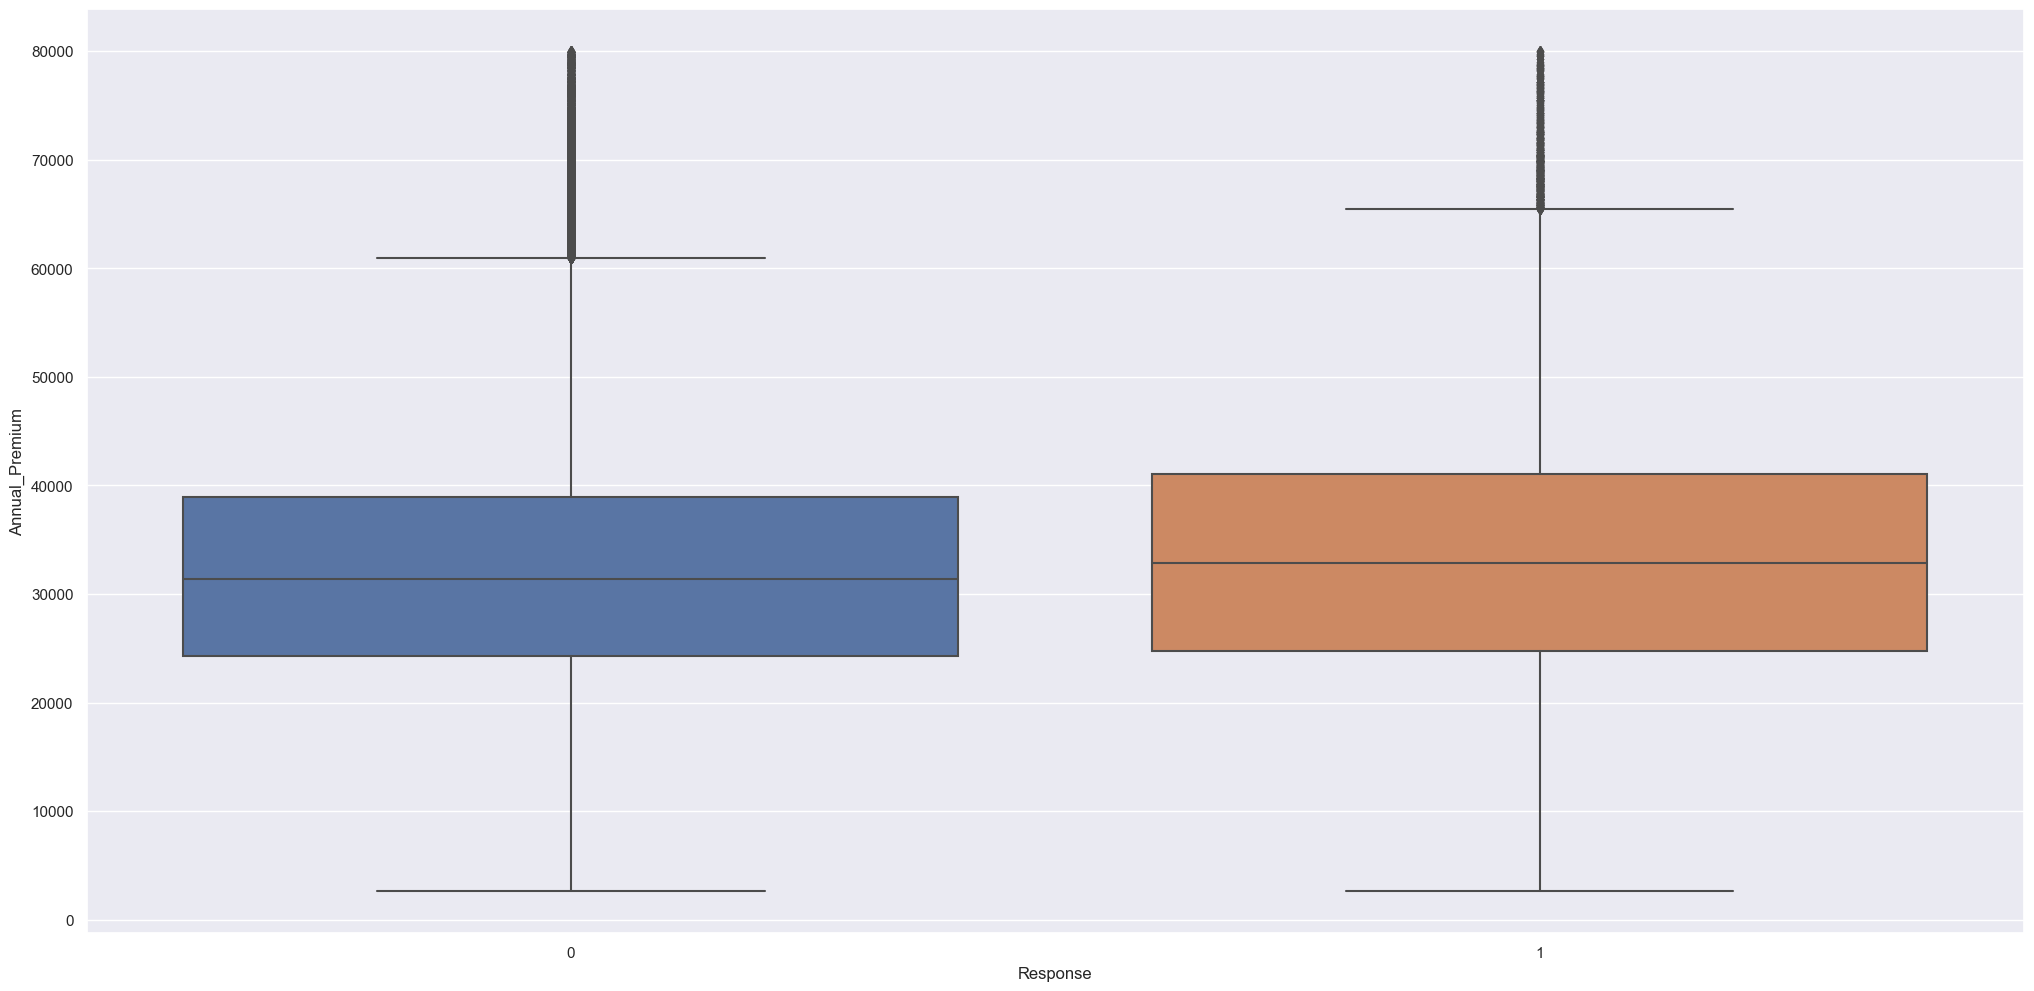

In [151]:
#Annual_Premium
aux = df4[df4['Annual_Premium'] < 80000]
sns.boxplot(x='Response',y='Annual_Premium',data=aux)

<AxesSubplot:xlabel='Annual_Premium', ylabel='Count'>

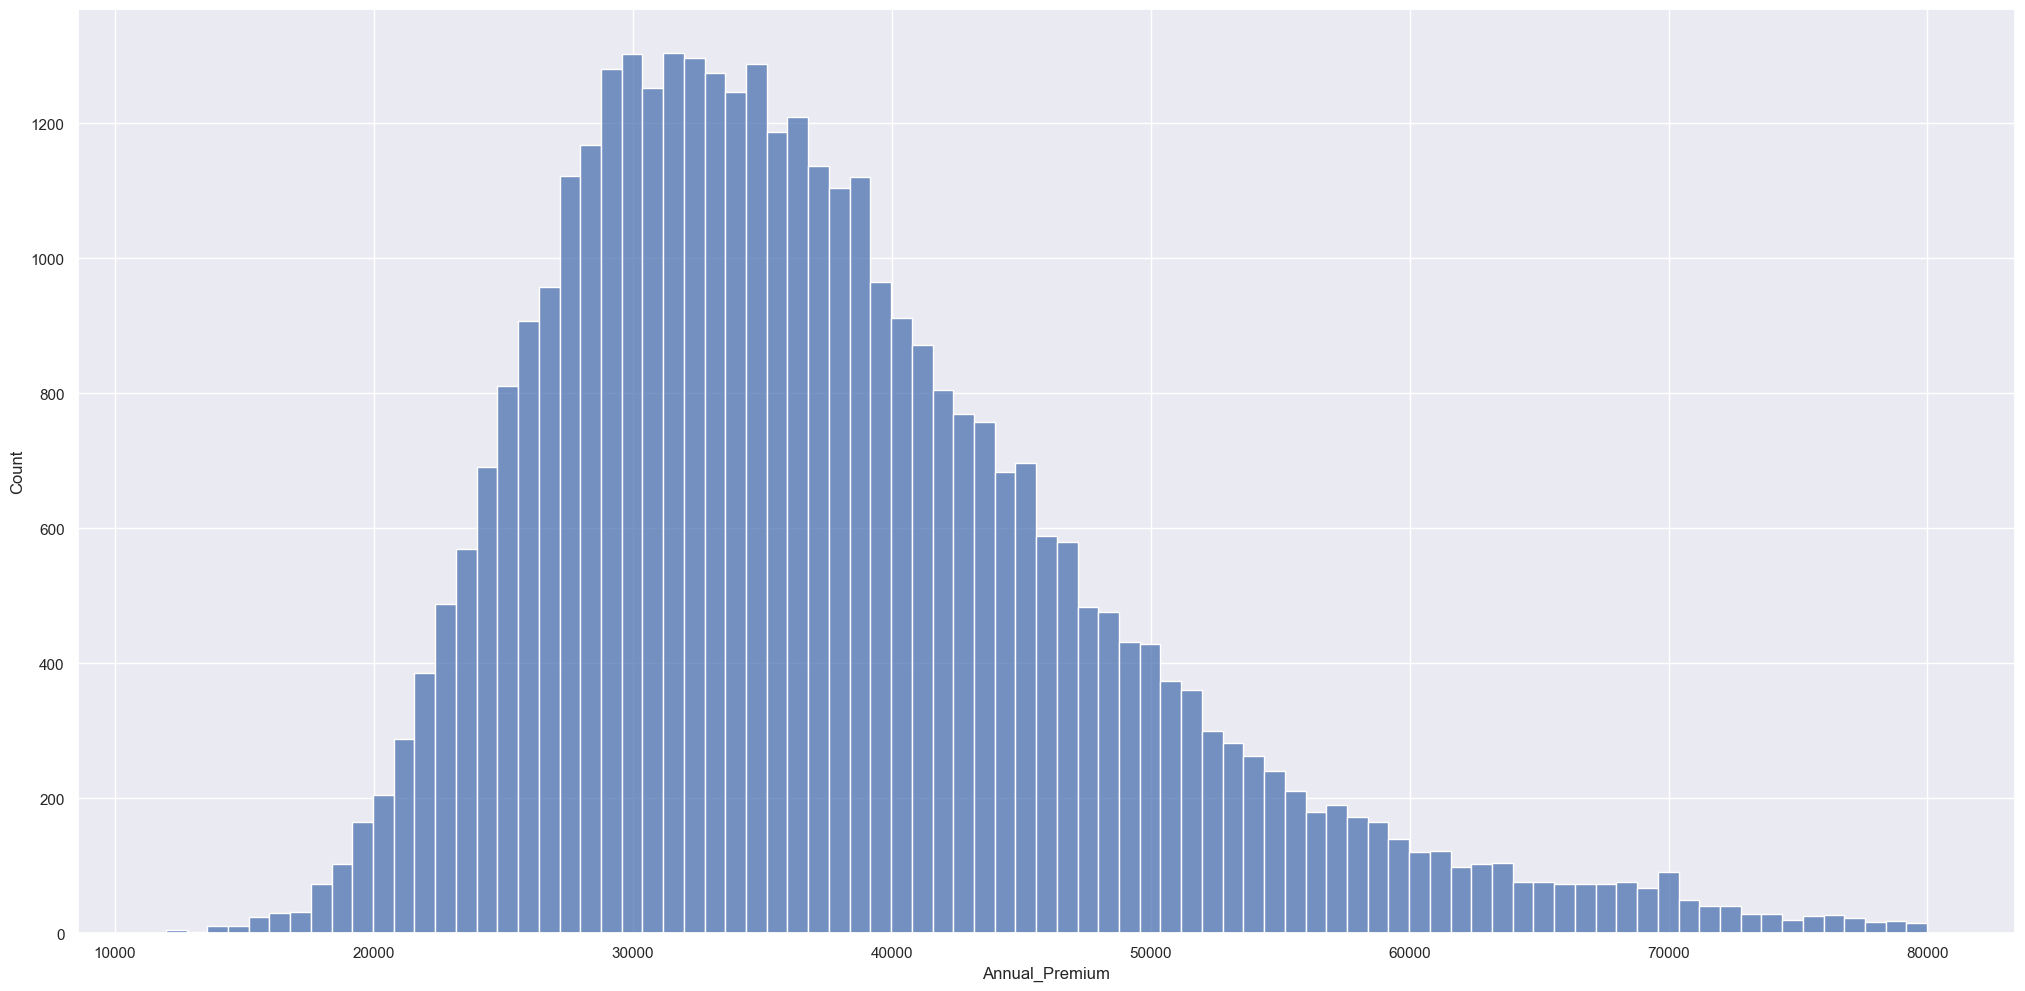

In [152]:
aux = df4[(df4['Annual_Premium'] > 10000) & (df4['Annual_Premium'] < 80000)]
aux0 = aux.loc[aux['Response']==1, 'Annual_Premium']
sns.histplot(aux0)

<AxesSubplot:xlabel='Annual_Premium', ylabel='Count'>

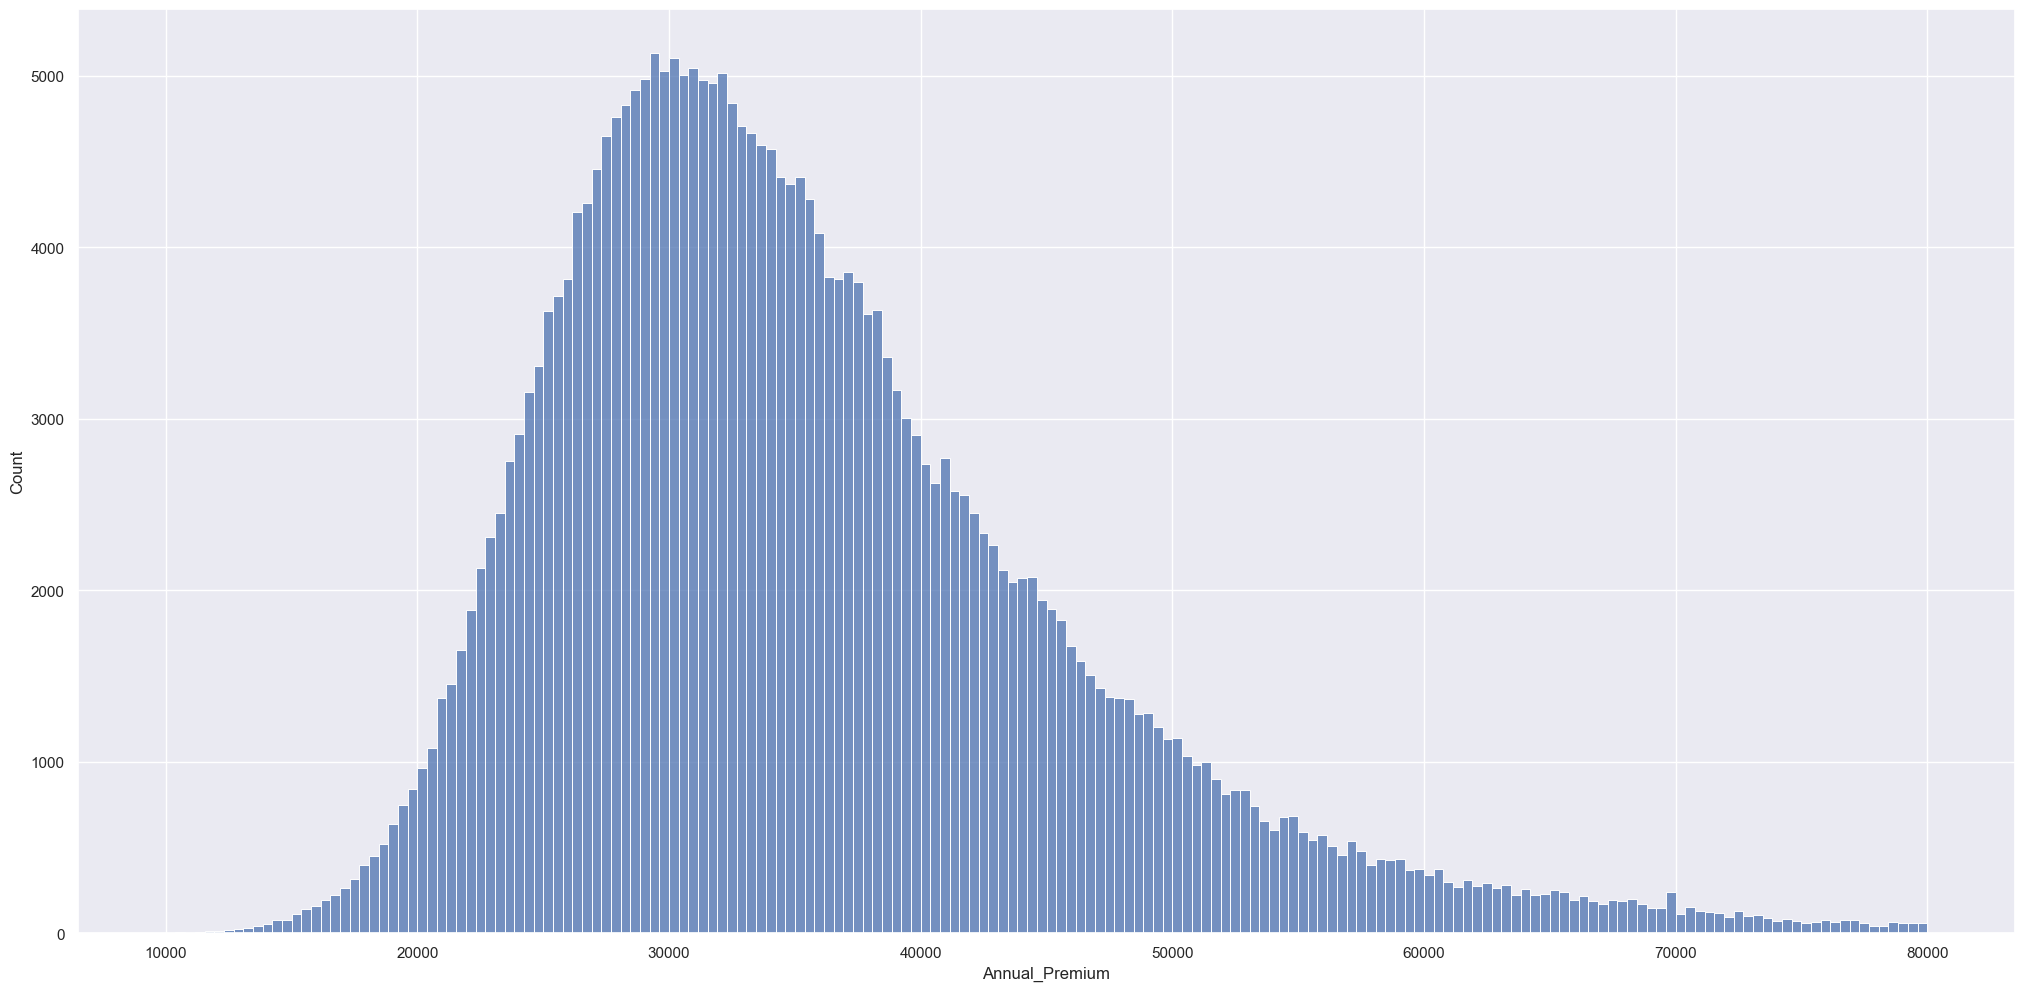

In [153]:
aux = df4[(df4['Annual_Premium'] > 10000) & (df4['Annual_Premium'] < 80000)]
aux0 = aux.loc[aux['Response']==0, 'Annual_Premium']
sns.histplot(aux0)

<AxesSubplot:xlabel='Response', ylabel='Policy_Sales_Channel'>

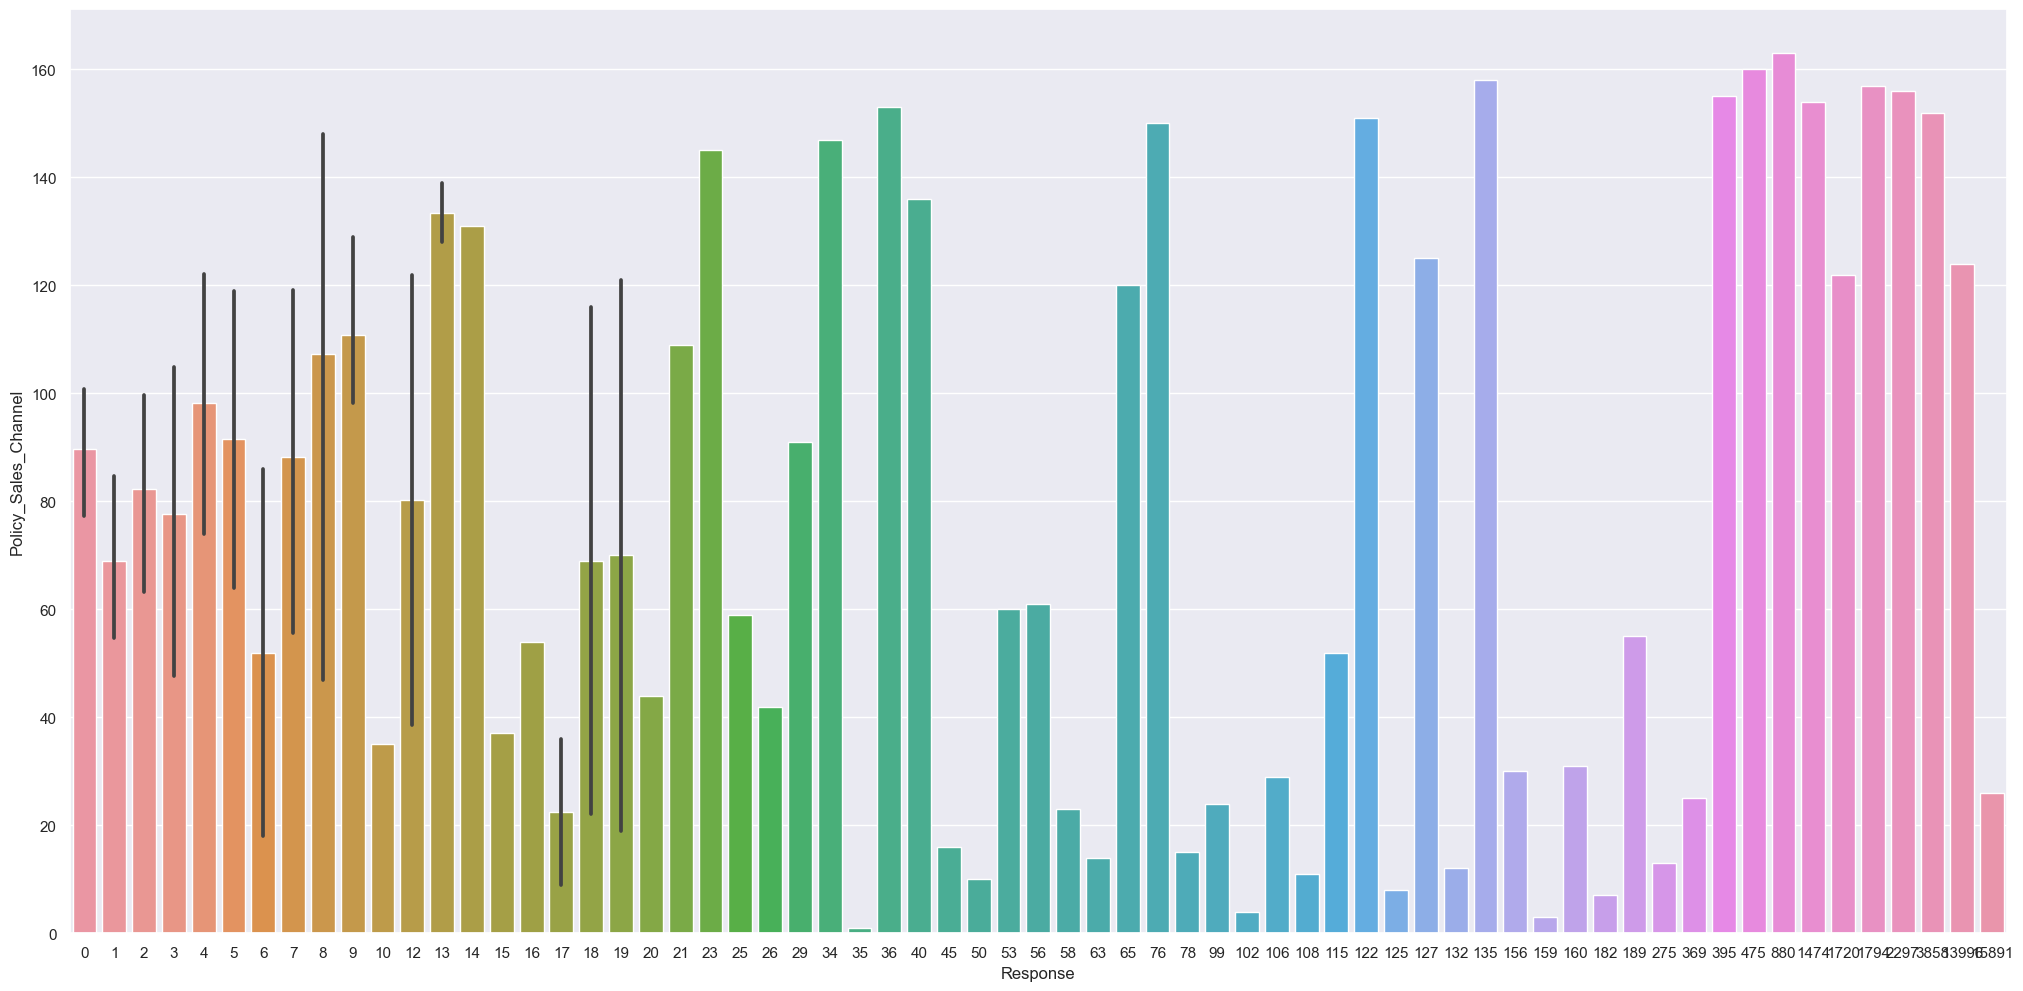

In [135]:
#Policy_Sales_Channel
aux = df4[['Policy_Sales_Channel','Response']].groupby('Policy_Sales_Channel').sum().reset_index()
sns.barplot(x='Response', y='Policy_Sales_Channel', data= aux)

<AxesSubplot:xlabel='Response', ylabel='Vintage'>

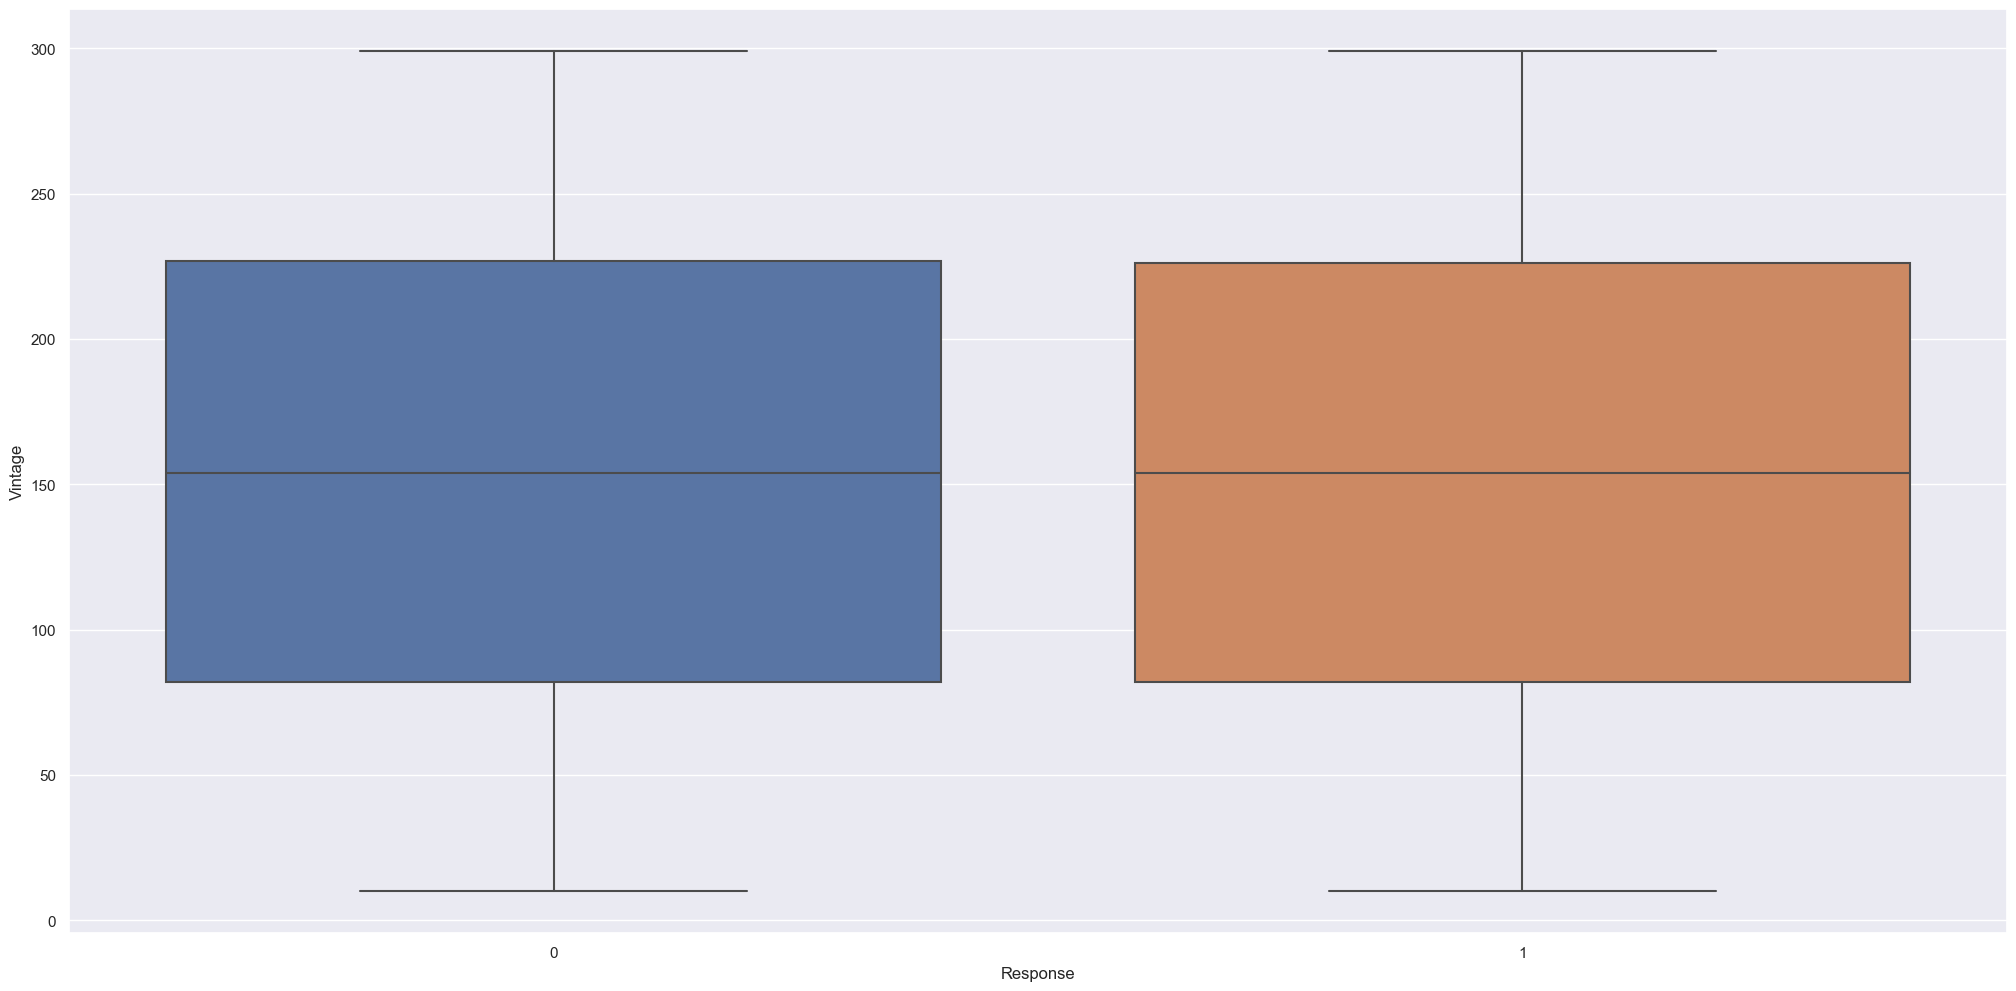

In [154]:
#Vintage
sns.boxplot(x='Response',y='Vintage',data=df4)

<AxesSubplot:xlabel='Vintage', ylabel='Count'>

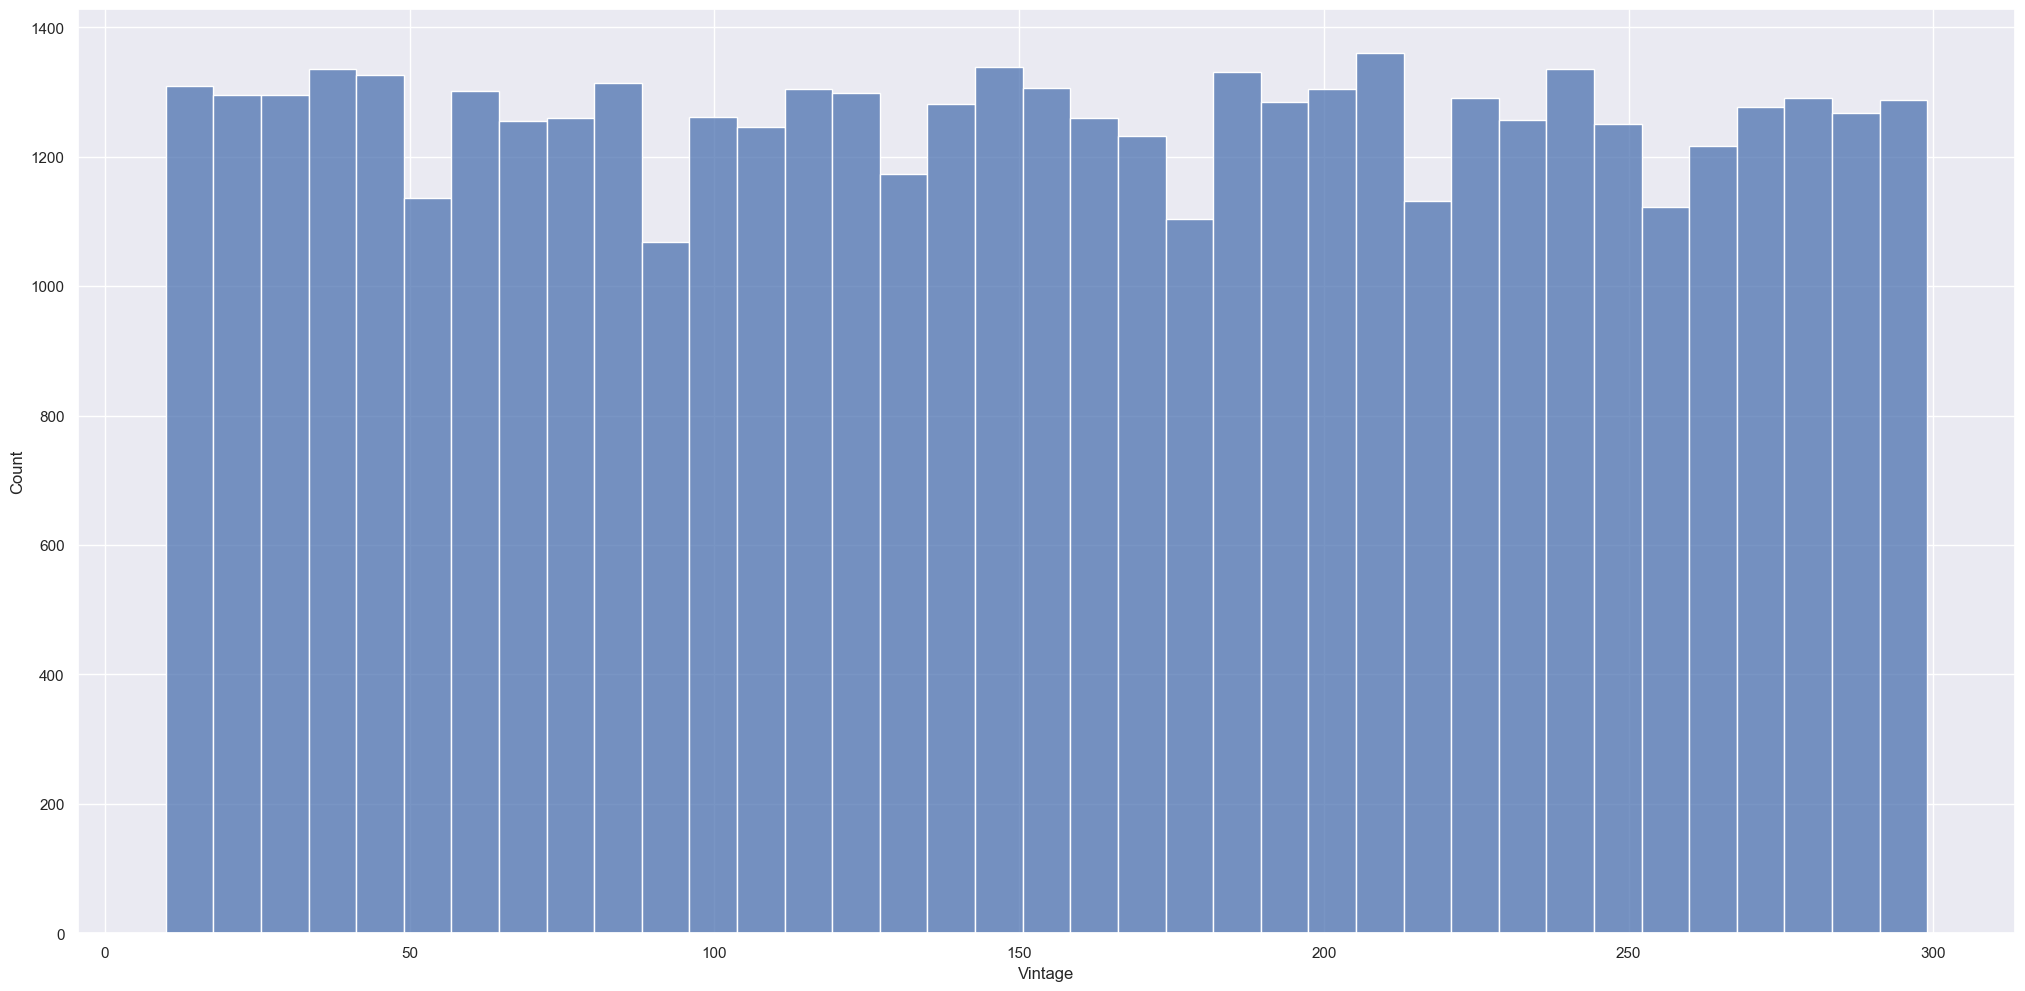

In [155]:
aux0 = df4.loc[df4['Response']==1, 'Vintage']
sns.histplot(aux0)

<AxesSubplot:xlabel='Vintage', ylabel='Count'>

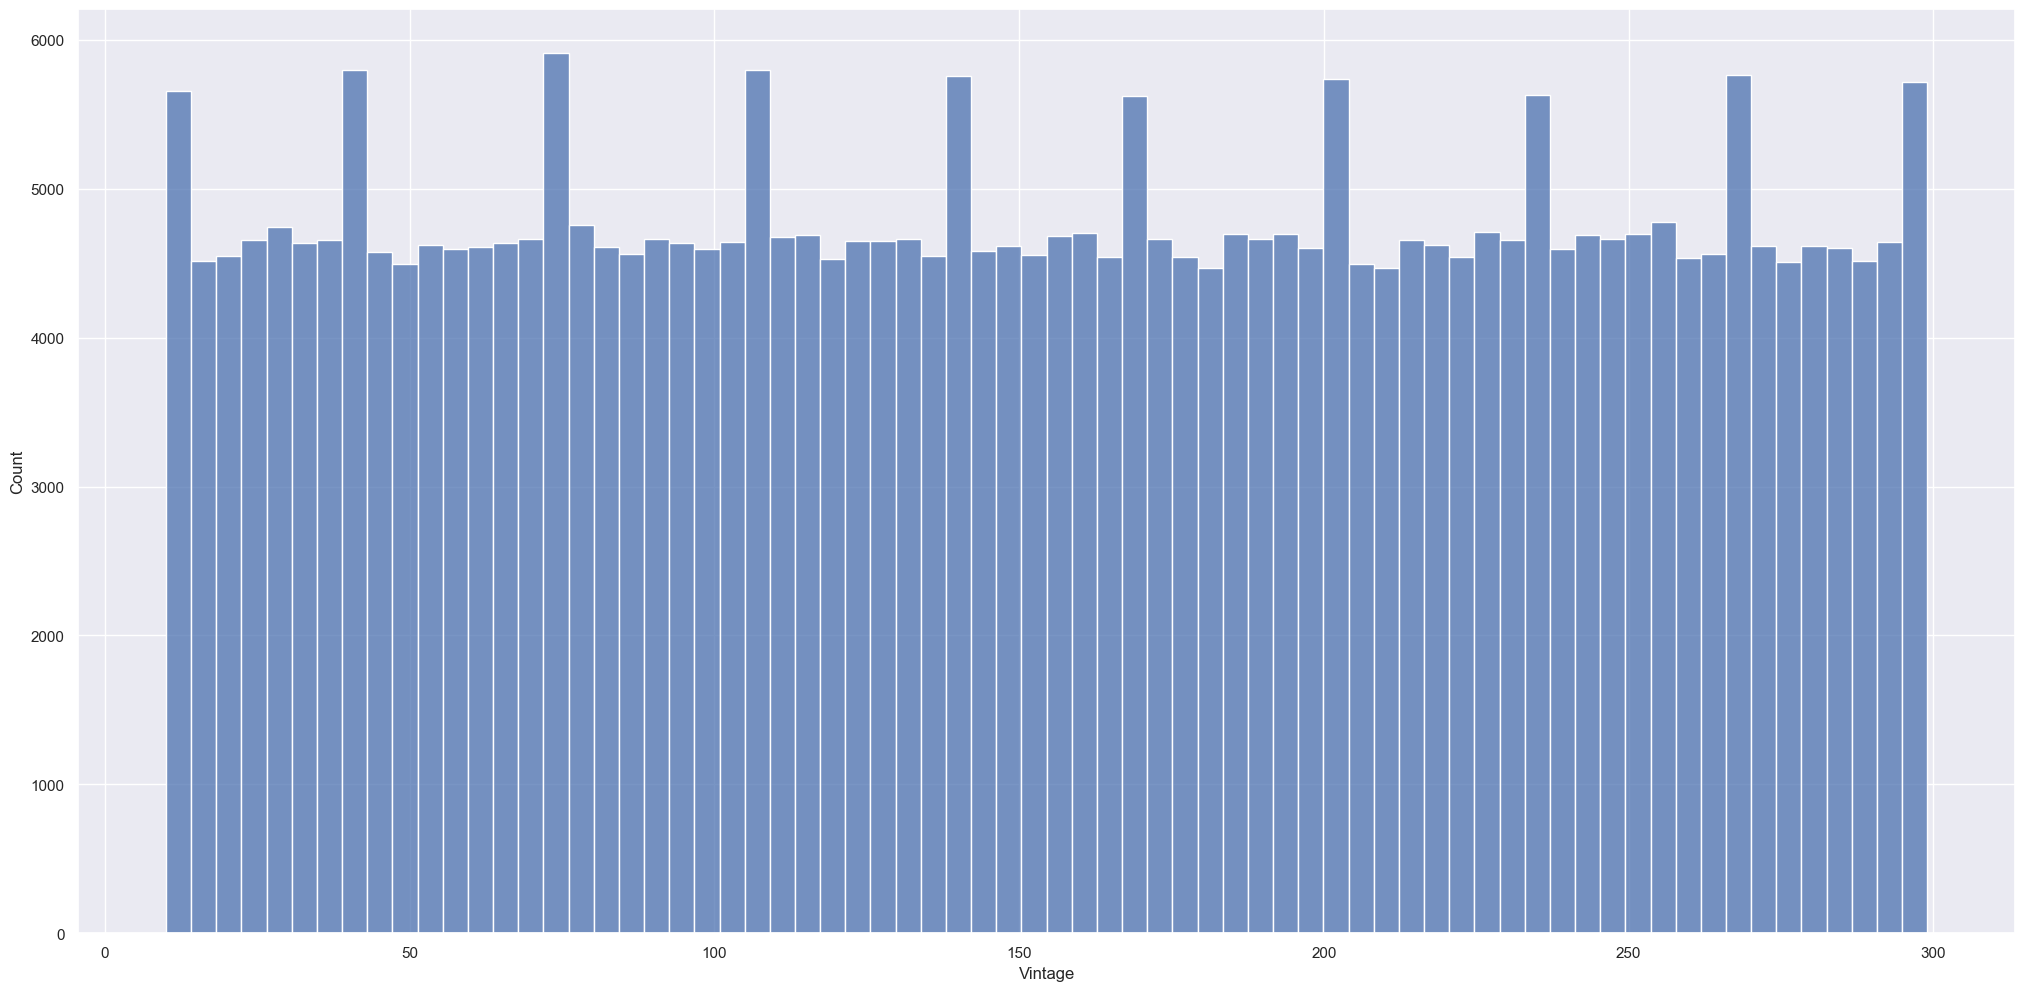

In [156]:
aux0 = df4.loc[df4['Response']==0, 'Vintage']
sns.histplot(aux0)

## 4.2 Bivariate analysis

### 4.2.1 Hypothesis

<b>H1</b>: Owners of newers vehicles are more interested in taking out insurance.

<b>FALSE</b>: Owners of vehicles that are between 1 and 2 years, are more interested in taking out insurance.

<AxesSubplot:xlabel='Vehicle_Age', ylabel='Response'>

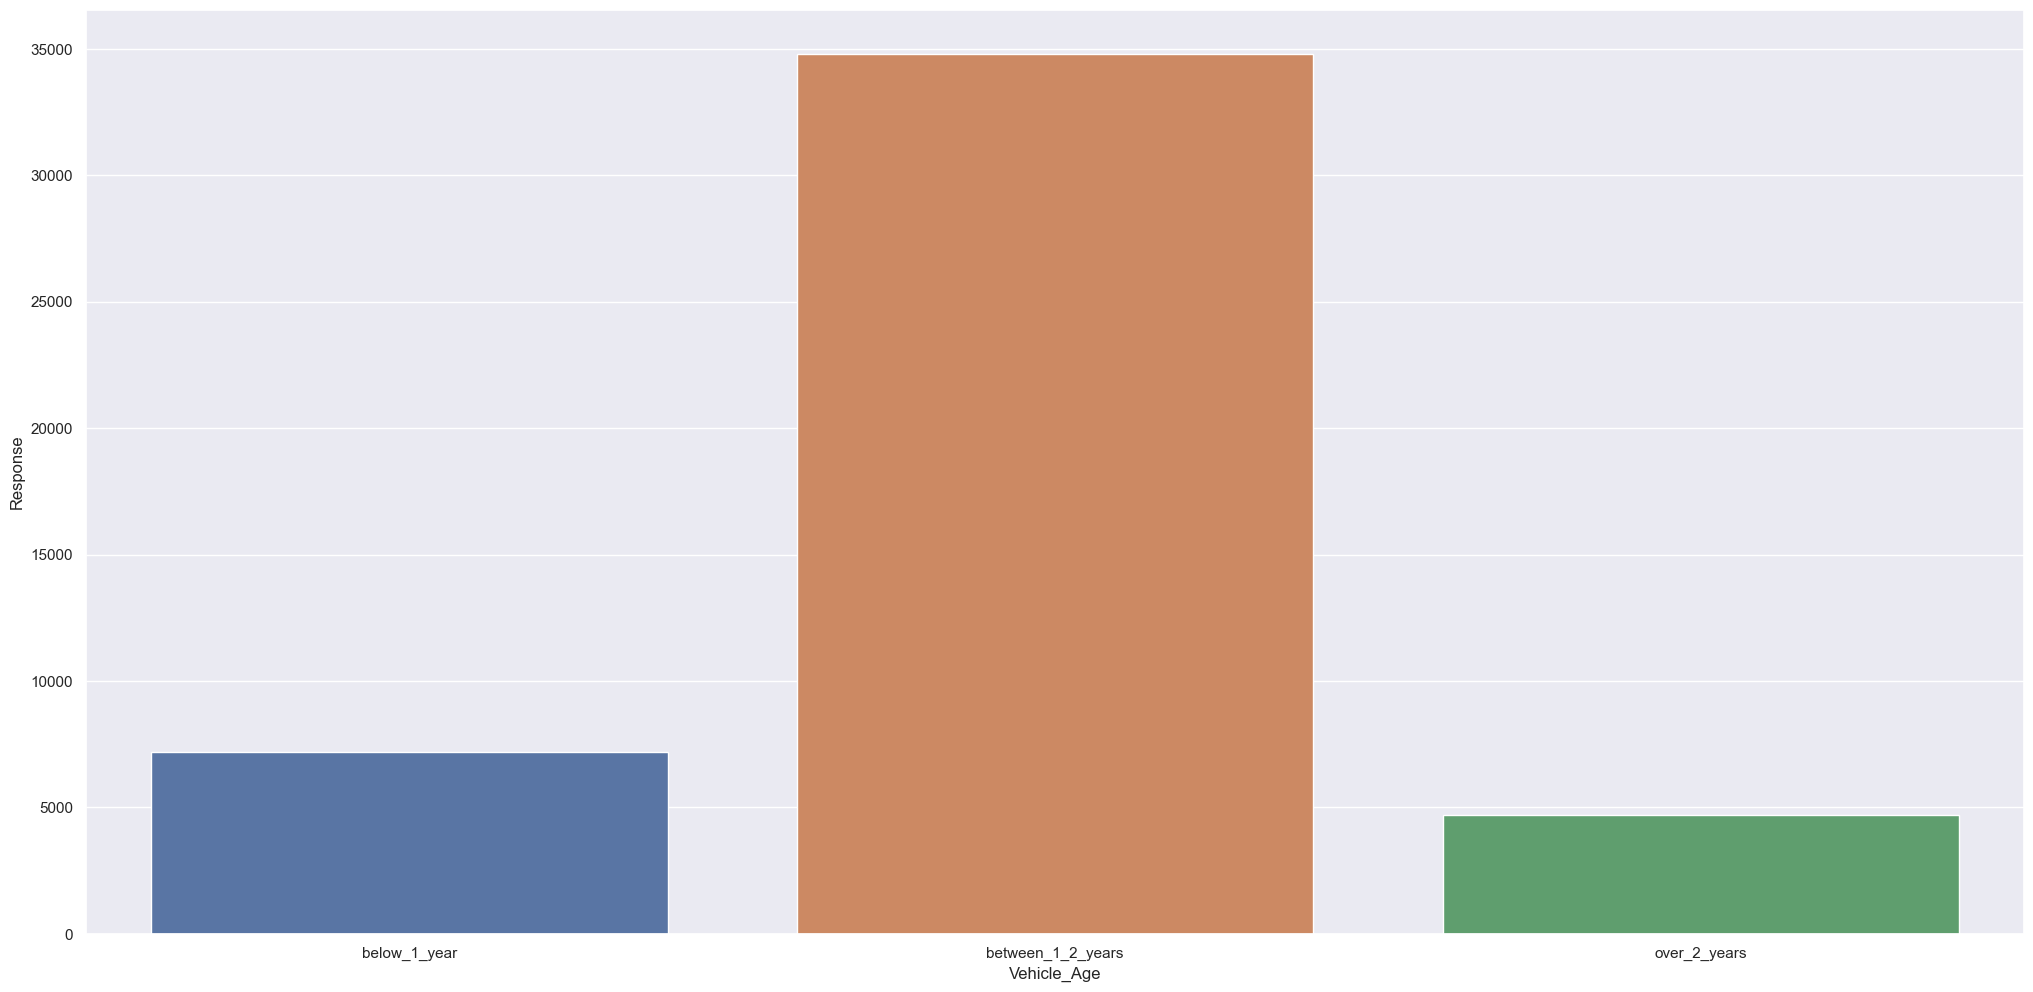

In [147]:
aux1 = df4[['Response','Vehicle_Age']][df4['Response']==1].groupby('Vehicle_Age').count().reset_index()
sns.barplot(x='Vehicle_Age', y='Response', data=aux1)

<b>H2</b>: Owners of damaged vehicles are more interested in taking out insurance.

<b>TRUE</b>: Owners of damaged vehicles are really much more interested in taking out insurance.

<AxesSubplot:title={'center':'Interested'}, xlabel='Vehicle_Damage', ylabel='Response'>

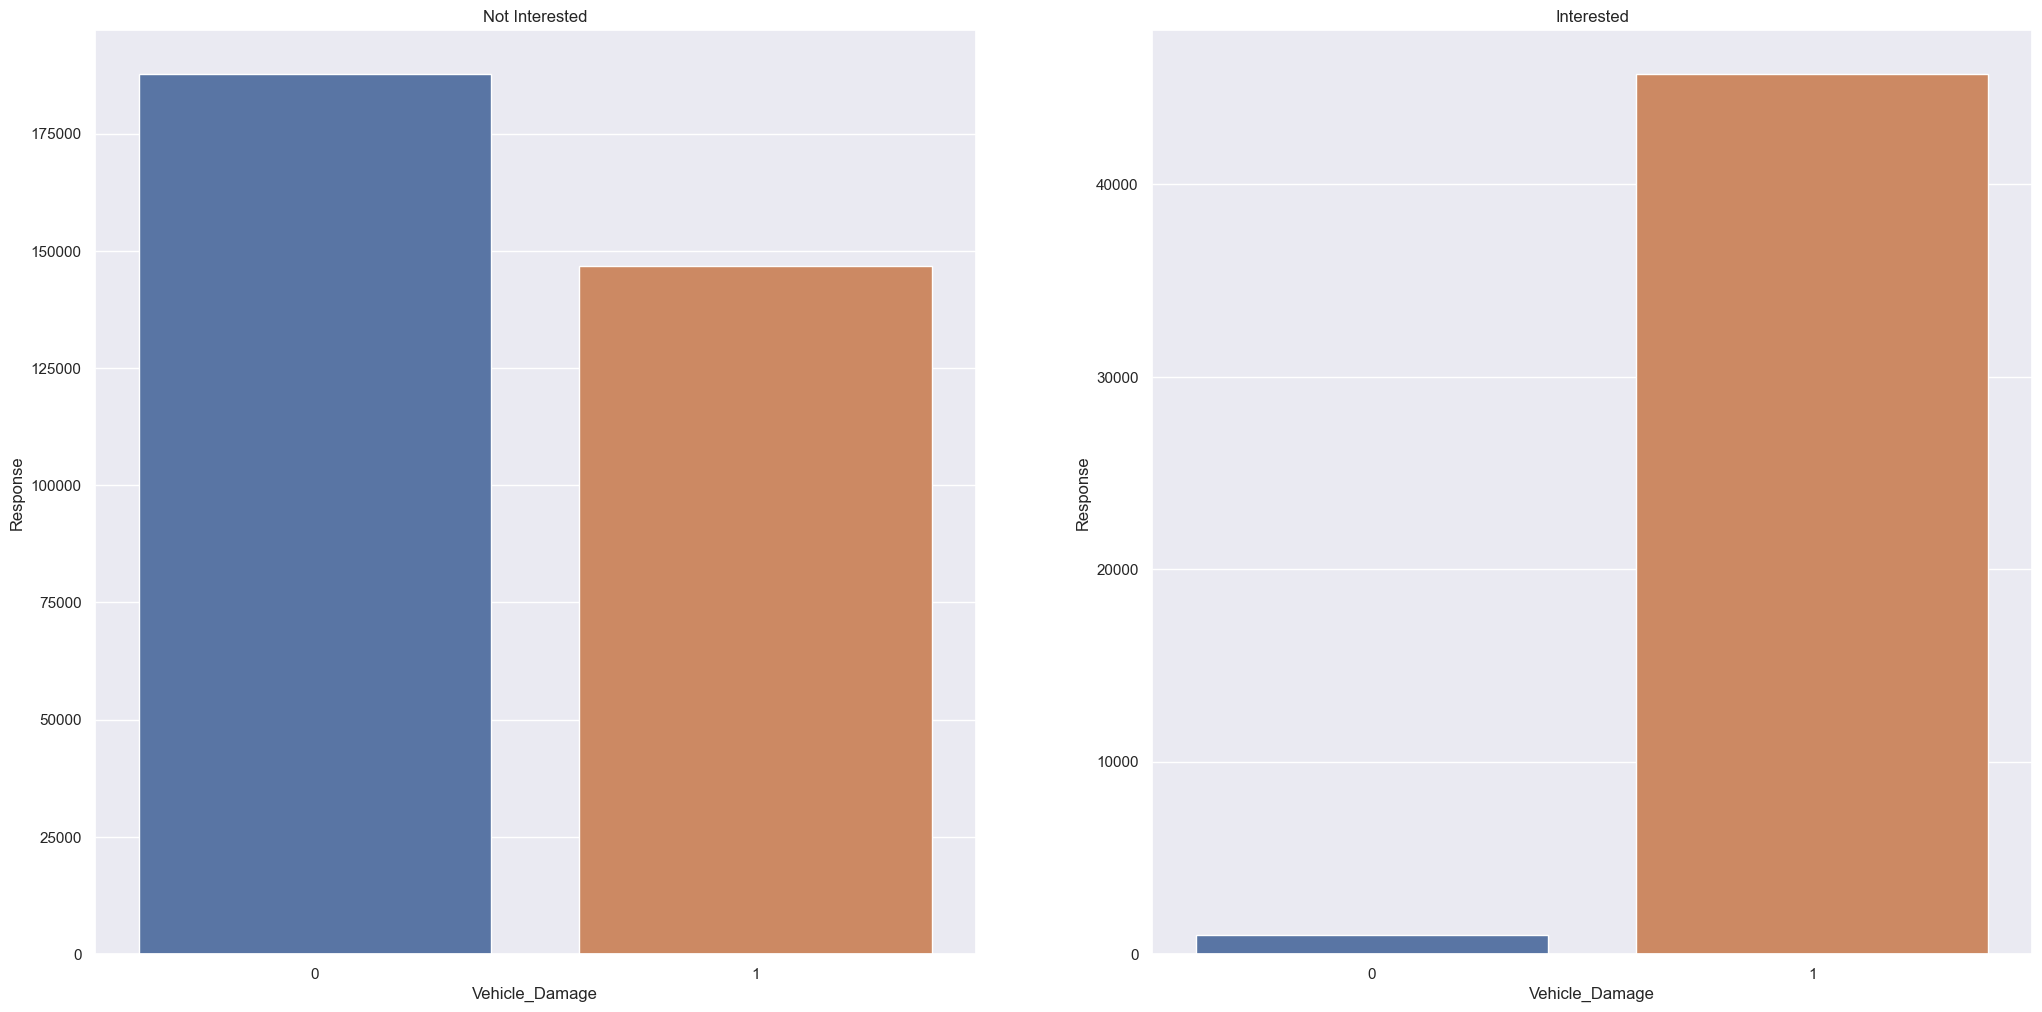

In [136]:
plt.subplot(1,2,1)
plt.title('Not Interested')
aux1 = df4[['Response','Vehicle_Damage']][df4['Response']==0].groupby('Vehicle_Damage').count().reset_index()
sns.barplot(x='Vehicle_Damage', y='Response', data=aux1)

plt.subplot(1,2,2)
plt.title('Interested')
aux1 = df4[['Response','Vehicle_Damage']][df4['Response']==1].groupby('Vehicle_Damage').count().reset_index()
sns.barplot(x='Vehicle_Damage', y='Response', data=aux1)

<b>H3</b>: Women are more interested in taking out insurance.

<b>FALSE</b>: Men are more interested in taking out insurance.

<AxesSubplot:xlabel='Gender', ylabel='Response'>

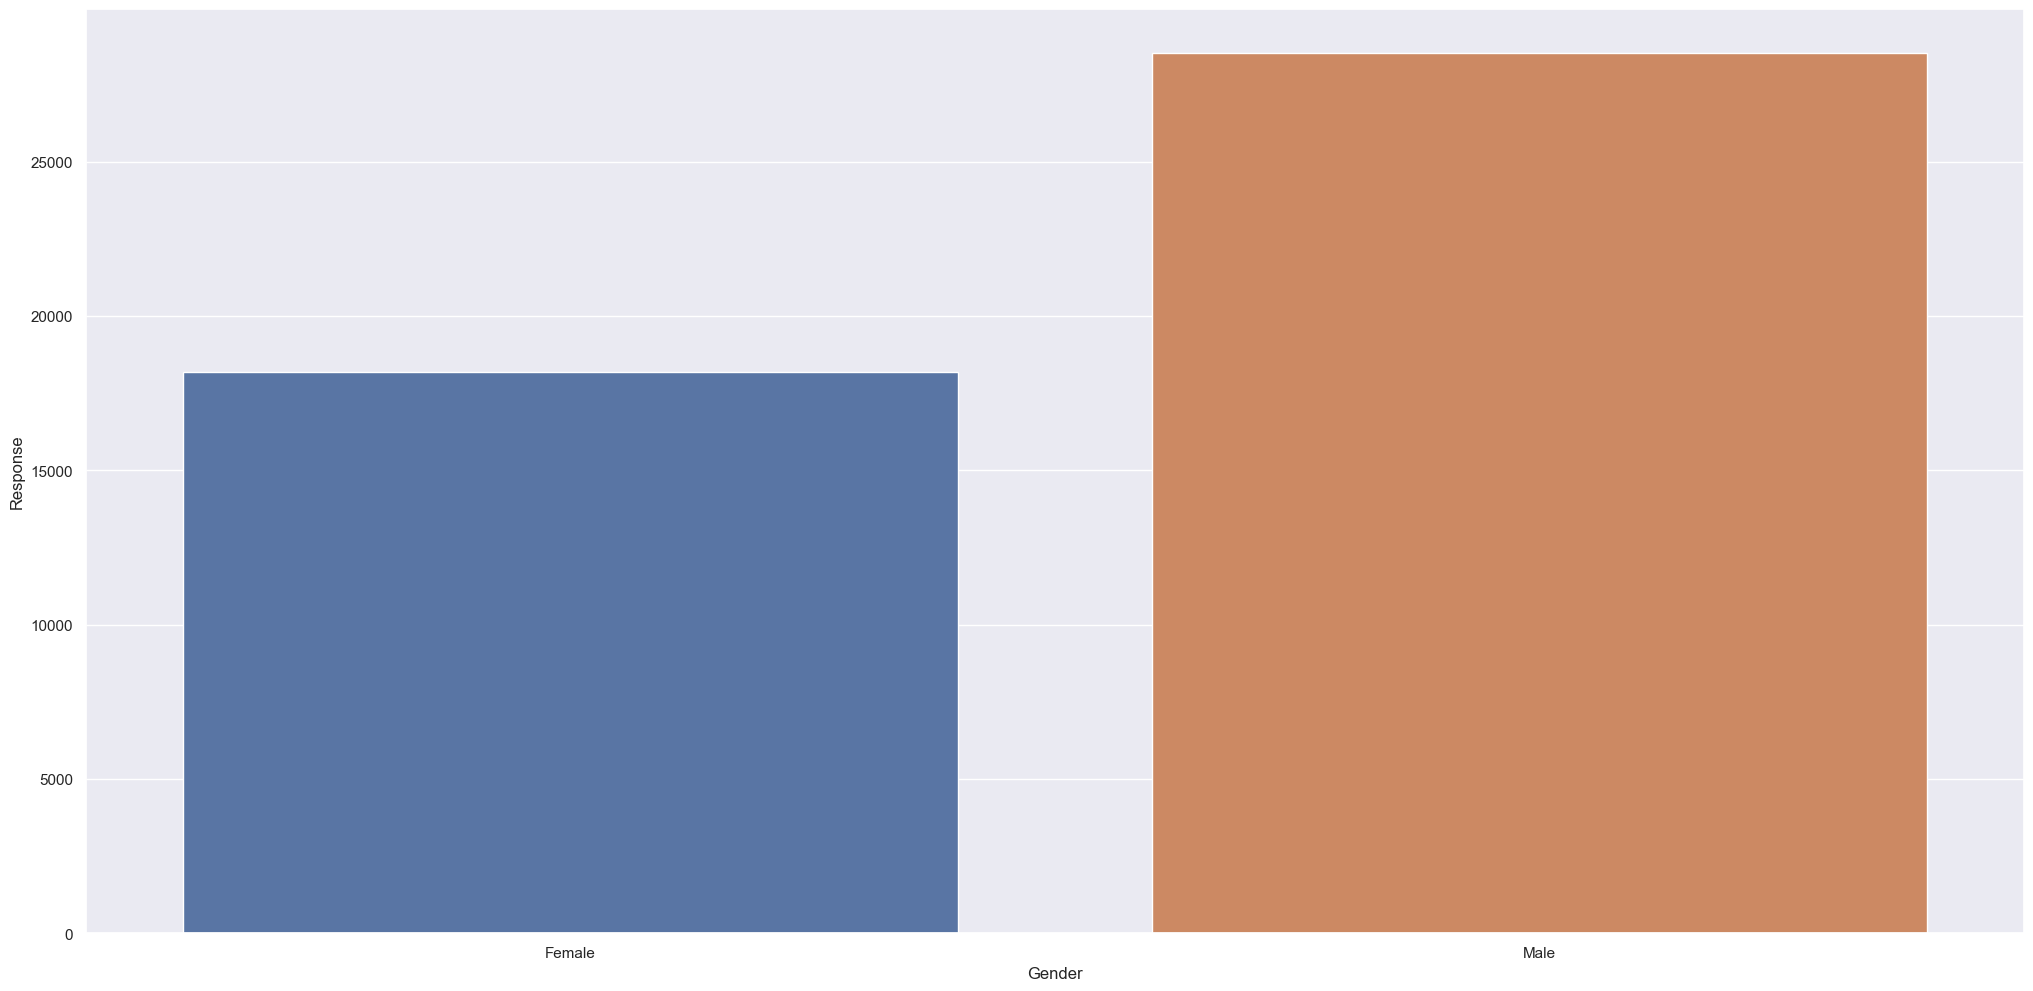

In [146]:
aux1 = df4[['Response','Gender']][df4['Response']==1].groupby('Gender').count().reset_index()
sns.barplot(x='Gender', y='Response', data=aux1)

<b>H4</b>: Young people are less interested in taking out insurance.

<b>TRUE</b>: Young people are less interested in taking out insurance, comparing with other ages.

<AxesSubplot:xlabel='Age', ylabel='Response'>

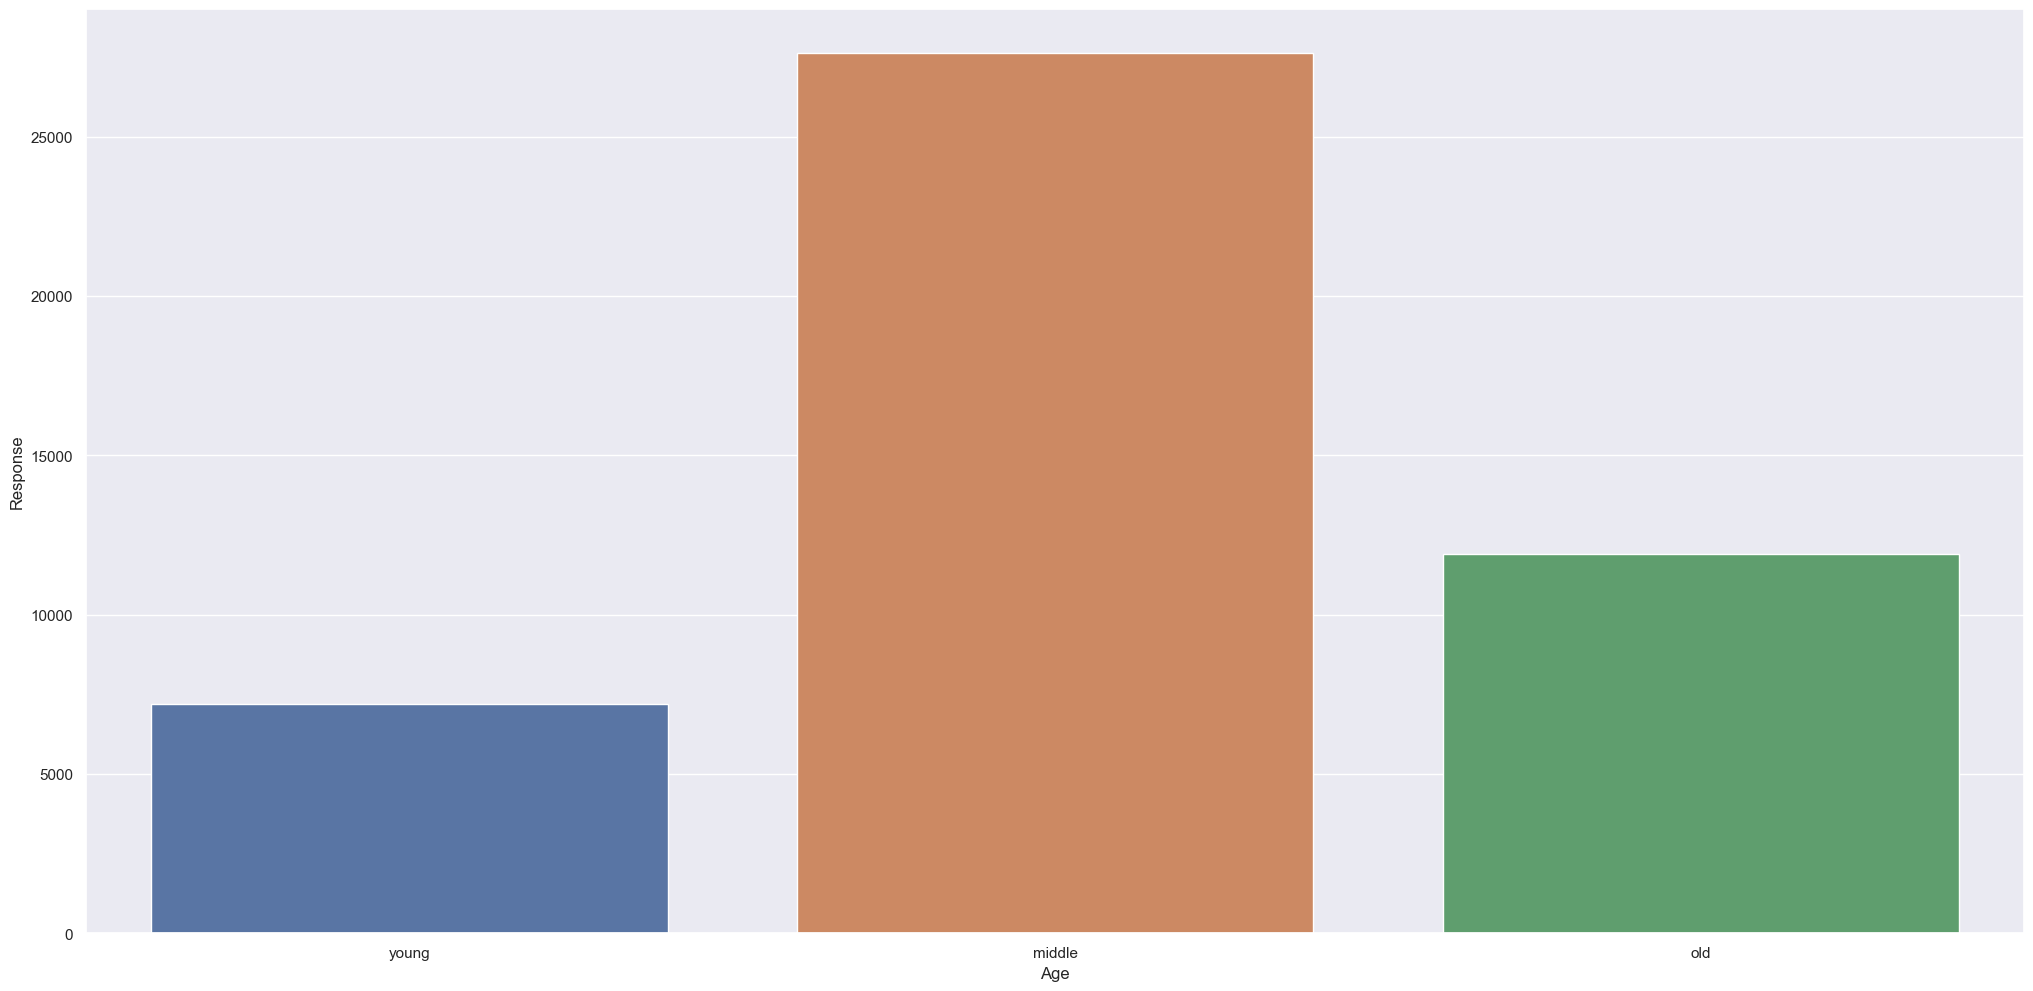

In [145]:
df_aux = df4.copy()
df_aux['Age'] = df4['Age'].apply(lambda x: 'young' if x <=30 else
                                           'middle'if x <=50 else
                                           'old')

aux1 = df_aux[['Response','Age']][df_aux['Response']==1].groupby('Age').count().reset_index()
sns.barplot(x='Age', y='Response', data=aux1, order=['young','middle','old'])

<b>H5</b>: More annual premium, more interested in taking out insurance.

<b>FALSE</b>: People with an annual premium less than 50.000 dollars are more interested in taking out insurance.

In [41]:
x=df4['Annual_Premium'].min()
y=df4['Annual_Premium'].max()
w=df4['Annual_Premium'].mean()
z=df4['Annual_Premium'].median()

print('min:{}'.format(x),'max:{}'.format(y),'mean:{}'.format(w),'median:{}'.format(z))

min:2630.0 max:540165.0 mean:30564.389581458323 median:31669.0


<AxesSubplot:xlabel='Annual_Premium', ylabel='Response'>

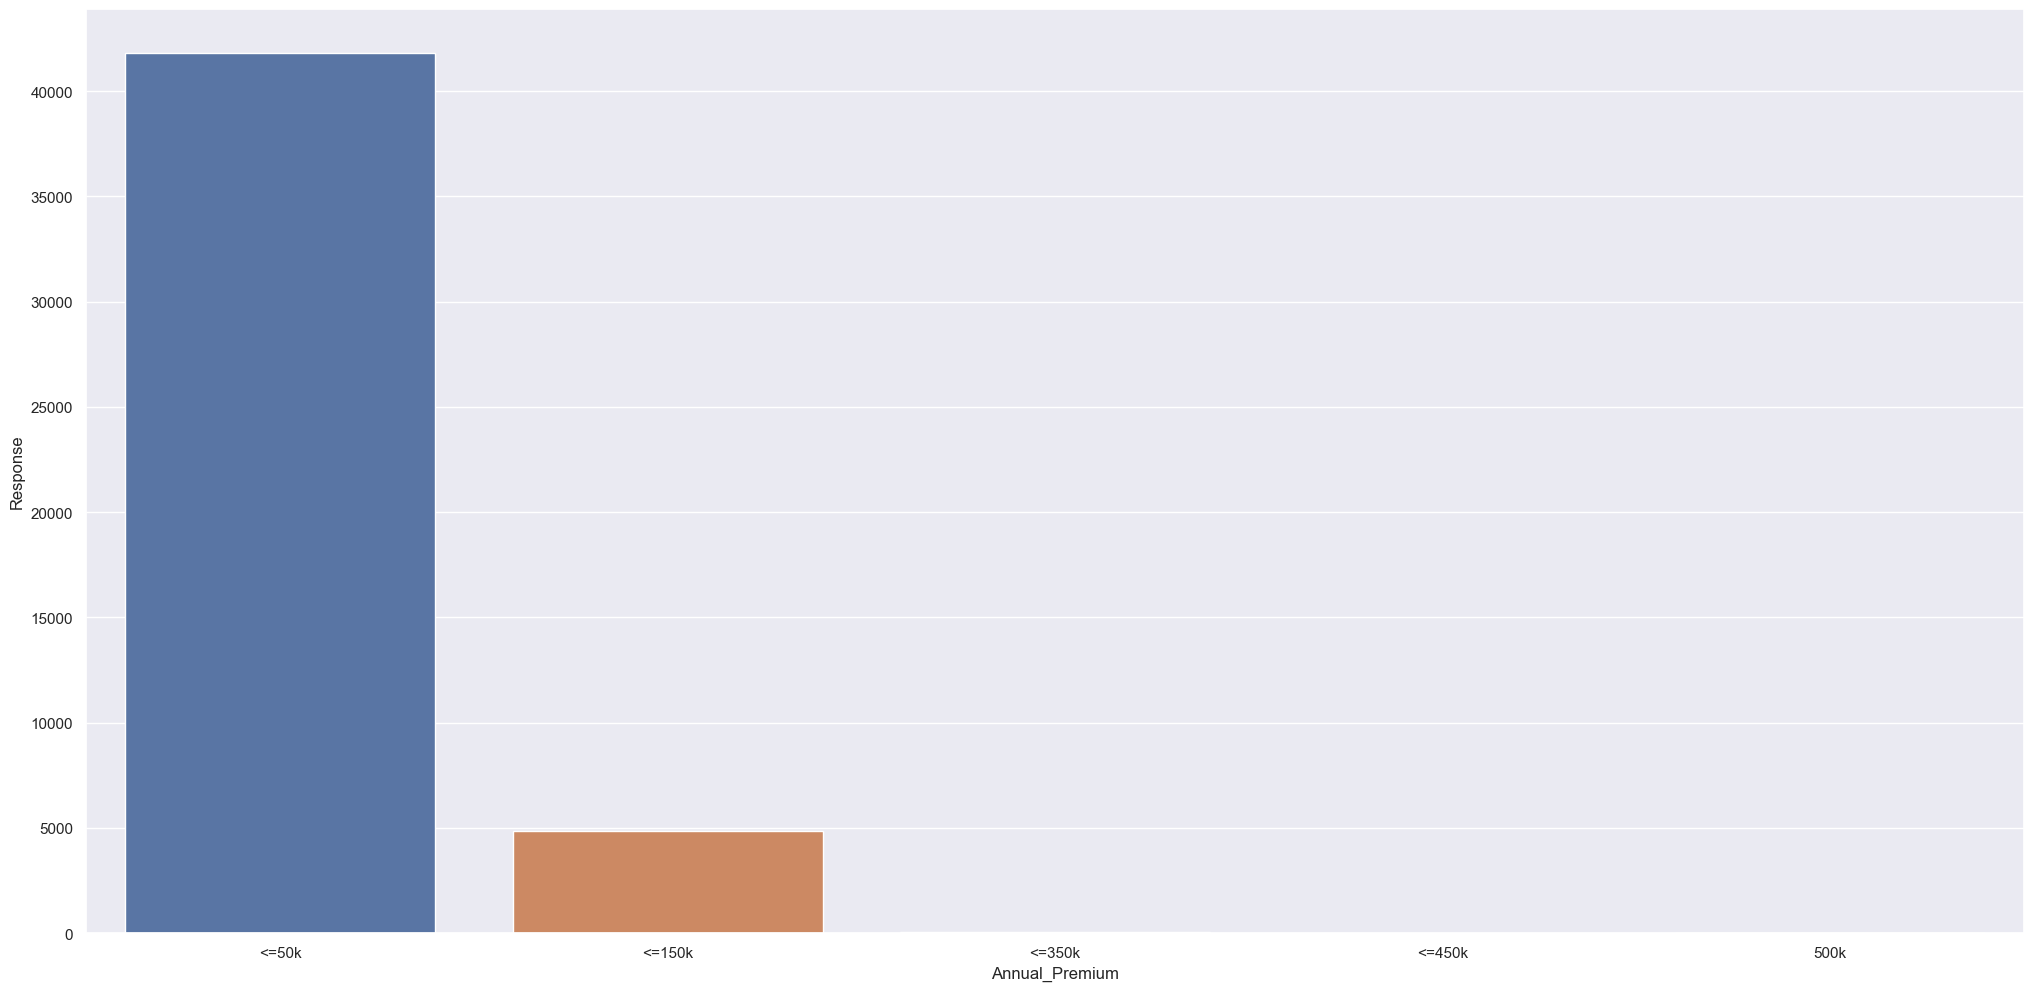

In [137]:
df_aux = df4.copy()
df_aux['Annual_Premium'] = df4['Annual_Premium'].apply(lambda x: '<=50k' if x <=50000 else
                                                                 '<=150k' if x <=150000 else
                                                                 '<=350k' if x <=350000 else
                                                                 '<=450k' if x <=450000 else
                                                                 '500k')

aux1 = df_aux[['Response','Annual_Premium']][df_aux['Response']==1].groupby('Annual_Premium').count().reset_index()
sns.barplot(x='Annual_Premium', y='Response', data=aux1, order=['<=50k', '<=150k', '<=350k','<=450k','500k'])

<b>H6</b>: Customers that have between 200 to 299 days contract time, are more interested in taking out insurance.

<b>TRUE</b>: Customers that have 200 days or more contract time, are more interested in taking out insurance, comparing others customers.

In [43]:
x=df4['Vintage'].min()
y=df4['Vintage'].max()
w=df4['Vintage'].mean()
z=df4['Vintage'].median()

print('min:{}'.format(x),'max:{}'.format(y),'mean:{}'.format(w),'median:{}'.format(z))

min:10 max:299 mean:154.34739667654136 median:154.0


<AxesSubplot:xlabel='Vintage', ylabel='Response'>

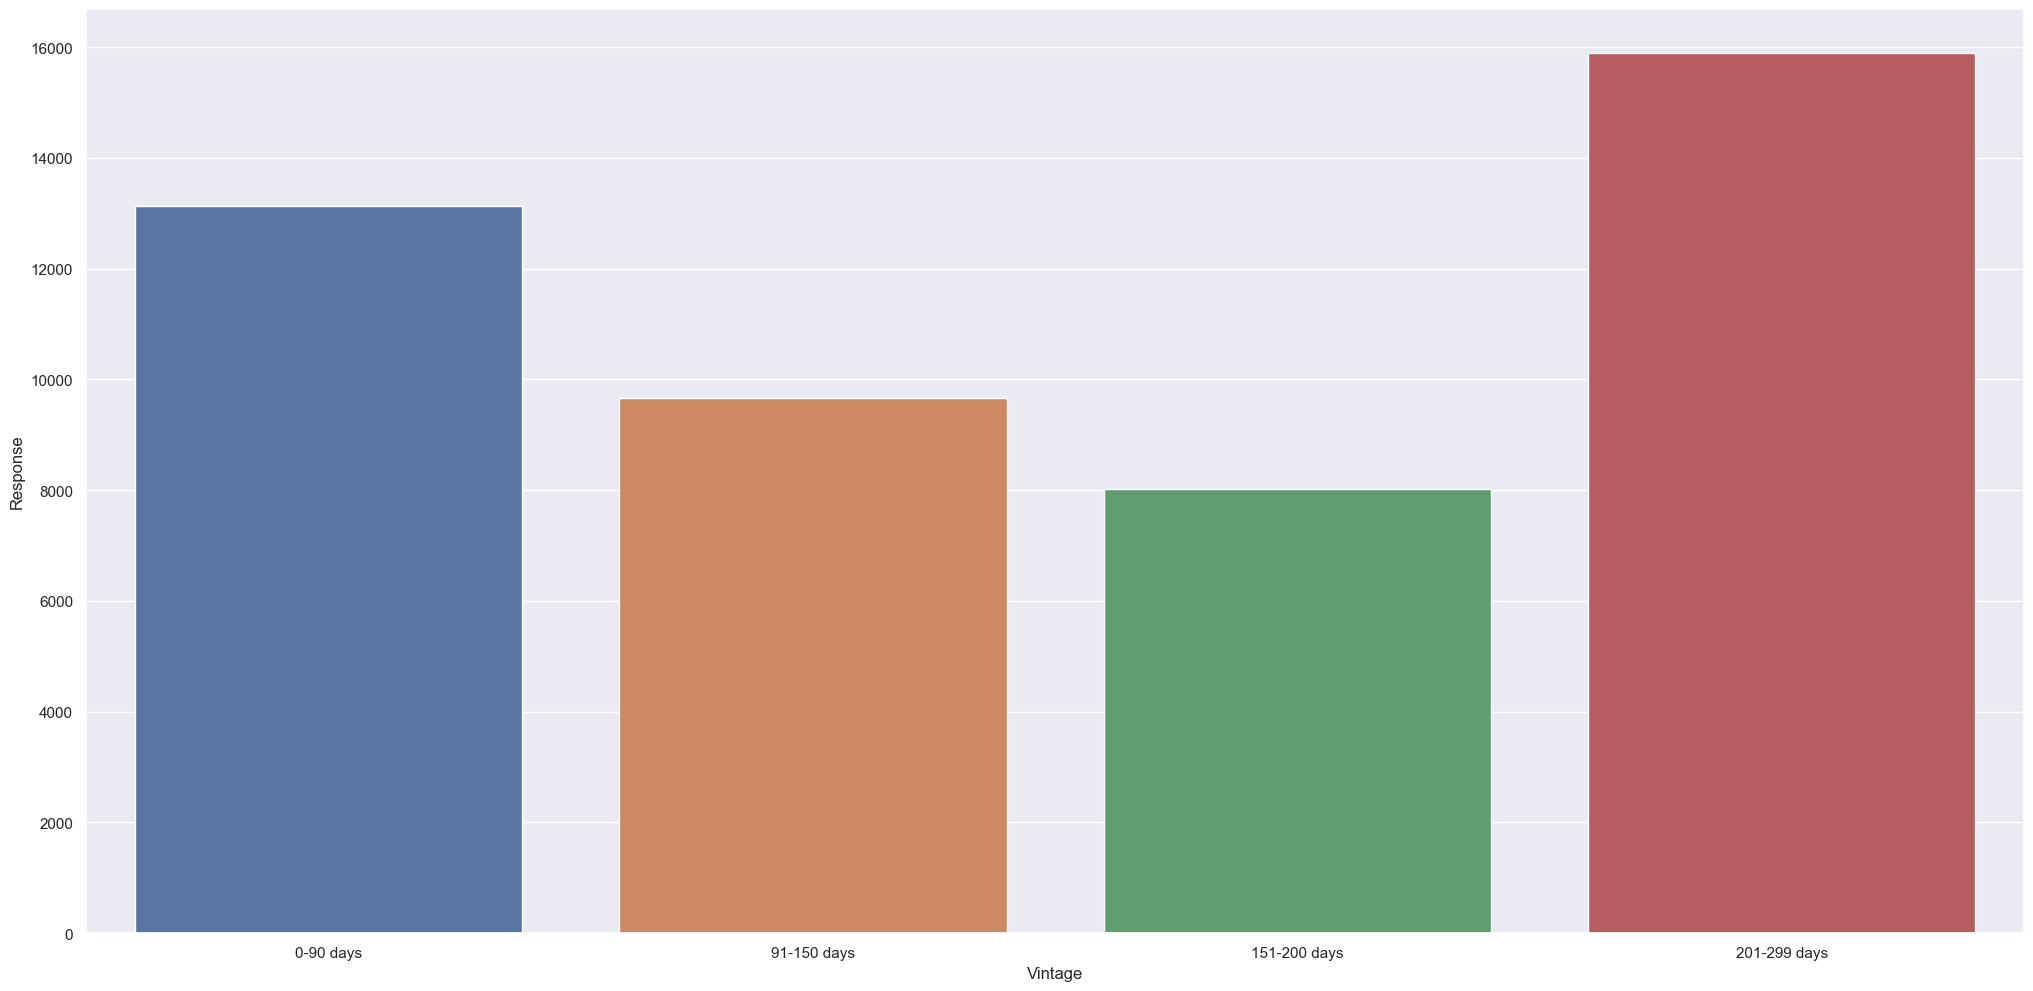

In [144]:
df_aux = df4.copy()
df_aux['Vintage'] = df4['Vintage'].apply(lambda x: '0-90 days'    if x <=90 else
                                                   '91-150 days'  if x <=150 else
                                                   '151-200 days' if x <=200 else
                                                   '201-299 days')

aux1 = df_aux[['Response','Vintage']][df_aux['Response']==1].groupby('Vintage').count().reset_index()
sns.barplot(x='Vintage', y='Response', data=aux1, order=['0-90 days', '91-150 days','151-200 days','201-299 days'])

## 4.2 Multvariate analysis 

### 4.2.1 Numerical attributes

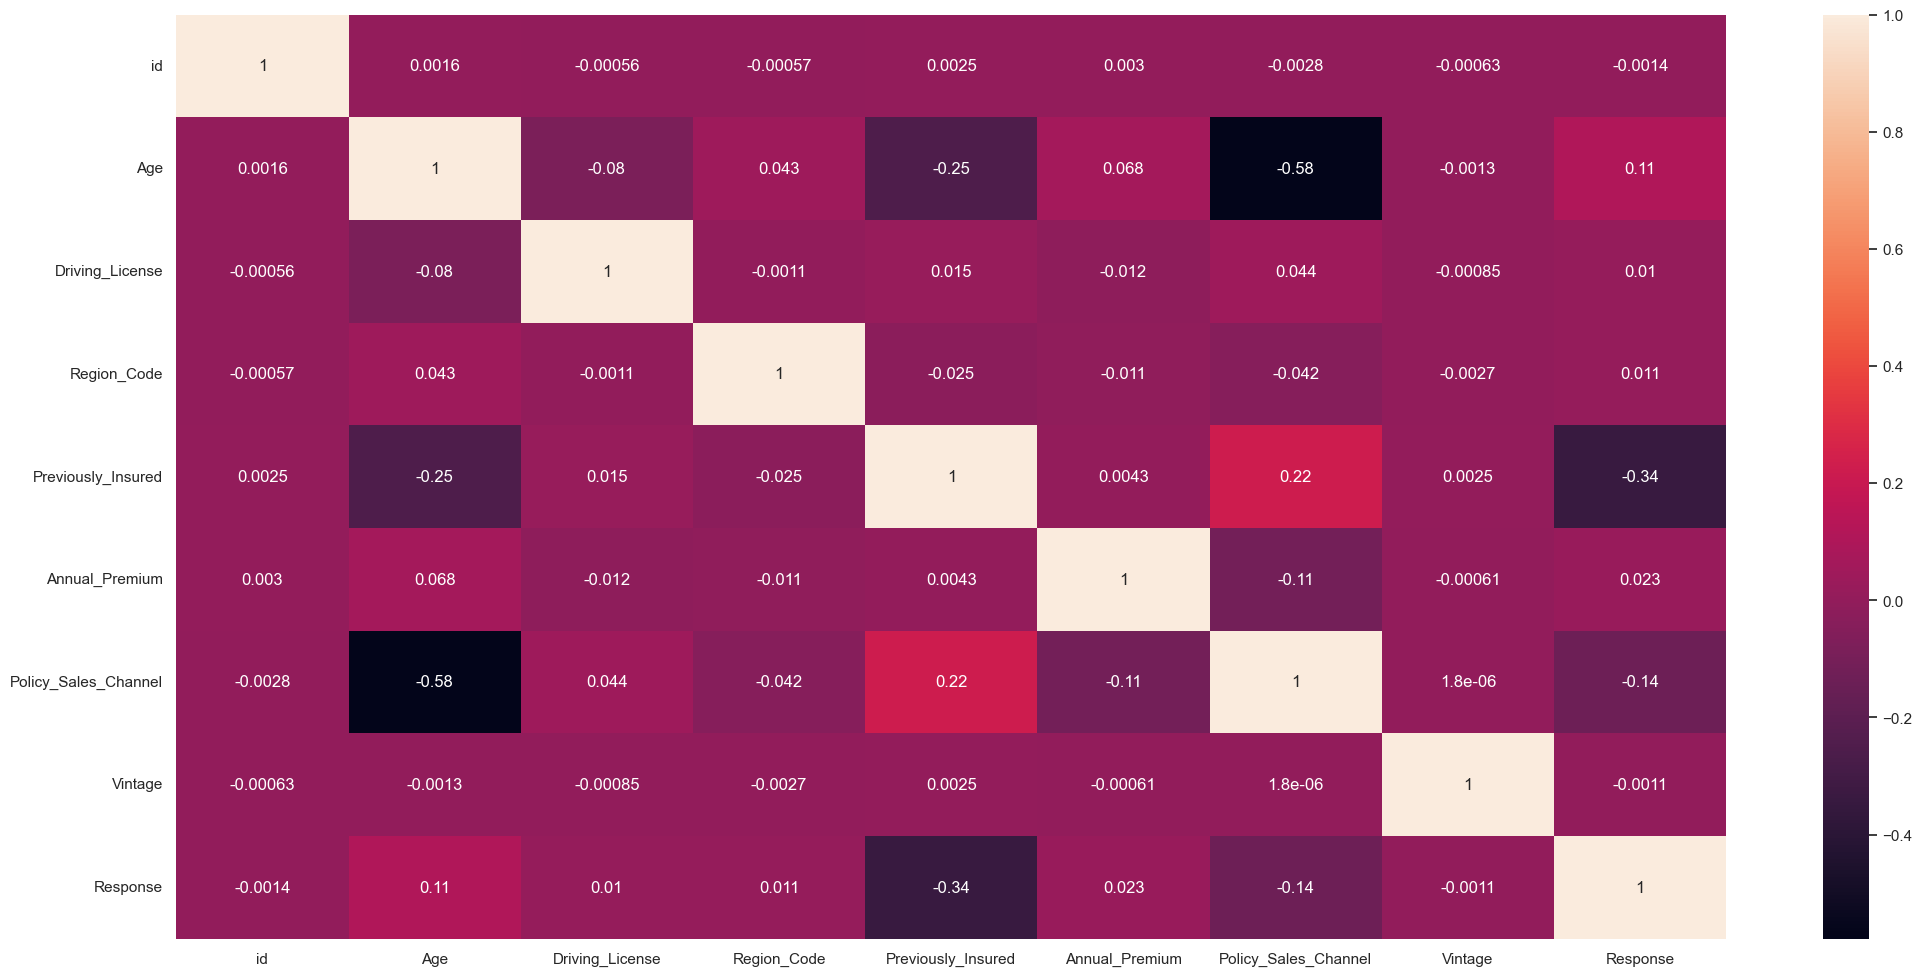

In [138]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.2.2 Categorical attributes

<AxesSubplot:>

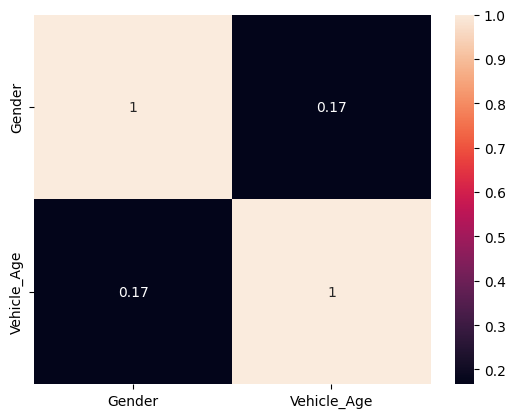

In [46]:
# only categorical data
a = df4.select_dtypes(include='object')

# Calculate cramer V
a1 = cramer_v(a['Gender'], a['Gender'])
a2 = cramer_v(a['Gender'], a['Vehicle_Age'])
a3 = cramer_v(a['Vehicle_Age'], a['Gender'])
a4 = cramer_v(a['Vehicle_Age'], a['Vehicle_Age'])

# Final dataset
d = pd.DataFrame({'Gender': [a1, a2],'Vehicle_Age': [a3, a4]})
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

# 5.0 Data Preparation

In [47]:
df5 = df4.copy()

In [48]:
# Train and test datasets
x = df5.drop('Response', axis=1)
y = df5['Response'].copy()

x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size= 0.20)

df_train = pd.concat([x_train , y_train], axis=1)

# Train and validation dataset
x2 = df_train.drop('Response', axis=1)
y2 = df_train['Response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(x2, y2, test_size= 0.20)

df5 = pd.concat([x_train , y_train], axis=1)

## 5.1 Standardization 

In [49]:
ss = pp.StandardScaler()

#annual_premium (take a array with double [])
df5['Annual_Premium'] = ss.fit_transform(df5[['Annual_Premium']].values)
pickle.dump(ss, open( '../src/features/annual_premium_scaler.pkl', 'wb'))

## 5.2 Rescaling

In [50]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

#age
df5['Age'] = mms_age.fit_transform(df5[['Age']].values)
pickle.dump(mms_age, open('../src/features/age_scaler.pkl', 'wb'))

#vintage
df5['Vintage'] = mms_vintage.fit_transform(df5[['Vintage']].values)
pickle.dump(mms_vintage, open('../src/features/vintage_scaler.pkl', 'wb'))

## 5.3 Encoding

In [51]:
#Gender
target_encode_gender = df5.groupby('Gender')['Response'].mean()
df5.loc[:,'Gender'] = df5['Gender'].map(target_encode_gender)
pickle.dump(target_encode_gender, open('../src/features/target_encode_gender_scaler.pkl', 'wb'))

#Region_Code
target_encode_region_code = df5.groupby('Region_Code')['Response'].mean()
df5.loc[:,'Region_Code'] = df5['Region_Code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open('../src/features/target_encode_region_code_scaler.pkl', 'wb'))

#Policy_Sales_Channel
fe_policy_sales_channel = df5.groupby('Policy_Sales_Channel').size() / len(df5)
df5.loc[:,'Policy_Sales_Channel'] = df5['Policy_Sales_Channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('../src/features/fe_policy_sales_channel_scaler.pkl', 'wb'))

#Vehicle_Age
df5 = pd.get_dummies(df5, prefix='Vehicle_Age', columns=['Vehicle_Age'])

## 5.4 Validation Preparation 

In [52]:
#Age
x_validation['Age'] = mms_age.fit_transform(x_validation[['Age']].values)

#Vintage
x_validation['Vintage'] = mms_vintage.fit_transform(x_validation[['Vintage']].values)

#Gender
x_validation.loc[:,'Gender'] = x_validation['Gender'].map(target_encode_gender)

#Region_Code
x_validation.loc[:,'Region_Code'] = x_validation['Region_Code'].map(target_encode_region_code)

#Policy_Sales_Channel
x_validation.loc[:,'Policy_Sales_Channel'] = x_validation['Policy_Sales_Channel'].map(fe_policy_sales_channel)

#Vehicle_Age
x_validation = pd.get_dummies(x_validation, prefix='Vehicle_Age', columns=['Vehicle_Age'])

#Annual_premium (take a array with double [])
x_validation['Annual_Premium'] = ss.fit_transform(x_validation[['Annual_Premium']].values)

#NA
x_validation = x_validation.fillna(0)

# 6.0 Feature Selection 

## 6.2 Features importance 

In [53]:
#model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

x_train_n = df5.drop(['id', 'Response'], axis=1)
y_train_n = y_train.values
forest.fit (x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking: 
                         feature  importance
0                        Vintage    0.270109
0                 Annual_Premium    0.240200
0                            Age    0.168943
0                    Region_Code    0.107238
0                 Vehicle_Damage    0.070693
0           Policy_Sales_Channel    0.060435
0             Previously_Insured    0.054118
0       Vehicle_Age_below_1_year    0.013780
0  Vehicle_Age_between_1_2_years    0.006621
0                         Gender    0.005013
0       Vehicle_Age_over_2_years    0.002341
0                Driving_License    0.000509


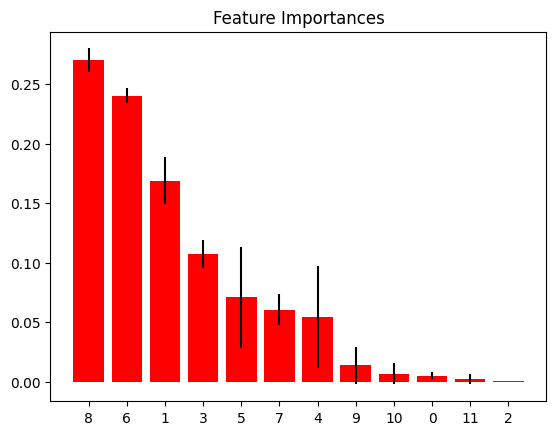

In [60]:
importance = forest.feature_importances_
indices = np.argsort(importance)[::-1]
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

print("Feature ranking: ")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis = 0)

print (df.sort_values('importance', ascending=False))

plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]), importance[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim(-1, x_train_n.shape[1] )
plt.show()

# 7.0 Machine Learning

In [90]:
cols_selected = ['Vintage', 'Annual_Premium', 'Age', 'Region_Code', 'Vehicle_Damage',
                 'Policy_Sales_Channel', 'Previously_Insured']

x_train = df5[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

In [91]:
df7 = x_validation.copy()
df7['Response'] = y_validation.copy()   

## 7.1. KNN  

In [92]:
# model definiton
knn = nh.KNeighborsClassifier(n_neighbors=7)

#model trainning
knn.fit(x_train, y_train)

#model predicition
yhat_knn = knn.predict_proba(x_val)

yhat1_knn = knn.predict(x_val)

## 7.2. Logistic Regression

In [93]:
lr = lm.LogisticRegression(random_state=42)

#model trainning
lr.fit(x_train, y_train)

#model predicition
yhat_lr = lr.predict_proba(x_val)

yhat1_lr = lr.predict(x_val)

## 7.3. Extra Trees

In [94]:
# model definition
et = en.ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=42)

# model fit
et.fit(x_train, y_train)

# model prediction
yhat_et = et.predict_proba(x_val)

yhat1_et = et.predict(x_val)

## 7.4 Random Forest 

In [95]:
 # model definition
rf = en.RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42) 

# model training
rf.fit(x_train, y_train)

# model prediction
yhat_rf = et.predict_proba(x_val)

yhat1_rf = rf.predict(x_val)

## 7.5 XGBoost

In [96]:
# model
xgb = XGBClassifier(n_estimators=100, eta=0.01, max_depth=10)

# model training
xgb.fit(x_train, y_train)

# prediction
yhat_xgb = xgb.predict_proba(x_val)

yhat1_xgb = xgb.predict(x_val)

## 7.6 LGBM

In [97]:
# model 
lgbm = LGBMClassifier()

# model training
lgbm.fit(x_train, y_train)

# prediction
yhat_lgbm = lgbm.predict_proba(x_val)

yhat1_lgbm = lgbm.predict(x_val)

# 8.0 Model Performance

## 8.1 Single performance results

In [98]:
# numerical single performance results
knnr = resultssp(df7, yhat_knn, yhat1_knn, 'KNN', 1000)
lrr = resultssp(df7, yhat_lr, yhat1_lr, 'Logistic Regression', 1000)
etr = resultssp(df7, yhat_et, yhat1_et, 'Extra Trees', 1000)
rfr = resultssp(df7, yhat_rf, yhat1_rf, 'Random Forest', 1000)
xgbr = resultssp(df7, yhat_xgb, yhat1_xgb, 'XGBoost', 1000)
lgbmr = resultssp(df7, yhat_lgbm, yhat1_lgbm,'LGBM', 1000)

#numerical cross validation results
results = pd.concat([knnr, lrr, etr, rfr, xgbr, lgbmr])
results

,Precision @k,Recall @k,Accuracy
KNN,0.347652,0.047295,0.863098
Logistic Regression,0.302697,0.041180,0.879334
Extra Trees,0.345654,0.047024,0.862541
Random Forest,0.345654,0.047024,0.867378
XGBoost,0.451548,0.061430,0.879252
LGBM,0.459540,0.062517,0.879153


## 8.2 Cross validation results

In [99]:
knn_cv = cross_validation('KNN', knn, x_train, y_train, 1000)
lr_cv = cross_validation('Logistic Regression', lr, x_train, y_train, 1000)
et_cv = cross_validation('Extra Trees', et, x_train, y_train, 1000)
rf_cv = cross_validation('Random Forest', rf, x_train, y_train, 1000)
xgb_cv = cross_validation('XGBoost', xgb, x_train, y_train, 1000)
lgbm_cv = cross_validation('LGBM', lgbm, x_train, y_train, 1000)

#numerical cross validation results
cv_results = pd.concat([knn_cv, lr_cv, et_cv, rf_cv, xgb_cv, lgbm_cv])
cv_results

,Precision @k CV,Recall @k CV,Accuracy
KNN,0.342,0.057,0.859
Logistic Regression,0.305,0.051,0.877
Extra Trees,0.332,0.055,0.861
Random Forest,0.357,0.060,0.865
XGBoost,0.416,0.069,0.877
LGBM,0.425,0.071,0.877


## 8.3 Cumulative gain's curve 

In [100]:
knn_cgc = cg_curve(yhat_knn, y_val)
lr_cgc = cg_curve(yhat_lr, y_val)
et_cgc = cg_curve(yhat_et, y_val)
rf_cgc = cg_curve(yhat_rf, y_val)
xgb_cgc = cg_curve(yhat_xgb, y_val)
lgbm_cgc = cg_curve(yhat_lgbm, y_val)

Text(0, 0.5, 'Gain')

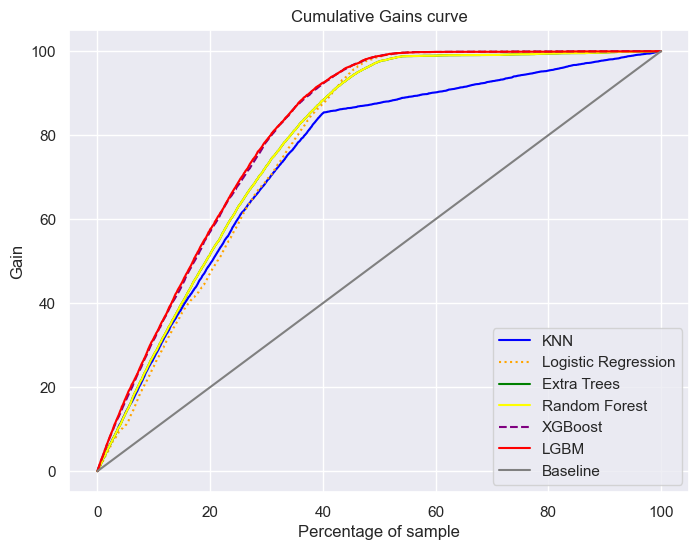

In [158]:
fig, axs = plt.subplots(1, 1, figsize=(8, 6))

# plot data
sns.lineplot(ax=axs, x='base_cum_perc', y='real_cum_perc', data=knn_cgc, label='KNN', linewidth = 1.5, color='blue')
sns.lineplot(ax=axs, x='base_cum_perc', y='real_cum_perc', data=lr_cgc, label='Logistic Regression', linewidth = 1.5, color='orange')
sns.lineplot(ax=axs, x='base_cum_perc', y='real_cum_perc', data=et_cgc, label='Extra Trees', linewidth = 1.5, color='green')
sns.lineplot(ax=axs, x='base_cum_perc', y='real_cum_perc', data=rf_cgc, label='Random Forest', linewidth = 1.5, color='yellow')
sns.lineplot(ax=axs, x='base_cum_perc', y='real_cum_perc', data=xgb_cgc, label='XGBoost', linewidth = 1.5, color='purple')
sns.lineplot(ax=axs, x='base_cum_perc', y='real_cum_perc', data=lgbm_cgc, label='LGBM', linewidth = 1.5, color='red')
sns.lineplot(ax=axs, x='base_cum_perc', y='baseline', data=lgbm_cgc, label='Baseline', linewidth = 1.5, color='gray')

# line styles
axs.lines[1].set_linestyle(":")
axs.lines[4].set_linestyle("--")

# legends
axs.legend()
axs.set_title("Cumulative Gains curve")
axs.set_xlabel("Percentage of sample")
axs.set_ylabel("Gain")

# 7.9 Hyperparameters fine tuning

In [102]:
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import accuracy_score

def objective(trial):

    param = {"objective": "binary", 
             "verbosity": -1, 
             "boosting_type": "gbdt", 
             "num_class": 1,
             "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
             "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
             "num_leaves": trial.suggest_int("num_leaves", 2, 256),
             "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
             "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
             "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
             "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)}

    # model 
    lgbm_modelx = LGBMClassifier(**param)

    # model training
    lgbm_modelx.fit(x_train, y_train)

    # prediction
    yhat_lgbmx = lgbm_modelx.predict(x_val)
    
    acc = accuracy_score(y_val, yhat_lgbmx)
    
    return acc

In [103]:
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2022-11-28 20:28:56,413] A new study created in memory with name: lightgbm


[LightGBM] [Warning] feature_fraction is set=0.5813995435791038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5813995435791038
[LightGBM] [Warning] lambda_l1 is set=5.6649755830282306e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.6649755830282306e-05
[LightGBM] [Warning] bagging_fraction is set=0.48805353449026784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48805353449026784
[LightGBM] [Warning] lambda_l2 is set=0.030403280126677572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.030403280126677572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-28 20:28:57,396] Trial 0 finished with value: 0.8793335301256191 and parameters: {'lambda_l1': 5.6649755830282306e-05, 'lambda_l2': 0.030403280126677572, 'num_leaves': 2, 'feature_fraction': 0.5813995435791038, 'bagging_fraction': 0.48805353449026784, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 0 with value: 0.8793335301256191.


[LightGBM] [Warning] feature_fraction is set=0.6515167086419769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6515167086419769
[LightGBM] [Warning] lambda_l1 is set=1.2883876209377052e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2883876209377052e-05
[LightGBM] [Warning] bagging_fraction is set=0.8111317002380557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8111317002380557
[LightGBM] [Warning] lambda_l2 is set=3.72312200494449e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.72312200494449e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-11-28 20:28:59,172] Trial 1 finished with value: 0.8792679326970383 and parameters: {'lambda_l1': 1.2883876209377052e-05, 'lambda_l2': 3.72312200494449e-05, 'num_leaves': 139, 'feature_fraction': 0.6515167086419769, 'bagging_fraction': 0.8111317002380557, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 0 with value: 0.8793335301256191.


[LightGBM] [Warning] feature_fraction is set=0.735213897067451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.735213897067451
[LightGBM] [Warning] lambda_l1 is set=1.763958399884789e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.763958399884789e-08
[LightGBM] [Warning] bagging_fraction is set=0.4842321631571403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4842321631571403
[LightGBM] [Warning] lambda_l2 is set=0.010819509974097813, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010819509974097813
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-11-28 20:29:00,326] Trial 2 finished with value: 0.8792187346256026 and parameters: {'lambda_l1': 1.763958399884789e-08, 'lambda_l2': 0.010819509974097813, 'num_leaves': 108, 'feature_fraction': 0.735213897067451, 'bagging_fraction': 0.4842321631571403, 'bagging_freq': 2, 'min_child_samples': 81}. Best is trial 0 with value: 0.8793335301256191.


[LightGBM] [Warning] feature_fraction is set=0.9258334913776229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9258334913776229
[LightGBM] [Warning] lambda_l1 is set=5.180291295699627, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.180291295699627
[LightGBM] [Warning] bagging_fraction is set=0.9367639981023084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9367639981023084
[LightGBM] [Warning] lambda_l2 is set=6.6193844201488494e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.6193844201488494e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-28 20:29:01,690] Trial 3 finished with value: 0.8790219423398603 and parameters: {'lambda_l1': 5.180291295699627, 'lambda_l2': 6.6193844201488494e-06, 'num_leaves': 178, 'feature_fraction': 0.9258334913776229, 'bagging_fraction': 0.9367639981023084, 'bagging_freq': 1, 'min_child_samples': 8}. Best is trial 0 with value: 0.8793335301256191.


[LightGBM] [Warning] feature_fraction is set=0.6526645750030313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6526645750030313
[LightGBM] [Warning] lambda_l1 is set=3.376554594427989e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.376554594427989e-07
[LightGBM] [Warning] bagging_fraction is set=0.9747337180903012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9747337180903012
[LightGBM] [Warning] lambda_l2 is set=0.8003547575557912, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8003547575557912
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-28 20:29:02,739] Trial 4 finished with value: 0.8792843320541834 and parameters: {'lambda_l1': 3.376554594427989e-07, 'lambda_l2': 0.8003547575557912, 'num_leaves': 27, 'feature_fraction': 0.6526645750030313, 'bagging_fraction': 0.9747337180903012, 'bagging_freq': 4, 'min_child_samples': 71}. Best is trial 0 with value: 0.8793335301256191.


[LightGBM] [Warning] feature_fraction is set=0.4109729664065151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4109729664065151
[LightGBM] [Warning] lambda_l1 is set=6.912588094940543e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.912588094940543e-06
[LightGBM] [Warning] bagging_fraction is set=0.8500865889669804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8500865889669804
[LightGBM] [Warning] lambda_l2 is set=0.015083716080906013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015083716080906013
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-28 20:29:04,285] Trial 5 finished with value: 0.8789399455541342 and parameters: {'lambda_l1': 6.912588094940543e-06, 'lambda_l2': 0.015083716080906013, 'num_leaves': 214, 'feature_fraction': 0.4109729664065151, 'bagging_fraction': 0.8500865889669804, 'bagging_freq': 7, 'min_child_samples': 76}. Best is trial 0 with value: 0.8793335301256191.


[LightGBM] [Warning] feature_fraction is set=0.6687361157055431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6687361157055431
[LightGBM] [Warning] lambda_l1 is set=3.341919070318744e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.341919070318744e-06
[LightGBM] [Warning] bagging_fraction is set=0.9451573018558573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9451573018558573
[LightGBM] [Warning] lambda_l2 is set=0.12691529280491062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12691529280491062
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-28 20:29:05,165] Trial 6 finished with value: 0.8793663288399095 and parameters: {'lambda_l1': 3.341919070318744e-06, 'lambda_l2': 0.12691529280491062, 'num_leaves': 28, 'feature_fraction': 0.6687361157055431, 'bagging_fraction': 0.9451573018558573, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 6 with value: 0.8793663288399095.


[LightGBM] [Warning] feature_fraction is set=0.5269768696000354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5269768696000354
[LightGBM] [Warning] lambda_l1 is set=1.4799844388224288e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4799844388224288e-07
[LightGBM] [Warning] bagging_fraction is set=0.5593279956233357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5593279956233357
[LightGBM] [Warning] lambda_l2 is set=1.493834966470408e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.493834966470408e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-28 20:29:06,416] Trial 7 finished with value: 0.8783003706254715 and parameters: {'lambda_l1': 1.4799844388224288e-07, 'lambda_l2': 1.493834966470408e-08, 'num_leaves': 175, 'feature_fraction': 0.5269768696000354, 'bagging_fraction': 0.5593279956233357, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 6 with value: 0.8793663288399095.


[LightGBM] [Warning] feature_fraction is set=0.8198550160125587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8198550160125587
[LightGBM] [Warning] lambda_l1 is set=0.0014691239860705116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014691239860705116
[LightGBM] [Warning] bagging_fraction is set=0.46140065729669555, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46140065729669555
[LightGBM] [Warning] lambda_l2 is set=2.091978294467618e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.091978294467618e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-28 20:29:07,765] Trial 8 finished with value: 0.8778739873396962 and parameters: {'lambda_l1': 0.0014691239860705116, 'lambda_l2': 2.091978294467618e-07, 'num_leaves': 152, 'feature_fraction': 0.8198550160125587, 'bagging_fraction': 0.46140065729669555, 'bagging_freq': 3, 'min_child_samples': 71}. Best is trial 6 with value: 0.8793663288399095.


[LightGBM] [Warning] feature_fraction is set=0.7982767871318732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7982767871318732
[LightGBM] [Warning] lambda_l1 is set=5.340887446119036e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.340887446119036e-05
[LightGBM] [Warning] bagging_fraction is set=0.7089334672349852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7089334672349852
[LightGBM] [Warning] lambda_l2 is set=2.8156659603215856e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8156659603215856e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-28 20:29:09,042] Trial 9 finished with value: 0.8787759519826823 and parameters: {'lambda_l1': 5.340887446119036e-05, 'lambda_l2': 2.8156659603215856e-08, 'num_leaves': 138, 'feature_fraction': 0.7982767871318732, 'bagging_fraction': 0.7089334672349852, 'bagging_freq': 7, 'min_child_samples': 61}. Best is trial 6 with value: 0.8793663288399095.


[LightGBM] [Warning] feature_fraction is set=0.992593709070849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.992593709070849
[LightGBM] [Warning] lambda_l1 is set=0.014637077659197232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014637077659197232
[LightGBM] [Warning] bagging_fraction is set=0.6502118174790948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6502118174790948
[LightGBM] [Warning] lambda_l2 is set=5.895772364703044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.895772364703044
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:29:10,360] Trial 10 finished with value: 0.8790875397684411 and parameters: {'lambda_l1': 0.014637077659197232, 'lambda_l2': 5.895772364703044, 'num_leaves': 66, 'feature_fraction': 0.992593709070849, 'bagging_fraction': 0.6502118174790948, 'bagging_freq': 5, 'min_child_samples': 40}. Best is trial 6 with value: 0.8793663288399095.


[LightGBM] [Warning] feature_fraction is set=0.5518092405170382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5518092405170382
[LightGBM] [Warning] lambda_l1 is set=0.0048248079800825685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0048248079800825685
[LightGBM] [Warning] bagging_fraction is set=0.40197855416358985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40197855416358985
[LightGBM] [Warning] lambda_l2 is set=0.010693784499709258, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010693784499709258
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-28 20:29:11,070] Trial 11 finished with value: 0.8793335301256191 and parameters: {'lambda_l1': 0.0048248079800825685, 'lambda_l2': 0.010693784499709258, 'num_leaves': 6, 'feature_fraction': 0.5518092405170382, 'bagging_fraction': 0.40197855416358985, 'bagging_freq': 1, 'min_child_samples': 32}. Best is trial 6 with value: 0.8793663288399095.


[LightGBM] [Warning] feature_fraction is set=0.5495868330884492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5495868330884492
[LightGBM] [Warning] lambda_l1 is set=1.352708943220955e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.352708943220955e-06
[LightGBM] [Warning] bagging_fraction is set=0.6618971627988041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6618971627988041
[LightGBM] [Warning] lambda_l2 is set=0.2158259345877158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2158259345877158
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-28 20:29:12,066] Trial 12 finished with value: 0.8793991275541999 and parameters: {'lambda_l1': 1.352708943220955e-06, 'lambda_l2': 0.2158259345877158, 'num_leaves': 65, 'feature_fraction': 0.5495868330884492, 'bagging_fraction': 0.6618971627988041, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 12 with value: 0.8793991275541999.


[LightGBM] [Warning] feature_fraction is set=0.4484615677088858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4484615677088858
[LightGBM] [Warning] lambda_l1 is set=1.5587247629063676e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5587247629063676e-06
[LightGBM] [Warning] bagging_fraction is set=0.697257825828693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.697257825828693
[LightGBM] [Warning] lambda_l2 is set=0.616277057753002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.616277057753002
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:29:13,184] Trial 13 finished with value: 0.8795795204827971 and parameters: {'lambda_l1': 1.5587247629063676e-06, 'lambda_l2': 0.616277057753002, 'num_leaves': 71, 'feature_fraction': 0.4484615677088858, 'bagging_fraction': 0.697257825828693, 'bagging_freq': 5, 'min_child_samples': 44}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.4036549391603094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4036549391603094
[LightGBM] [Warning] lambda_l1 is set=3.863194772874239e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.863194772874239e-07
[LightGBM] [Warning] bagging_fraction is set=0.6744707908962592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6744707908962592
[LightGBM] [Warning] lambda_l2 is set=0.0003914443177798934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003914443177798934
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:29:14,591] Trial 14 finished with value: 0.8791531371970219 and parameters: {'lambda_l1': 3.863194772874239e-07, 'lambda_l2': 0.0003914443177798934, 'num_leaves': 77, 'feature_fraction': 0.4036549391603094, 'bagging_fraction': 0.6744707908962592, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.4771633402346971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4771633402346971
[LightGBM] [Warning] lambda_l1 is set=1.6890164692473357e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6890164692473357e-08
[LightGBM] [Warning] bagging_fraction is set=0.7338102321043342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7338102321043342
[LightGBM] [Warning] lambda_l2 is set=6.306473321909725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.306473321909725
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:29:15,707] Trial 15 finished with value: 0.8793171307684738 and parameters: {'lambda_l1': 1.6890164692473357e-08, 'lambda_l2': 6.306473321909725, 'num_leaves': 87, 'feature_fraction': 0.4771633402346971, 'bagging_fraction': 0.7338102321043342, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.4699287768352549, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4699287768352549
[LightGBM] [Warning] lambda_l1 is set=0.4160822459679805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4160822459679805
[LightGBM] [Warning] bagging_fraction is set=0.5965063284688731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5965063284688731
[LightGBM] [Warning] lambda_l2 is set=0.0006700324681833719, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006700324681833719
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:29:16,670] Trial 16 finished with value: 0.8792023352684575 and parameters: {'lambda_l1': 0.4160822459679805, 'lambda_l2': 0.0006700324681833719, 'num_leaves': 53, 'feature_fraction': 0.4699287768352549, 'bagging_fraction': 0.5965063284688731, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.5900220218922028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5900220218922028
[LightGBM] [Warning] lambda_l1 is set=1.260009882426279e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.260009882426279e-06
[LightGBM] [Warning] bagging_fraction is set=0.7945451608621714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945451608621714
[LightGBM] [Warning] lambda_l2 is set=0.45055829703366007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.45055829703366007
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-28 20:29:17,809] Trial 17 finished with value: 0.8793991275541999 and parameters: {'lambda_l1': 1.260009882426279e-06, 'lambda_l2': 0.45055829703366007, 'num_leaves': 91, 'feature_fraction': 0.5900220218922028, 'bagging_fraction': 0.7945451608621714, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.47800698042511414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47800698042511414
[LightGBM] [Warning] lambda_l1 is set=0.00023622788256618245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00023622788256618245
[LightGBM] [Warning] bagging_fraction is set=0.8069672197465471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8069672197465471
[LightGBM] [Warning] lambda_l2 is set=1.2027558226048998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2027558226048998
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:29:19,059] Trial 18 finished with value: 0.8793663288399095 and parameters: {'lambda_l1': 0.00023622788256618245, 'lambda_l2': 1.2027558226048998, 'num_leaves': 104, 'feature_fraction': 0.47800698042511414, 'bagging_fraction': 0.8069672197465471, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.5126463734066204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5126463734066204
[LightGBM] [Warning] lambda_l1 is set=1.0127530701910748e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0127530701910748e-07
[LightGBM] [Warning] bagging_fraction is set=0.6053344184215618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6053344184215618
[LightGBM] [Warning] lambda_l2 is set=0.0011442015684453935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011442015684453935
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-28 20:29:20,089] Trial 19 finished with value: 0.8792351339827479 and parameters: {'lambda_l1': 1.0127530701910748e-07, 'lambda_l2': 0.0011442015684453935, 'num_leaves': 44, 'feature_fraction': 0.5126463734066204, 'bagging_fraction': 0.6053344184215618, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.5893187108062113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5893187108062113
[LightGBM] [Warning] lambda_l1 is set=0.07807726393930005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07807726393930005
[LightGBM] [Warning] bagging_fraction is set=0.8726237894035704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8726237894035704
[LightGBM] [Warning] lambda_l2 is set=3.521432335456682e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.521432335456682e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:29:21,288] Trial 20 finished with value: 0.8792351339827479 and parameters: {'lambda_l1': 0.07807726393930005, 'lambda_l2': 3.521432335456682e-05, 'num_leaves': 109, 'feature_fraction': 0.5893187108062113, 'bagging_fraction': 0.8726237894035704, 'bagging_freq': 6, 'min_child_samples': 54}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.5960802879297971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5960802879297971
[LightGBM] [Warning] lambda_l1 is set=7.931850723206403e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.931850723206403e-07
[LightGBM] [Warning] bagging_fraction is set=0.7490329208188214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7490329208188214
[LightGBM] [Warning] lambda_l2 is set=0.25523756054867747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.25523756054867747
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-28 20:29:22,456] Trial 21 finished with value: 0.8791367378398767 and parameters: {'lambda_l1': 7.931850723206403e-07, 'lambda_l2': 0.25523756054867747, 'num_leaves': 88, 'feature_fraction': 0.5960802879297971, 'bagging_fraction': 0.7490329208188214, 'bagging_freq': 3, 'min_child_samples': 19}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.7255167115212494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7255167115212494
[LightGBM] [Warning] lambda_l1 is set=2.0016815591572584e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0016815591572584e-06
[LightGBM] [Warning] bagging_fraction is set=0.7630788058676393, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7630788058676393
[LightGBM] [Warning] lambda_l2 is set=0.09349168668584436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09349168668584436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-11-28 20:29:24,418] Trial 22 finished with value: 0.8788087506969727 and parameters: {'lambda_l1': 2.0016815591572584e-06, 'lambda_l2': 0.09349168668584436, 'num_leaves': 246, 'feature_fraction': 0.7255167115212494, 'bagging_fraction': 0.7630788058676393, 'bagging_freq': 2, 'min_child_samples': 43}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.4415265665789849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4415265665789849
[LightGBM] [Warning] lambda_l1 is set=2.9523676493431712e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9523676493431712e-05
[LightGBM] [Warning] bagging_fraction is set=0.6321407314026206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6321407314026206
[LightGBM] [Warning] lambda_l2 is set=1.2069594254972744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2069594254972744
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-28 20:29:25,517] Trial 23 finished with value: 0.8792187346256026 and parameters: {'lambda_l1': 2.9523676493431712e-05, 'lambda_l2': 1.2069594254972744, 'num_leaves': 51, 'feature_fraction': 0.4415265665789849, 'bagging_fraction': 0.6321407314026206, 'bagging_freq': 3, 'min_child_samples': 31}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.6168958658834076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6168958658834076
[LightGBM] [Warning] lambda_l1 is set=1.7600384172050716e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7600384172050716e-06
[LightGBM] [Warning] bagging_fraction is set=0.6845754310451609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6845754310451609
[LightGBM] [Warning] lambda_l2 is set=0.0029464112314325024, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0029464112314325024
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-28 20:29:27,027] Trial 24 finished with value: 0.8789563449112795 and parameters: {'lambda_l1': 1.7600384172050716e-06, 'lambda_l2': 0.0029464112314325024, 'num_leaves': 118, 'feature_fraction': 0.6168958658834076, 'bagging_fraction': 0.6845754310451609, 'bagging_freq': 4, 'min_child_samples': 62}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.5119376824684981, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5119376824684981
[LightGBM] [Warning] lambda_l1 is set=0.000296782573051371, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000296782573051371
[LightGBM] [Warning] bagging_fraction is set=0.555773801981778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.555773801981778
[LightGBM] [Warning] lambda_l2 is set=0.3604519022434771, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3604519022434771
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-11-28 20:29:28,338] Trial 25 finished with value: 0.8792023352684575 and parameters: {'lambda_l1': 0.000296782573051371, 'lambda_l2': 0.3604519022434771, 'num_leaves': 76, 'feature_fraction': 0.5119376824684981, 'bagging_fraction': 0.555773801981778, 'bagging_freq': 2, 'min_child_samples': 97}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.5491524869395557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5491524869395557
[LightGBM] [Warning] lambda_l1 is set=5.2843345721470364e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.2843345721470364e-08
[LightGBM] [Warning] bagging_fraction is set=0.7938205289761499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7938205289761499
[LightGBM] [Warning] lambda_l2 is set=7.155710519291064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.155710519291064
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:29:29,538] Trial 26 finished with value: 0.8793499294827642 and parameters: {'lambda_l1': 5.2843345721470364e-08, 'lambda_l2': 7.155710519291064, 'num_leaves': 30, 'feature_fraction': 0.5491524869395557, 'bagging_fraction': 0.7938205289761499, 'bagging_freq': 5, 'min_child_samples': 49}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.44455819133873276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44455819133873276
[LightGBM] [Warning] lambda_l1 is set=1.1909423863726074e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1909423863726074e-05
[LightGBM] [Warning] bagging_fraction is set=0.88058340663478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.88058340663478
[LightGBM] [Warning] lambda_l2 is set=0.059991388178333625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.059991388178333625
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-28 20:29:31,051] Trial 27 finished with value: 0.8792843320541834 and parameters: {'lambda_l1': 1.1909423863726074e-05, 'lambda_l2': 0.059991388178333625, 'num_leaves': 97, 'feature_fraction': 0.44455819133873276, 'bagging_fraction': 0.88058340663478, 'bagging_freq': 3, 'min_child_samples': 36}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.6244682568639168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6244682568639168
[LightGBM] [Warning] lambda_l1 is set=6.942399961964369e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.942399961964369e-07
[LightGBM] [Warning] bagging_fraction is set=0.70942419164383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.70942419164383
[LightGBM] [Warning] lambda_l2 is set=0.003747556427366342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003747556427366342
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-28 20:29:32,294] Trial 28 finished with value: 0.8788743481255534 and parameters: {'lambda_l1': 6.942399961964369e-07, 'lambda_l2': 0.003747556427366342, 'num_leaves': 124, 'feature_fraction': 0.6244682568639168, 'bagging_fraction': 0.70942419164383, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.5612995862443141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5612995862443141
[LightGBM] [Warning] lambda_l1 is set=9.852285159524673e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.852285159524673e-05
[LightGBM] [Warning] bagging_fraction is set=0.5324237332602508, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5324237332602508
[LightGBM] [Warning] lambda_l2 is set=0.04526762707047801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04526762707047801
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-28 20:29:33,364] Trial 29 finished with value: 0.8791695365541671 and parameters: {'lambda_l1': 9.852285159524673e-05, 'lambda_l2': 0.04526762707047801, 'num_leaves': 58, 'feature_fraction': 0.5612995862443141, 'bagging_fraction': 0.5324237332602508, 'bagging_freq': 3, 'min_child_samples': 27}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.6942584135496153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6942584135496153
[LightGBM] [Warning] lambda_l1 is set=3.1734797268287393e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1734797268287393e-08
[LightGBM] [Warning] bagging_fraction is set=0.6389819921085749, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6389819921085749
[LightGBM] [Warning] lambda_l2 is set=2.2515577955803066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2515577955803066
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-28 20:29:34,404] Trial 30 finished with value: 0.8793335301256191 and parameters: {'lambda_l1': 3.1734797268287393e-08, 'lambda_l2': 2.2515577955803066, 'num_leaves': 11, 'feature_fraction': 0.6942584135496153, 'bagging_fraction': 0.6389819921085749, 'bagging_freq': 4, 'min_child_samples': 54}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.48730359520289107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48730359520289107
[LightGBM] [Warning] lambda_l1 is set=0.0004401966141694458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004401966141694458
[LightGBM] [Warning] bagging_fraction is set=0.8083189708611378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8083189708611378
[LightGBM] [Warning] lambda_l2 is set=0.8596185989545481, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8596185989545481
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:29:35,960] Trial 31 finished with value: 0.8793663288399095 and parameters: {'lambda_l1': 0.0004401966141694458, 'lambda_l2': 0.8596185989545481, 'num_leaves': 96, 'feature_fraction': 0.48730359520289107, 'bagging_fraction': 0.8083189708611378, 'bagging_freq': 6, 'min_child_samples': 61}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.5079168866921648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5079168866921648
[LightGBM] [Warning] lambda_l1 is set=2.9911896092968476e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9911896092968476e-05
[LightGBM] [Warning] bagging_fraction is set=0.7767752400535222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7767752400535222
[LightGBM] [Warning] lambda_l2 is set=0.30111866699391804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30111866699391804
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:29:37,301] Trial 32 finished with value: 0.8793991275541999 and parameters: {'lambda_l1': 2.9911896092968476e-05, 'lambda_l2': 0.30111866699391804, 'num_leaves': 81, 'feature_fraction': 0.5079168866921648, 'bagging_fraction': 0.7767752400535222, 'bagging_freq': 6, 'min_child_samples': 69}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.5246611457065073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5246611457065073
[LightGBM] [Warning] lambda_l1 is set=2.2650553602870504e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2650553602870504e-05
[LightGBM] [Warning] bagging_fraction is set=0.7770707839309605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7770707839309605
[LightGBM] [Warning] lambda_l2 is set=0.2695087411173047, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2695087411173047
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:29:38,442] Trial 33 finished with value: 0.8795631211256518 and parameters: {'lambda_l1': 2.2650553602870504e-05, 'lambda_l2': 0.2695087411173047, 'num_leaves': 66, 'feature_fraction': 0.5246611457065073, 'bagging_fraction': 0.7770707839309605, 'bagging_freq': 5, 'min_child_samples': 82}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.432752143395487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.432752143395487
[LightGBM] [Warning] lambda_l1 is set=2.2028813846329673e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2028813846329673e-05
[LightGBM] [Warning] bagging_fraction is set=0.8333141975040512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8333141975040512
[LightGBM] [Warning] lambda_l2 is set=0.0265847383148729, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0265847383148729
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:29:39,665] Trial 34 finished with value: 0.8795303224113614 and parameters: {'lambda_l1': 2.2028813846329673e-05, 'lambda_l2': 0.0265847383148729, 'num_leaves': 77, 'feature_fraction': 0.432752143395487, 'bagging_fraction': 0.8333141975040512, 'bagging_freq': 5, 'min_child_samples': 87}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.4418984103859504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4418984103859504
[LightGBM] [Warning] lambda_l1 is set=1.4154662550158068e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4154662550158068e-05
[LightGBM] [Warning] bagging_fraction is set=0.8371280360855751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8371280360855751
[LightGBM] [Warning] lambda_l2 is set=0.02209425099750031, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02209425099750031
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:29:40,750] Trial 35 finished with value: 0.8793499294827642 and parameters: {'lambda_l1': 1.4154662550158068e-05, 'lambda_l2': 0.02209425099750031, 'num_leaves': 38, 'feature_fraction': 0.4418984103859504, 'bagging_fraction': 0.8371280360855751, 'bagging_freq': 5, 'min_child_samples': 90}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.4309393430671008, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4309393430671008
[LightGBM] [Warning] lambda_l1 is set=4.473131590963921e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.473131590963921e-06
[LightGBM] [Warning] bagging_fraction is set=0.8639455331889858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8639455331889858
[LightGBM] [Warning] lambda_l2 is set=0.005689032263202435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005689032263202435
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:29:41,850] Trial 36 finished with value: 0.8795139230542163 and parameters: {'lambda_l1': 4.473131590963921e-06, 'lambda_l2': 0.005689032263202435, 'num_leaves': 64, 'feature_fraction': 0.4309393430671008, 'bagging_fraction': 0.8639455331889858, 'bagging_freq': 5, 'min_child_samples': 84}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.40101129385879386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40101129385879386
[LightGBM] [Warning] lambda_l1 is set=3.7834833827727515e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7834833827727515e-06
[LightGBM] [Warning] bagging_fraction is set=0.9138456205327993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9138456205327993
[LightGBM] [Warning] lambda_l2 is set=6.304775380538386e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.304775380538386e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:29:42,811] Trial 37 finished with value: 0.8793991275541999 and parameters: {'lambda_l1': 3.7834833827727515e-06, 'lambda_l2': 6.304775380538386e-05, 'num_leaves': 15, 'feature_fraction': 0.40101129385879386, 'bagging_fraction': 0.9138456205327993, 'bagging_freq': 5, 'min_child_samples': 84}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.4455663235450366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4455663235450366
[LightGBM] [Warning] lambda_l1 is set=0.0001200165707002022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001200165707002022
[LightGBM] [Warning] bagging_fraction is set=0.9893175195012831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9893175195012831
[LightGBM] [Warning] lambda_l2 is set=0.008872685172526085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008872685172526085
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:29:43,976] Trial 38 finished with value: 0.8794811243399259 and parameters: {'lambda_l1': 0.0001200165707002022, 'lambda_l2': 0.008872685172526085, 'num_leaves': 67, 'feature_fraction': 0.4455663235450366, 'bagging_fraction': 0.9893175195012831, 'bagging_freq': 5, 'min_child_samples': 80}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.43190302077656734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43190302077656734
[LightGBM] [Warning] lambda_l1 is set=0.0010252018801567963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010252018801567963
[LightGBM] [Warning] bagging_fraction is set=0.8408049609891428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8408049609891428
[LightGBM] [Warning] lambda_l2 is set=0.00012332247299820423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012332247299820423
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:29:44,987] Trial 39 finished with value: 0.8794319262684903 and parameters: {'lambda_l1': 0.0010252018801567963, 'lambda_l2': 0.00012332247299820423, 'num_leaves': 35, 'feature_fraction': 0.43190302077656734, 'bagging_fraction': 0.8408049609891428, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.8371395109892983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8371395109892983
[LightGBM] [Warning] lambda_l1 is set=8.531357877588189e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.531357877588189e-06
[LightGBM] [Warning] bagging_fraction is set=0.9049669374505913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9049669374505913
[LightGBM] [Warning] lambda_l2 is set=0.003421089777817264, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003421089777817264
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-28 20:29:46,892] Trial 40 finished with value: 0.8789399455541342 and parameters: {'lambda_l1': 8.531357877588189e-06, 'lambda_l2': 0.003421089777817264, 'num_leaves': 155, 'feature_fraction': 0.8371395109892983, 'bagging_fraction': 0.9049669374505913, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.4548149952925805, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4548149952925805
[LightGBM] [Warning] lambda_l1 is set=0.00011112987292115006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011112987292115006
[LightGBM] [Warning] bagging_fraction is set=0.9882071238165756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9882071238165756
[LightGBM] [Warning] lambda_l2 is set=0.01454629658281154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01454629658281154
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:29:48,025] Trial 41 finished with value: 0.8794319262684903 and parameters: {'lambda_l1': 0.00011112987292115006, 'lambda_l2': 0.01454629658281154, 'num_leaves': 68, 'feature_fraction': 0.4548149952925805, 'bagging_fraction': 0.9882071238165756, 'bagging_freq': 5, 'min_child_samples': 80}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.42020403800318434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42020403800318434
[LightGBM] [Warning] lambda_l1 is set=2.5405936778148642e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5405936778148642e-05
[LightGBM] [Warning] bagging_fraction is set=0.9381210658154016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9381210658154016
[LightGBM] [Warning] lambda_l2 is set=0.008784907159762994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008784907159762994
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:29:49,069] Trial 42 finished with value: 0.8795139230542163 and parameters: {'lambda_l1': 2.5405936778148642e-05, 'lambda_l2': 0.008784907159762994, 'num_leaves': 47, 'feature_fraction': 0.42020403800318434, 'bagging_fraction': 0.9381210658154016, 'bagging_freq': 5, 'min_child_samples': 87}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.4193906826832594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4193906826832594
[LightGBM] [Warning] lambda_l1 is set=3.0175086011085076e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0175086011085076e-05
[LightGBM] [Warning] bagging_fraction is set=0.9433524531444457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9433524531444457
[LightGBM] [Warning] lambda_l2 is set=0.04259372552000539, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04259372552000539
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:29:50,029] Trial 43 finished with value: 0.8793499294827642 and parameters: {'lambda_l1': 3.0175086011085076e-05, 'lambda_l2': 0.04259372552000539, 'num_leaves': 20, 'feature_fraction': 0.4193906826832594, 'bagging_fraction': 0.9433524531444457, 'bagging_freq': 5, 'min_child_samples': 86}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.4009632172772189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4009632172772189
[LightGBM] [Warning] lambda_l1 is set=6.38345359485224e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.38345359485224e-06
[LightGBM] [Warning] bagging_fraction is set=0.8732174302085879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8732174302085879
[LightGBM] [Warning] lambda_l2 is set=0.08231936901926823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08231936901926823
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-28 20:29:51,104] Trial 44 finished with value: 0.8793171307684738 and parameters: {'lambda_l1': 6.38345359485224e-06, 'lambda_l2': 0.08231936901926823, 'num_leaves': 45, 'feature_fraction': 0.4009632172772189, 'bagging_fraction': 0.8732174302085879, 'bagging_freq': 4, 'min_child_samples': 91}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.4903260238521679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4903260238521679
[LightGBM] [Warning] lambda_l1 is set=2.4517545154974645e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4517545154974645e-07
[LightGBM] [Warning] bagging_fraction is set=0.9099023841708997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9099023841708997
[LightGBM] [Warning] lambda_l2 is set=0.0014095805552119308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014095805552119308
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:29:52,202] Trial 45 finished with value: 0.8794155269113451 and parameters: {'lambda_l1': 2.4517545154974645e-07, 'lambda_l2': 0.0014095805552119308, 'num_leaves': 56, 'feature_fraction': 0.4903260238521679, 'bagging_fraction': 0.9099023841708997, 'bagging_freq': 5, 'min_child_samples': 76}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.4667576416899267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4667576416899267
[LightGBM] [Warning] lambda_l1 is set=5.024741403111419e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.024741403111419e-06
[LightGBM] [Warning] bagging_fraction is set=0.8300874976015938, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8300874976015938
[LightGBM] [Warning] lambda_l2 is set=0.006061321296303547, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006061321296303547
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-28 20:29:53,440] Trial 46 finished with value: 0.8794975236970711 and parameters: {'lambda_l1': 5.024741403111419e-06, 'lambda_l2': 0.006061321296303547, 'num_leaves': 74, 'feature_fraction': 0.4667576416899267, 'bagging_fraction': 0.8300874976015938, 'bagging_freq': 4, 'min_child_samples': 74}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.4204344503288583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4204344503288583
[LightGBM] [Warning] lambda_l1 is set=1.7998383136902446e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7998383136902446e-05
[LightGBM] [Warning] bagging_fraction is set=0.7271887646275806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7271887646275806
[LightGBM] [Warning] lambda_l2 is set=1.159008257488278e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.159008257488278e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:29:54,634] Trial 47 finished with value: 0.8793991275541999 and parameters: {'lambda_l1': 1.7998383136902446e-05, 'lambda_l2': 1.159008257488278e-05, 'num_leaves': 111, 'feature_fraction': 0.4204344503288583, 'bagging_fraction': 0.7271887646275806, 'bagging_freq': 6, 'min_child_samples': 67}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.532443353868593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.532443353868593
[LightGBM] [Warning] lambda_l1 is set=6.203798355118112, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.203798355118112
[LightGBM] [Warning] bagging_fraction is set=0.9491557817232031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9491557817232031
[LightGBM] [Warning] lambda_l2 is set=9.238409216223383e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.238409216223383e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:29:55,579] Trial 48 finished with value: 0.8793007314113287 and parameters: {'lambda_l1': 6.203798355118112, 'lambda_l2': 9.238409216223383e-07, 'num_leaves': 24, 'feature_fraction': 0.532443353868593, 'bagging_fraction': 0.9491557817232031, 'bagging_freq': 5, 'min_child_samples': 86}. Best is trial 13 with value: 0.8795795204827971.


[LightGBM] [Warning] feature_fraction is set=0.49489347160909386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49489347160909386
[LightGBM] [Warning] lambda_l1 is set=0.002898620915852414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002898620915852414
[LightGBM] [Warning] bagging_fraction is set=0.8883844651693874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8883844651693874
[LightGBM] [Warning] lambda_l2 is set=2.58346478913732, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.58346478913732
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:29:56,672] Trial 49 finished with value: 0.879661517268523 and parameters: {'lambda_l1': 0.002898620915852414, 'lambda_l2': 2.58346478913732, 'num_leaves': 60, 'feature_fraction': 0.49489347160909386, 'bagging_fraction': 0.8883844651693874, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.5012158702110485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5012158702110485
[LightGBM] [Warning] lambda_l1 is set=0.006419929762995704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006419929762995704
[LightGBM] [Warning] bagging_fraction is set=0.8919762037922424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8919762037922424
[LightGBM] [Warning] lambda_l2 is set=0.16067101478916063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16067101478916063
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-28 20:29:58,171] Trial 50 finished with value: 0.8788579487684083 and parameters: {'lambda_l1': 0.006419929762995704, 'lambda_l2': 0.16067101478916063, 'num_leaves': 189, 'feature_fraction': 0.5012158702110485, 'bagging_fraction': 0.8919762037922424, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.46247221005222733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46247221005222733
[LightGBM] [Warning] lambda_l1 is set=0.0017869406446300827, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017869406446300827
[LightGBM] [Warning] bagging_fraction is set=0.8597738962208185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8597738962208185
[LightGBM] [Warning] lambda_l2 is set=2.308190493727949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.308190493727949
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:29:59,239] Trial 51 finished with value: 0.8793991275541999 and parameters: {'lambda_l1': 0.0017869406446300827, 'lambda_l2': 2.308190493727949, 'num_leaves': 60, 'feature_fraction': 0.46247221005222733, 'bagging_fraction': 0.8597738962208185, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.5261858718873239, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5261858718873239
[LightGBM] [Warning] lambda_l1 is set=0.0006544313568660143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006544313568660143
[LightGBM] [Warning] bagging_fraction is set=0.9545840863353323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9545840863353323
[LightGBM] [Warning] lambda_l2 is set=2.7538741064702443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7538741064702443
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:30:00,289] Trial 52 finished with value: 0.8794647249827807 and parameters: {'lambda_l1': 0.0006544313568660143, 'lambda_l2': 2.7538741064702443, 'num_leaves': 44, 'feature_fraction': 0.5261858718873239, 'bagging_fraction': 0.9545840863353323, 'bagging_freq': 5, 'min_child_samples': 88}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.4242892250384429, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4242892250384429
[LightGBM] [Warning] lambda_l1 is set=5.137588555541615e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.137588555541615e-05
[LightGBM] [Warning] bagging_fraction is set=0.8253018934829801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8253018934829801
[LightGBM] [Warning] lambda_l2 is set=0.01892643963170335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01892643963170335
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:30:01,589] Trial 53 finished with value: 0.8794319262684903 and parameters: {'lambda_l1': 5.137588555541615e-05, 'lambda_l2': 0.01892643963170335, 'num_leaves': 76, 'feature_fraction': 0.4242892250384429, 'bagging_fraction': 0.8253018934829801, 'bagging_freq': 6, 'min_child_samples': 77}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.4817500248195794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4817500248195794
[LightGBM] [Warning] lambda_l1 is set=0.02049273965097811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02049273965097811
[LightGBM] [Warning] bagging_fraction is set=0.9197917615604452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9197917615604452
[LightGBM] [Warning] lambda_l2 is set=0.605703288095481, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.605703288095481
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:30:03,042] Trial 54 finished with value: 0.8792023352684575 and parameters: {'lambda_l1': 0.02049273965097811, 'lambda_l2': 0.605703288095481, 'num_leaves': 133, 'feature_fraction': 0.4817500248195794, 'bagging_fraction': 0.9197917615604452, 'bagging_freq': 5, 'min_child_samples': 72}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.9114644177977117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9114644177977117
[LightGBM] [Warning] lambda_l1 is set=0.00017396945368601432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017396945368601432
[LightGBM] [Warning] bagging_fraction is set=0.7746710676781654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7746710676781654
[LightGBM] [Warning] lambda_l2 is set=0.13079562433642203, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13079562433642203
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-28 20:30:04,133] Trial 55 finished with value: 0.8793663288399095 and parameters: {'lambda_l1': 0.00017396945368601432, 'lambda_l2': 0.13079562433642203, 'num_leaves': 84, 'feature_fraction': 0.9114644177977117, 'bagging_fraction': 0.7746710676781654, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.461412849985478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.461412849985478
[LightGBM] [Warning] lambda_l1 is set=2.948246860423567e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.948246860423567e-06
[LightGBM] [Warning] bagging_fraction is set=0.8559222946363119, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8559222946363119
[LightGBM] [Warning] lambda_l2 is set=0.00031979768874945116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00031979768874945116
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:30:05,105] Trial 56 finished with value: 0.8794811243399259 and parameters: {'lambda_l1': 2.948246860423567e-06, 'lambda_l2': 0.00031979768874945116, 'num_leaves': 50, 'feature_fraction': 0.461412849985478, 'bagging_fraction': 0.8559222946363119, 'bagging_freq': 6, 'min_child_samples': 65}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.5338454377577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5338454377577
[LightGBM] [Warning] lambda_l1 is set=0.7226416285407156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7226416285407156
[LightGBM] [Warning] bagging_fraction is set=0.753730481011568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.753730481011568
[LightGBM] [Warning] lambda_l2 is set=0.02966561054317496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02966561054317496
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-28 20:30:05,740] Trial 57 finished with value: 0.8793335301256191 and parameters: {'lambda_l1': 0.7226416285407156, 'lambda_l2': 0.02966561054317496, 'num_leaves': 4, 'feature_fraction': 0.5338454377577, 'bagging_fraction': 0.753730481011568, 'bagging_freq': 4, 'min_child_samples': 78}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.42927460935293066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42927460935293066
[LightGBM] [Warning] lambda_l1 is set=0.00250842507934478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00250842507934478
[LightGBM] [Warning] bagging_fraction is set=0.960534501478544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.960534501478544
[LightGBM] [Warning] lambda_l2 is set=9.37225646825585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.37225646825585
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:30:06,733] Trial 58 finished with value: 0.8793335301256191 and parameters: {'lambda_l1': 0.00250842507934478, 'lambda_l2': 9.37225646825585, 'num_leaves': 36, 'feature_fraction': 0.42927460935293066, 'bagging_fraction': 0.960534501478544, 'bagging_freq': 5, 'min_child_samples': 100}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.5686461598507279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5686461598507279
[LightGBM] [Warning] lambda_l1 is set=7.801037380482202e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.801037380482202e-07
[LightGBM] [Warning] bagging_fraction is set=0.9281190749604307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9281190749604307
[LightGBM] [Warning] lambda_l2 is set=1.4090491808136196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4090491808136196
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-28 20:30:07,994] Trial 59 finished with value: 0.8794483256256355 and parameters: {'lambda_l1': 7.801037380482202e-07, 'lambda_l2': 1.4090491808136196, 'num_leaves': 102, 'feature_fraction': 0.5686461598507279, 'bagging_fraction': 0.9281190749604307, 'bagging_freq': 4, 'min_child_samples': 95}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.7696695795319343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7696695795319343
[LightGBM] [Warning] lambda_l1 is set=6.617187646704651e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.617187646704651e-05
[LightGBM] [Warning] bagging_fraction is set=0.8888898020816267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8888898020816267
[LightGBM] [Warning] lambda_l2 is set=0.0010151866105772667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010151866105772667
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:30:09,175] Trial 60 finished with value: 0.8793335301256191 and parameters: {'lambda_l1': 6.617187646704651e-05, 'lambda_l2': 0.0010151866105772667, 'num_leaves': 64, 'feature_fraction': 0.7696695795319343, 'bagging_fraction': 0.8888898020816267, 'bagging_freq': 6, 'min_child_samples': 90}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.467959592250858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.467959592250858
[LightGBM] [Warning] lambda_l1 is set=4.549263467709876e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.549263467709876e-06
[LightGBM] [Warning] bagging_fraction is set=0.8289197608567773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8289197608567773
[LightGBM] [Warning] lambda_l2 is set=0.006237429547698231, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006237429547698231
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-28 20:30:10,264] Trial 61 finished with value: 0.8795303224113614 and parameters: {'lambda_l1': 4.549263467709876e-06, 'lambda_l2': 0.006237429547698231, 'num_leaves': 78, 'feature_fraction': 0.467959592250858, 'bagging_fraction': 0.8289197608567773, 'bagging_freq': 4, 'min_child_samples': 74}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.484154359098843, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.484154359098843
[LightGBM] [Warning] lambda_l1 is set=4.036391093140798e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.036391093140798e-07
[LightGBM] [Warning] bagging_fraction is set=0.7307868576825811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7307868576825811
[LightGBM] [Warning] lambda_l2 is set=0.0017799705593276591, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017799705593276591
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:30:11,361] Trial 62 finished with value: 0.8793991275541999 and parameters: {'lambda_l1': 4.036391093140798e-07, 'lambda_l2': 0.0017799705593276591, 'num_leaves': 90, 'feature_fraction': 0.484154359098843, 'bagging_fraction': 0.7307868576825811, 'bagging_freq': 5, 'min_child_samples': 48}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.45539970475381886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45539970475381886
[LightGBM] [Warning] lambda_l1 is set=2.1590405956316435e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1590405956316435e-06
[LightGBM] [Warning] bagging_fraction is set=0.7925026581870264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7925026581870264
[LightGBM] [Warning] lambda_l2 is set=0.45188678559408907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.45188678559408907
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:30:12,546] Trial 63 finished with value: 0.8795467217685067 and parameters: {'lambda_l1': 2.1590405956316435e-06, 'lambda_l2': 0.45188678559408907, 'num_leaves': 70, 'feature_fraction': 0.45539970475381886, 'bagging_fraction': 0.7925026581870264, 'bagging_freq': 5, 'min_child_samples': 83}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.5025044023136603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5025044023136603
[LightGBM] [Warning] lambda_l1 is set=1.9855130368067165e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9855130368067165e-06
[LightGBM] [Warning] bagging_fraction is set=0.7983886653437707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7983886653437707
[LightGBM] [Warning] lambda_l2 is set=3.454306025299425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.454306025299425
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-28 20:30:13,658] Trial 64 finished with value: 0.8792187346256026 and parameters: {'lambda_l1': 1.9855130368067165e-06, 'lambda_l2': 3.454306025299425, 'num_leaves': 68, 'feature_fraction': 0.5025044023136603, 'bagging_fraction': 0.7983886653437707, 'bagging_freq': 4, 'min_child_samples': 83}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.45791267930775176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45791267930775176
[LightGBM] [Warning] lambda_l1 is set=1.6115889321840493e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6115889321840493e-07
[LightGBM] [Warning] bagging_fraction is set=0.6950465337215911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6950465337215911
[LightGBM] [Warning] lambda_l2 is set=0.4148165965106073, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4148165965106073
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-28 20:30:14,719] Trial 65 finished with value: 0.8795139230542163 and parameters: {'lambda_l1': 1.6115889321840493e-07, 'lambda_l2': 0.4148165965106073, 'num_leaves': 76, 'feature_fraction': 0.45791267930775176, 'bagging_fraction': 0.6950465337215911, 'bagging_freq': 4, 'min_child_samples': 73}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.5186689692406142, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5186689692406142
[LightGBM] [Warning] lambda_l1 is set=8.970135345768571e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.970135345768571e-06
[LightGBM] [Warning] bagging_fraction is set=0.8200233799512426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8200233799512426
[LightGBM] [Warning] lambda_l2 is set=0.22941797836279215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.22941797836279215
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:30:15,946] Trial 66 finished with value: 0.879005542982715 and parameters: {'lambda_l1': 8.970135345768571e-06, 'lambda_l2': 0.22941797836279215, 'num_leaves': 118, 'feature_fraction': 0.5186689692406142, 'bagging_fraction': 0.8200233799512426, 'bagging_freq': 5, 'min_child_samples': 79}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.5462150323373951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5462150323373951
[LightGBM] [Warning] lambda_l1 is set=1.080465953687005e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.080465953687005e-06
[LightGBM] [Warning] bagging_fraction is set=0.7689785719059682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7689785719059682
[LightGBM] [Warning] lambda_l2 is set=0.07676108497361726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07676108497361726
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-28 20:30:17,023] Trial 67 finished with value: 0.8790711404112959 and parameters: {'lambda_l1': 1.080465953687005e-06, 'lambda_l2': 0.07676108497361726, 'num_leaves': 96, 'feature_fraction': 0.5462150323373951, 'bagging_fraction': 0.7689785719059682, 'bagging_freq': 4, 'min_child_samples': 43}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.6547233586787414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6547233586787414
[LightGBM] [Warning] lambda_l1 is set=1.2285707776626297e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2285707776626297e-07
[LightGBM] [Warning] bagging_fraction is set=0.6941294144582814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6941294144582814
[LightGBM] [Warning] lambda_l2 is set=0.7247185316825738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7247185316825738
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-28 20:30:18,386] Trial 68 finished with value: 0.8791859359113122 and parameters: {'lambda_l1': 1.2285707776626297e-07, 'lambda_l2': 0.7247185316825738, 'num_leaves': 79, 'feature_fraction': 0.6547233586787414, 'bagging_fraction': 0.6941294144582814, 'bagging_freq': 4, 'min_child_samples': 66}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.49178546166810594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49178546166810594
[LightGBM] [Warning] lambda_l1 is set=3.163030928033999e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.163030928033999e-06
[LightGBM] [Warning] bagging_fraction is set=0.8559840152904328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8559840152904328
[LightGBM] [Warning] lambda_l2 is set=1.3853726097842838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3853726097842838
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:30:19,424] Trial 69 finished with value: 0.8795139230542163 and parameters: {'lambda_l1': 3.163030928033999e-06, 'lambda_l2': 1.3853726097842838, 'num_leaves': 58, 'feature_fraction': 0.49178546166810594, 'bagging_fraction': 0.8559840152904328, 'bagging_freq': 5, 'min_child_samples': 57}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.4542692689839501, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4542692689839501
[LightGBM] [Warning] lambda_l1 is set=3.200090604762263e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.200090604762263e-07
[LightGBM] [Warning] bagging_fraction is set=0.6694748254908305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6694748254908305
[LightGBM] [Warning] lambda_l2 is set=0.31845252752934805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.31845252752934805
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-28 20:30:20,529] Trial 70 finished with value: 0.8795139230542163 and parameters: {'lambda_l1': 3.200090604762263e-07, 'lambda_l2': 0.31845252752934805, 'num_leaves': 73, 'feature_fraction': 0.4542692689839501, 'bagging_fraction': 0.6694748254908305, 'bagging_freq': 4, 'min_child_samples': 74}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.4408497275261863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4408497275261863
[LightGBM] [Warning] lambda_l1 is set=5.48867021429362e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.48867021429362e-07
[LightGBM] [Warning] bagging_fraction is set=0.6181964413134441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6181964413134441
[LightGBM] [Warning] lambda_l2 is set=0.19545319291472346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19545319291472346
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-28 20:30:21,625] Trial 71 finished with value: 0.8793991275541999 and parameters: {'lambda_l1': 5.48867021429362e-07, 'lambda_l2': 0.19545319291472346, 'num_leaves': 88, 'feature_fraction': 0.4408497275261863, 'bagging_fraction': 0.6181964413134441, 'bagging_freq': 4, 'min_child_samples': 75}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.4957702555872706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4957702555872706
[LightGBM] [Warning] lambda_l1 is set=2.0149671984295692e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0149671984295692e-05
[LightGBM] [Warning] bagging_fraction is set=0.7836455834903432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7836455834903432
[LightGBM] [Warning] lambda_l2 is set=1.6098391632320848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6098391632320848
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:30:22,650] Trial 72 finished with value: 0.8795959198399422 and parameters: {'lambda_l1': 2.0149671984295692e-05, 'lambda_l2': 1.6098391632320848, 'num_leaves': 52, 'feature_fraction': 0.4957702555872706, 'bagging_fraction': 0.7836455834903432, 'bagging_freq': 5, 'min_child_samples': 57}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.474968027893626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.474968027893626
[LightGBM] [Warning] lambda_l1 is set=4.043954134661028e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.043954134661028e-08
[LightGBM] [Warning] bagging_fraction is set=0.6664765322300146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6664765322300146
[LightGBM] [Warning] lambda_l2 is set=4.40133722251086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.40133722251086
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-28 20:30:23,707] Trial 73 finished with value: 0.8792187346256026 and parameters: {'lambda_l1': 4.043954134661028e-08, 'lambda_l2': 4.40133722251086, 'num_leaves': 69, 'feature_fraction': 0.474968027893626, 'bagging_fraction': 0.6664765322300146, 'bagging_freq': 3, 'min_child_samples': 70}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.4117386207999896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4117386207999896
[LightGBM] [Warning] lambda_l1 is set=5.740340914416692e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.740340914416692e-06
[LightGBM] [Warning] bagging_fraction is set=0.7886666154797093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7886666154797093
[LightGBM] [Warning] lambda_l2 is set=0.7525705259932424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7525705259932424
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:30:24,788] Trial 74 finished with value: 0.8795303224113614 and parameters: {'lambda_l1': 5.740340914416692e-06, 'lambda_l2': 0.7525705259932424, 'num_leaves': 57, 'feature_fraction': 0.4117386207999896, 'bagging_fraction': 0.7886666154797093, 'bagging_freq': 5, 'min_child_samples': 82}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.5739927582691258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5739927582691258
[LightGBM] [Warning] lambda_l1 is set=5.803496229117844e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.803496229117844e-05
[LightGBM] [Warning] bagging_fraction is set=0.7837870933050809, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7837870933050809
[LightGBM] [Warning] lambda_l2 is set=0.7132904593662185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7132904593662185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-28 20:30:25,731] Trial 75 finished with value: 0.8793991275541999 and parameters: {'lambda_l1': 5.803496229117844e-05, 'lambda_l2': 0.7132904593662185, 'num_leaves': 51, 'feature_fraction': 0.5739927582691258, 'bagging_fraction': 0.7837870933050809, 'bagging_freq': 1, 'min_child_samples': 37}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.41229600035220715, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41229600035220715
[LightGBM] [Warning] lambda_l1 is set=1.455645887115739e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.455645887115739e-05
[LightGBM] [Warning] bagging_fraction is set=0.7457265538003338, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7457265538003338
[LightGBM] [Warning] lambda_l2 is set=1.6511176229944162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6511176229944162
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:30:27,034] Trial 76 finished with value: 0.8794483256256355 and parameters: {'lambda_l1': 1.455645887115739e-05, 'lambda_l2': 1.6511176229944162, 'num_leaves': 38, 'feature_fraction': 0.41229600035220715, 'bagging_fraction': 0.7457265538003338, 'bagging_freq': 6, 'min_child_samples': 51}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.6111366960605978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6111366960605978
[LightGBM] [Warning] lambda_l1 is set=1.7447664762363943e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7447664762363943e-06
[LightGBM] [Warning] bagging_fraction is set=0.8077872380989211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8077872380989211
[LightGBM] [Warning] lambda_l2 is set=3.951509781007632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.951509781007632
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:30:28,241] Trial 77 finished with value: 0.8794483256256355 and parameters: {'lambda_l1': 1.7447664762363943e-06, 'lambda_l2': 3.951509781007632, 'num_leaves': 31, 'feature_fraction': 0.6111366960605978, 'bagging_fraction': 0.8077872380989211, 'bagging_freq': 5, 'min_child_samples': 93}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.49962401978540727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49962401978540727
[LightGBM] [Warning] lambda_l1 is set=8.866075723270242e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.866075723270242e-06
[LightGBM] [Warning] bagging_fraction is set=0.7110078987464002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7110078987464002
[LightGBM] [Warning] lambda_l2 is set=0.4763259895967934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4763259895967934
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:30:29,631] Trial 78 finished with value: 0.8794483256256355 and parameters: {'lambda_l1': 8.866075723270242e-06, 'lambda_l2': 0.4763259895967934, 'num_leaves': 83, 'feature_fraction': 0.49962401978540727, 'bagging_fraction': 0.7110078987464002, 'bagging_freq': 5, 'min_child_samples': 58}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.4722738518003689, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4722738518003689
[LightGBM] [Warning] lambda_l1 is set=2.2946346863601854e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2946346863601854e-05
[LightGBM] [Warning] bagging_fraction is set=0.7899133329305623, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7899133329305623
[LightGBM] [Warning] lambda_l2 is set=0.11608134864071439, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11608134864071439
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:30:31,134] Trial 79 finished with value: 0.8795467217685067 and parameters: {'lambda_l1': 2.2946346863601854e-05, 'lambda_l2': 0.11608134864071439, 'num_leaves': 58, 'feature_fraction': 0.4722738518003689, 'bagging_fraction': 0.7899133329305623, 'bagging_freq': 6, 'min_child_samples': 81}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.5174680785427732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5174680785427732
[LightGBM] [Warning] lambda_l1 is set=0.00037870065023893696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00037870065023893696
[LightGBM] [Warning] bagging_fraction is set=0.7882670364392821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7882670364392821
[LightGBM] [Warning] lambda_l2 is set=6.027557734639317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.027557734639317
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-28 20:30:32,304] Trial 80 finished with value: 0.8794483256256355 and parameters: {'lambda_l1': 0.00037870065023893696, 'lambda_l2': 6.027557734639317, 'num_leaves': 42, 'feature_fraction': 0.5174680785427732, 'bagging_fraction': 0.7882670364392821, 'bagging_freq': 7, 'min_child_samples': 80}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.47538777869638804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47538777869638804
[LightGBM] [Warning] lambda_l1 is set=2.276670134906763e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.276670134906763e-05
[LightGBM] [Warning] bagging_fraction is set=0.7590015477149324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7590015477149324
[LightGBM] [Warning] lambda_l2 is set=0.0378878251231664, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0378878251231664
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:30:33,682] Trial 81 finished with value: 0.8794483256256355 and parameters: {'lambda_l1': 2.276670134906763e-05, 'lambda_l2': 0.0378878251231664, 'num_leaves': 56, 'feature_fraction': 0.47538777869638804, 'bagging_fraction': 0.7590015477149324, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.44375142276541363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44375142276541363
[LightGBM] [Warning] lambda_l1 is set=6.024002062171163e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.024002062171163e-06
[LightGBM] [Warning] bagging_fraction is set=0.8406731753363278, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8406731753363278
[LightGBM] [Warning] lambda_l2 is set=0.13723526982147888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13723526982147888
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:30:35,056] Trial 82 finished with value: 0.8794319262684903 and parameters: {'lambda_l1': 6.024002062171163e-06, 'lambda_l2': 0.13723526982147888, 'num_leaves': 61, 'feature_fraction': 0.44375142276541363, 'bagging_fraction': 0.8406731753363278, 'bagging_freq': 6, 'min_child_samples': 87}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.4027524780525473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4027524780525473
[LightGBM] [Warning] lambda_l1 is set=4.483725078315732e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.483725078315732e-05
[LightGBM] [Warning] bagging_fraction is set=0.813616423361665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.813616423361665
[LightGBM] [Warning] lambda_l2 is set=1.032354347273121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.032354347273121
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:30:36,879] Trial 83 finished with value: 0.8787267539112467 and parameters: {'lambda_l1': 4.483725078315732e-05, 'lambda_l2': 1.032354347273121, 'num_leaves': 255, 'feature_fraction': 0.4027524780525473, 'bagging_fraction': 0.813616423361665, 'bagging_freq': 5, 'min_child_samples': 44}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.46720970862628214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46720970862628214
[LightGBM] [Warning] lambda_l1 is set=3.009184666241861e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.009184666241861e-06
[LightGBM] [Warning] bagging_fraction is set=0.740938748882558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.740938748882558
[LightGBM] [Warning] lambda_l2 is set=0.07137107940372894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07137107940372894
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:30:37,971] Trial 84 finished with value: 0.8794647249827807 and parameters: {'lambda_l1': 3.009184666241861e-06, 'lambda_l2': 0.07137107940372894, 'num_leaves': 55, 'feature_fraction': 0.46720970862628214, 'bagging_fraction': 0.740938748882558, 'bagging_freq': 6, 'min_child_samples': 85}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.4363255938664865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4363255938664865
[LightGBM] [Warning] lambda_l1 is set=1.2051398473038134e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2051398473038134e-05
[LightGBM] [Warning] bagging_fraction is set=0.8031376459249981, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031376459249981
[LightGBM] [Warning] lambda_l2 is set=2.0577601867970357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0577601867970357
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:30:39,393] Trial 85 finished with value: 0.8793827281970547 and parameters: {'lambda_l1': 1.2051398473038134e-05, 'lambda_l2': 2.0577601867970357, 'num_leaves': 103, 'feature_fraction': 0.4363255938664865, 'bagging_fraction': 0.8031376459249981, 'bagging_freq': 5, 'min_child_samples': 78}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.45192516531876836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45192516531876836
[LightGBM] [Warning] lambda_l1 is set=9.7510860788719e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.7510860788719e-07
[LightGBM] [Warning] bagging_fraction is set=0.714034077003942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.714034077003942
[LightGBM] [Warning] lambda_l2 is set=0.451348760918808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.451348760918808
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:30:40,529] Trial 86 finished with value: 0.8795467217685067 and parameters: {'lambda_l1': 9.7510860788719e-07, 'lambda_l2': 0.451348760918808, 'num_leaves': 69, 'feature_fraction': 0.45192516531876836, 'bagging_fraction': 0.714034077003942, 'bagging_freq': 5, 'min_child_samples': 89}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.49185224280283096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49185224280283096
[LightGBM] [Warning] lambda_l1 is set=1.1726581235074687e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1726581235074687e-06
[LightGBM] [Warning] bagging_fraction is set=0.7150100979526436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7150100979526436
[LightGBM] [Warning] lambda_l2 is set=0.10110190028211376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10110190028211376
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:30:41,694] Trial 87 finished with value: 0.8795631211256518 and parameters: {'lambda_l1': 1.1726581235074687e-06, 'lambda_l2': 0.10110190028211376, 'num_leaves': 71, 'feature_fraction': 0.49185224280283096, 'bagging_fraction': 0.7150100979526436, 'bagging_freq': 6, 'min_child_samples': 92}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.5386427721301679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5386427721301679
[LightGBM] [Warning] lambda_l1 is set=1.1245579244442273e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1245579244442273e-06
[LightGBM] [Warning] bagging_fraction is set=0.7243211752833183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7243211752833183
[LightGBM] [Warning] lambda_l2 is set=0.29037018297181955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.29037018297181955
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:30:42,891] Trial 88 finished with value: 0.8794319262684903 and parameters: {'lambda_l1': 1.1245579244442273e-06, 'lambda_l2': 0.29037018297181955, 'num_leaves': 65, 'feature_fraction': 0.5386427721301679, 'bagging_fraction': 0.7243211752833183, 'bagging_freq': 6, 'min_child_samples': 97}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.5080590355574038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5080590355574038
[LightGBM] [Warning] lambda_l1 is set=0.00020934972757483957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020934972757483957
[LightGBM] [Warning] bagging_fraction is set=0.6514051871833086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6514051871833086
[LightGBM] [Warning] lambda_l2 is set=0.4673927924065767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4673927924065767
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-28 20:30:44,203] Trial 89 finished with value: 0.8793991275541999 and parameters: {'lambda_l1': 0.00020934972757483957, 'lambda_l2': 0.4673927924065767, 'num_leaves': 93, 'feature_fraction': 0.5080590355574038, 'bagging_fraction': 0.6514051871833086, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.4911199916887034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4911199916887034
[LightGBM] [Warning] lambda_l1 is set=7.567871109971364e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.567871109971364e-08
[LightGBM] [Warning] bagging_fraction is set=0.7178725831992242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7178725831992242
[LightGBM] [Warning] lambda_l2 is set=0.13679030336123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13679030336123
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:30:45,440] Trial 90 finished with value: 0.8793827281970547 and parameters: {'lambda_l1': 7.567871109971364e-08, 'lambda_l2': 0.13679030336123, 'num_leaves': 49, 'feature_fraction': 0.4911199916887034, 'bagging_fraction': 0.7178725831992242, 'bagging_freq': 6, 'min_child_samples': 90}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.4541915571785863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4541915571785863
[LightGBM] [Warning] lambda_l1 is set=2.5163232333223255e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5163232333223255e-06
[LightGBM] [Warning] bagging_fraction is set=0.7690363125139468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7690363125139468
[LightGBM] [Warning] lambda_l2 is set=0.02691014388764267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02691014388764267
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:30:46,690] Trial 91 finished with value: 0.8794647249827807 and parameters: {'lambda_l1': 2.5163232333223255e-06, 'lambda_l2': 0.02691014388764267, 'num_leaves': 71, 'feature_fraction': 0.4541915571785863, 'bagging_fraction': 0.7690363125139468, 'bagging_freq': 6, 'min_child_samples': 88}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.4750267654484712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4750267654484712
[LightGBM] [Warning] lambda_l1 is set=6.155164518981002e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.155164518981002e-07
[LightGBM] [Warning] bagging_fraction is set=0.8224345107581343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8224345107581343
[LightGBM] [Warning] lambda_l2 is set=0.05287043062840125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05287043062840125
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:30:47,973] Trial 92 finished with value: 0.8795467217685067 and parameters: {'lambda_l1': 6.155164518981002e-07, 'lambda_l2': 0.05287043062840125, 'num_leaves': 80, 'feature_fraction': 0.4750267654484712, 'bagging_fraction': 0.8224345107581343, 'bagging_freq': 5, 'min_child_samples': 95}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.5195534745160891, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5195534745160891
[LightGBM] [Warning] lambda_l1 is set=2.6393209558152987e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6393209558152987e-07
[LightGBM] [Warning] bagging_fraction is set=0.7527350544987015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7527350544987015
[LightGBM] [Warning] lambda_l2 is set=0.10018611658243798, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10018611658243798
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:30:49,322] Trial 93 finished with value: 0.8794155269113451 and parameters: {'lambda_l1': 2.6393209558152987e-07, 'lambda_l2': 0.10018611658243798, 'num_leaves': 84, 'feature_fraction': 0.5195534745160891, 'bagging_fraction': 0.7527350544987015, 'bagging_freq': 5, 'min_child_samples': 95}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.47913027705046807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47913027705046807
[LightGBM] [Warning] lambda_l1 is set=0.02604214702745442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02604214702745442
[LightGBM] [Warning] bagging_fraction is set=0.686823350003735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.686823350003735
[LightGBM] [Warning] lambda_l2 is set=0.0507778831912031, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0507778831912031
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:30:50,766] Trial 94 finished with value: 0.8792843320541834 and parameters: {'lambda_l1': 0.02604214702745442, 'lambda_l2': 0.0507778831912031, 'num_leaves': 64, 'feature_fraction': 0.47913027705046807, 'bagging_fraction': 0.686823350003735, 'bagging_freq': 5, 'min_child_samples': 98}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.5600170694983057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5600170694983057
[LightGBM] [Warning] lambda_l1 is set=5.057433584961948e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.057433584961948e-07
[LightGBM] [Warning] bagging_fraction is set=0.7364611227712279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7364611227712279
[LightGBM] [Warning] lambda_l2 is set=0.7251322326047569, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7251322326047569
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:30:52,247] Trial 95 finished with value: 0.8793335301256191 and parameters: {'lambda_l1': 5.057433584961948e-07, 'lambda_l2': 0.7251322326047569, 'num_leaves': 148, 'feature_fraction': 0.5600170694983057, 'bagging_fraction': 0.7364611227712279, 'bagging_freq': 6, 'min_child_samples': 94}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.4476826546562042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4476826546562042
[LightGBM] [Warning] lambda_l1 is set=1.5179581326222262e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5179581326222262e-06
[LightGBM] [Warning] bagging_fraction is set=0.7864172646370019, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7864172646370019
[LightGBM] [Warning] lambda_l2 is set=0.9506353528317903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9506353528317903
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:30:53,288] Trial 96 finished with value: 0.8793991275541999 and parameters: {'lambda_l1': 1.5179581326222262e-06, 'lambda_l2': 0.9506353528317903, 'num_leaves': 40, 'feature_fraction': 0.4476826546562042, 'bagging_fraction': 0.7864172646370019, 'bagging_freq': 5, 'min_child_samples': 6}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.4942615582403693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4942615582403693
[LightGBM] [Warning] lambda_l1 is set=7.319543013174856e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.319543013174856e-07
[LightGBM] [Warning] bagging_fraction is set=0.8464259049003631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8464259049003631
[LightGBM] [Warning] lambda_l2 is set=0.2975051081731186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2975051081731186
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:30:54,667] Trial 97 finished with value: 0.8793991275541999 and parameters: {'lambda_l1': 7.319543013174856e-07, 'lambda_l2': 0.2975051081731186, 'num_leaves': 73, 'feature_fraction': 0.4942615582403693, 'bagging_fraction': 0.8464259049003631, 'bagging_freq': 5, 'min_child_samples': 89}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.41333318810917086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41333318810917086
[LightGBM] [Warning] lambda_l1 is set=1.7942949062028518e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7942949062028518e-07
[LightGBM] [Warning] bagging_fraction is set=0.7045976744826495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7045976744826495
[LightGBM] [Warning] lambda_l2 is set=0.20244955572180828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20244955572180828
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-28 20:30:55,898] Trial 98 finished with value: 0.879661517268523 and parameters: {'lambda_l1': 1.7942949062028518e-07, 'lambda_l2': 0.20244955572180828, 'num_leaves': 53, 'feature_fraction': 0.41333318810917086, 'bagging_fraction': 0.7045976744826495, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial 49 with value: 0.879661517268523.


[LightGBM] [Warning] feature_fraction is set=0.6934336363952998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6934336363952998
[LightGBM] [Warning] lambda_l1 is set=2.25696508917219e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.25696508917219e-08
[LightGBM] [Warning] bagging_fraction is set=0.7077979904289822, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7077979904289822
[LightGBM] [Warning] lambda_l2 is set=0.23309536889547736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23309536889547736
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-28 20:30:57,056] Trial 99 finished with value: 0.8793335301256191 and parameters: {'lambda_l1': 2.25696508917219e-08, 'lambda_l2': 0.23309536889547736, 'num_leaves': 61, 'feature_fraction': 0.6934336363952998, 'bagging_fraction': 0.7077979904289822, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 49 with value: 0.879661517268523.


In [107]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial: {}".format(trial.number))

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial: 49
  Value: 0.879661517268523
  Params: 
    lambda_l1: 0.002898620915852414
    lambda_l2: 2.58346478913732
    num_leaves: 60
    feature_fraction: 0.49489347160909386
    bagging_fraction: 0.8883844651693874
    bagging_freq: 6
    min_child_samples: 82


# 8.0 Model Performance 

In [108]:
# applying the best parameters obtained
model_f = LGBMClassifier(**study.best_params)
model_f.fit(x_train, y_train)

yhat_f = model_f.predict_proba(x_val)
yhat1_f = model_f.predict(x_val)

[LightGBM] [Warning] feature_fraction is set=0.49489347160909386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49489347160909386
[LightGBM] [Warning] lambda_l1 is set=0.002898620915852414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002898620915852414
[LightGBM] [Warning] bagging_fraction is set=0.8883844651693874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8883844651693874
[LightGBM] [Warning] lambda_l2 is set=2.58346478913732, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.58346478913732
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


In [109]:
# Results for k = 1000.
lgbm_final =resultssp(df7, yhat_f, yhat1_f, 'LGBM Final', 1000)

In [110]:
model_lgbm_final = pd.concat([lgbmr, lgbm_final])
model_lgbm_final

,Precision @k,Recall @k,Accuracy
LGBM,0.459540,0.062517,0.879153
LGBM Final,0.465534,0.063332,0.879662


Note: The comparative table shows that the LGBM model pre hyperparameters fine tunning obtained gains approximately 0.001.

# 9.0 Business Performance

Some questions to understand and quantify business assumptions related with model performance, were made by the sales team.

### What percentage of interested customers could the sales center contact by calling 20,000?

Calling 20.000 you could contact 83.66% of interested customers. The Lift Curve shows that the model to 20.000 calls, is approximately 2.6 times better than using a random choice.

In [130]:
model_bq_c = resultssp(df7, yhat_f, yhat1_f, 'LGBM (20000 calls)', 20000)
model_bq_c

,Precision @k,Recall @k,Accuracy
LGBM (20000 calls),0.307785,0.83664,0.879662


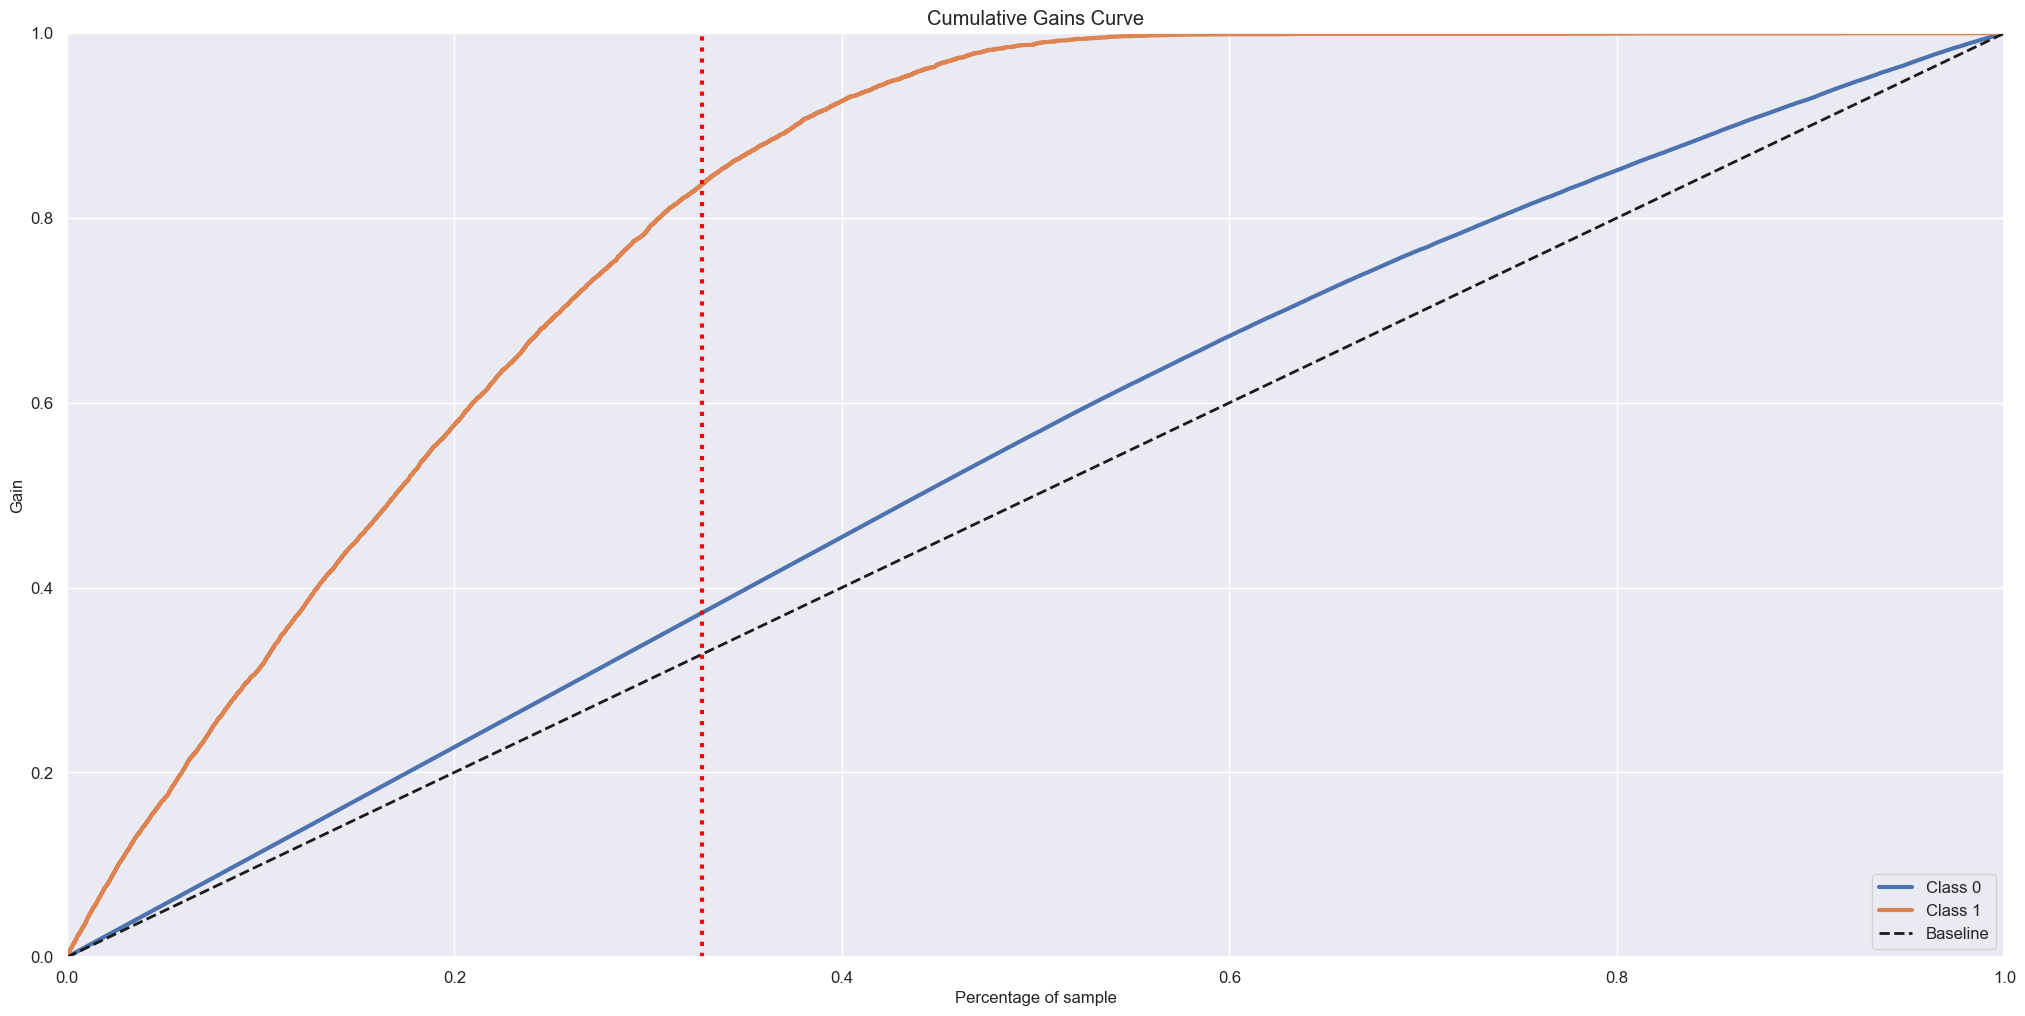

In [139]:
skplt.metrics.plot_cumulative_gain(y_validation, yhat_f)
plt.axvline(20000/len(df7), 0, 1, color='red', ls=':', lw=3)
plt.show();

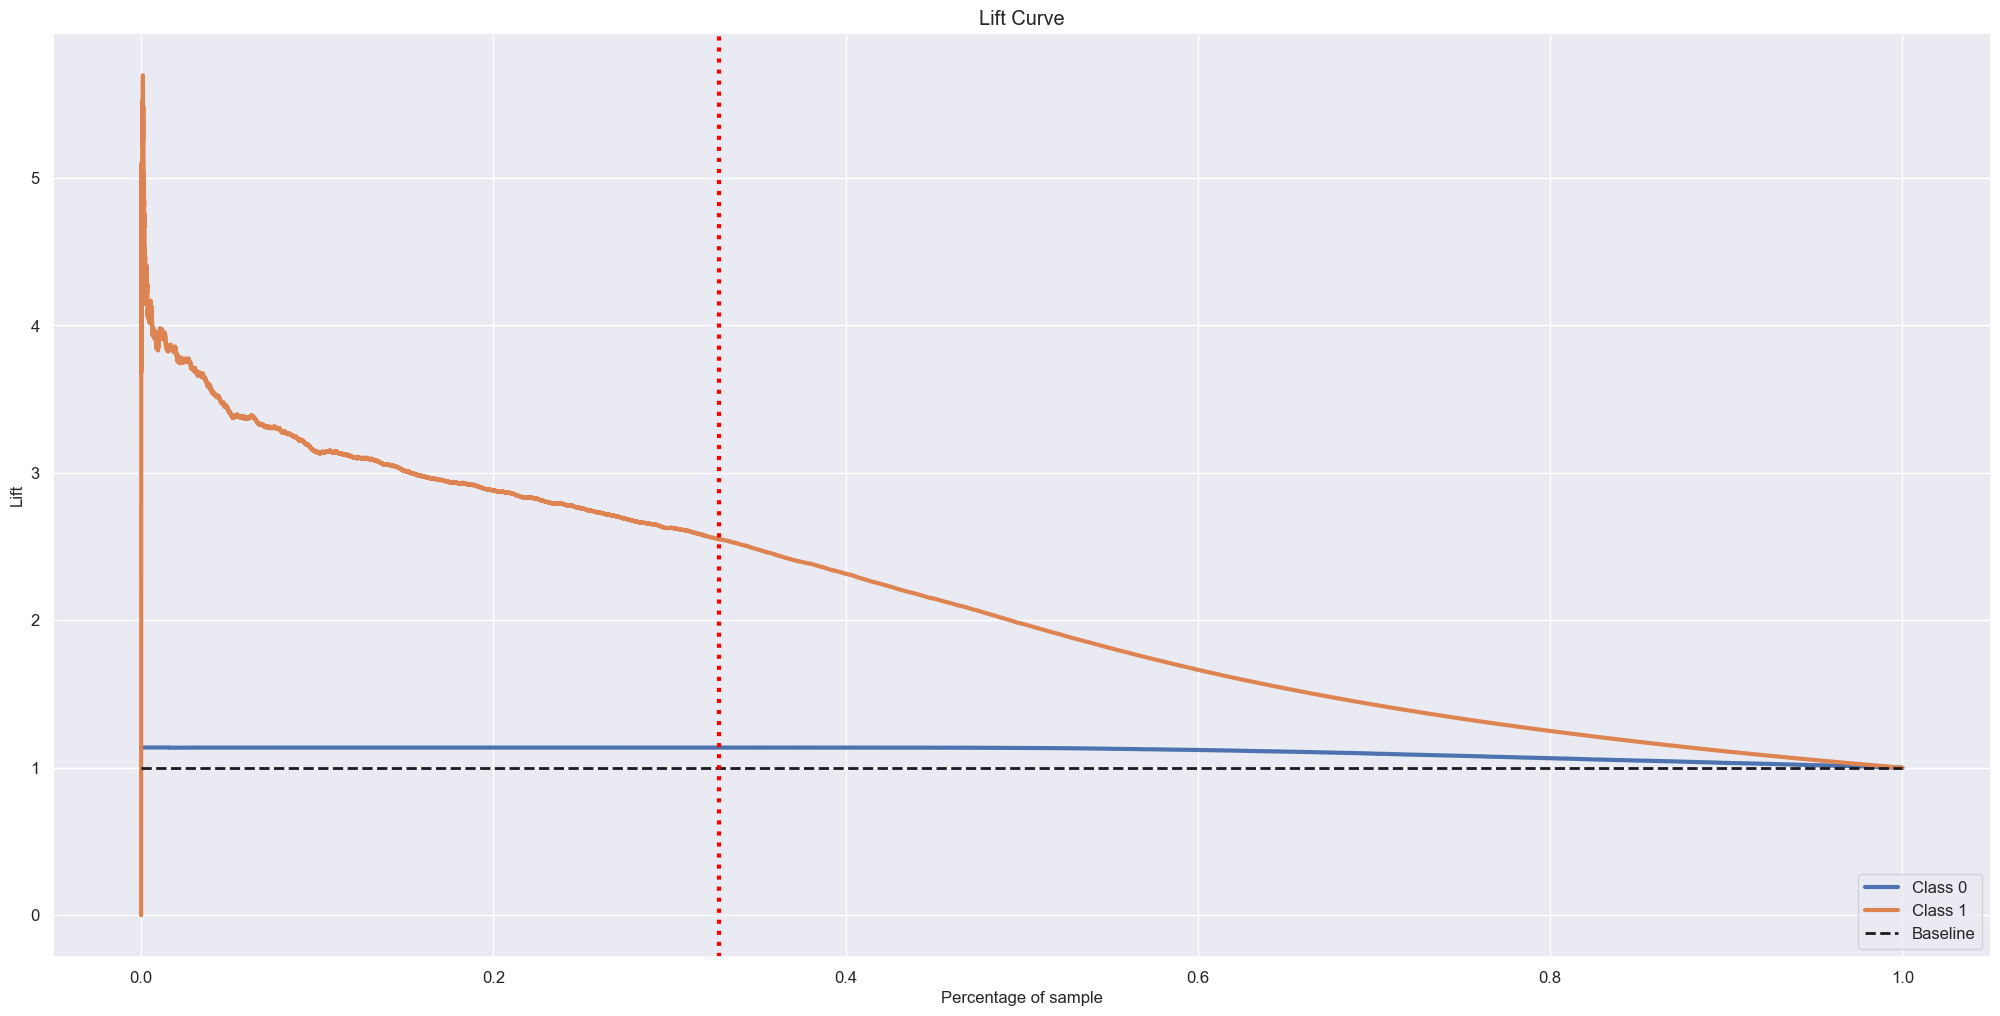

In [140]:
skplt.metrics.plot_lift_curve(y_validation, yhat_f)
plt.axvline(20000/len(df7), 0, 1, color='red', ls=':', lw=3)
plt.show()

### What percentage of interested customers could the sales center contact by calling 40,000?

Calling 40.000, you could contact 99.92% of interested customers. The Lift Curve shows that the model to 40.000 calls, is approximately 1.5 times better than using a random choice.

In [132]:
model_bq_c1 = resultssp(df7, yhat_f, yhat1_f, 'LGBM (40000 calls)', 40000)
model_bq_c1

,Precision @k,Recall @k,Accuracy
LGBM (40000 calls),0.183795,0.999185,0.879662


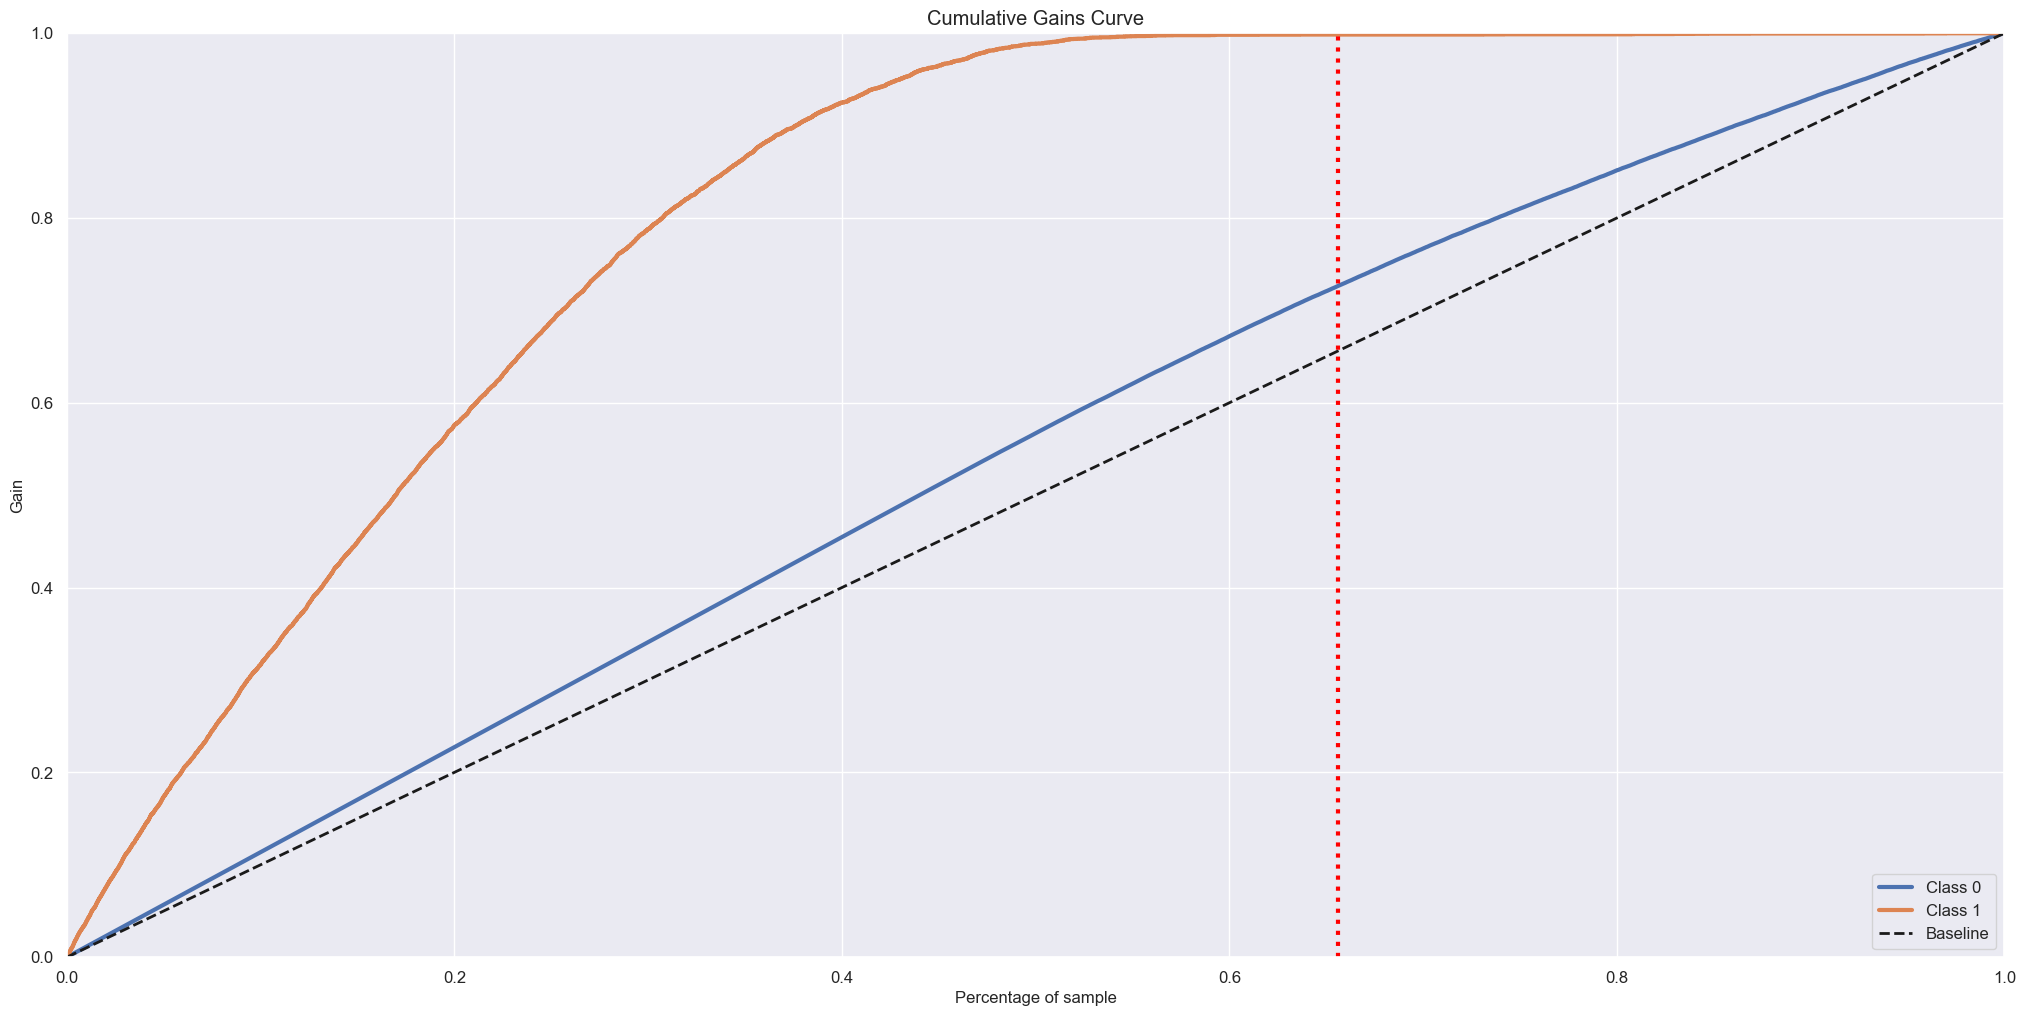

In [141]:
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm)
plt.axvline(40000/len(df7), 0, 1, color='red', ls=':', lw=3)

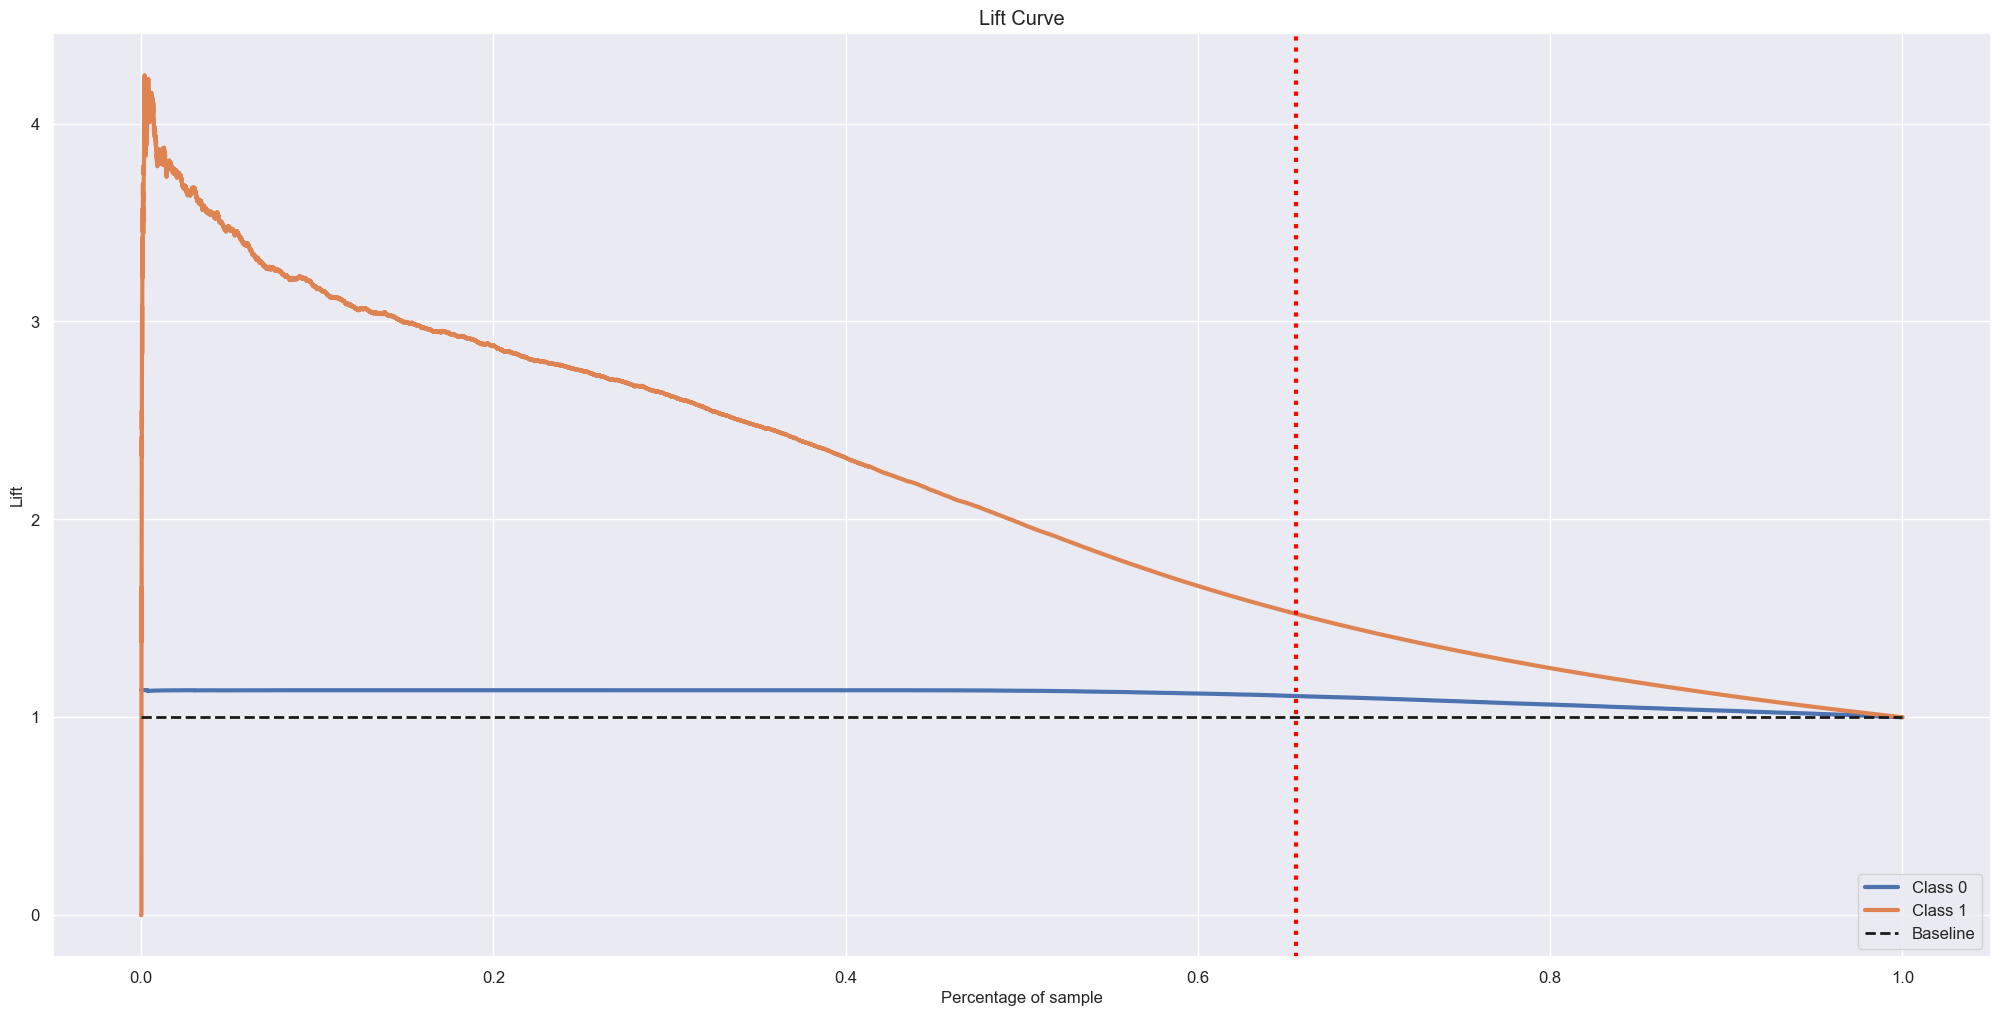

In [142]:
skplt.metrics.plot_lift_curve(y_validation, yhat_lgbm)
plt.axvline(40000/len(df7), 0, 1, color='red', ls=':', lw=3)
plt.show()

### To contact 80% of interested customers, how many calls does the center sales needs to make?

You need to make 18.700 calls, if you want to contact 80% of interested costumers.

In [117]:
model_bq_3 = resultssp(df7, yhat_f, yhat1_f, 'lgbm', 18700)
model_bq_3

,Precision @k,Recall @k,Accuracy
lgbm,0.315491,0.801848,0.879662


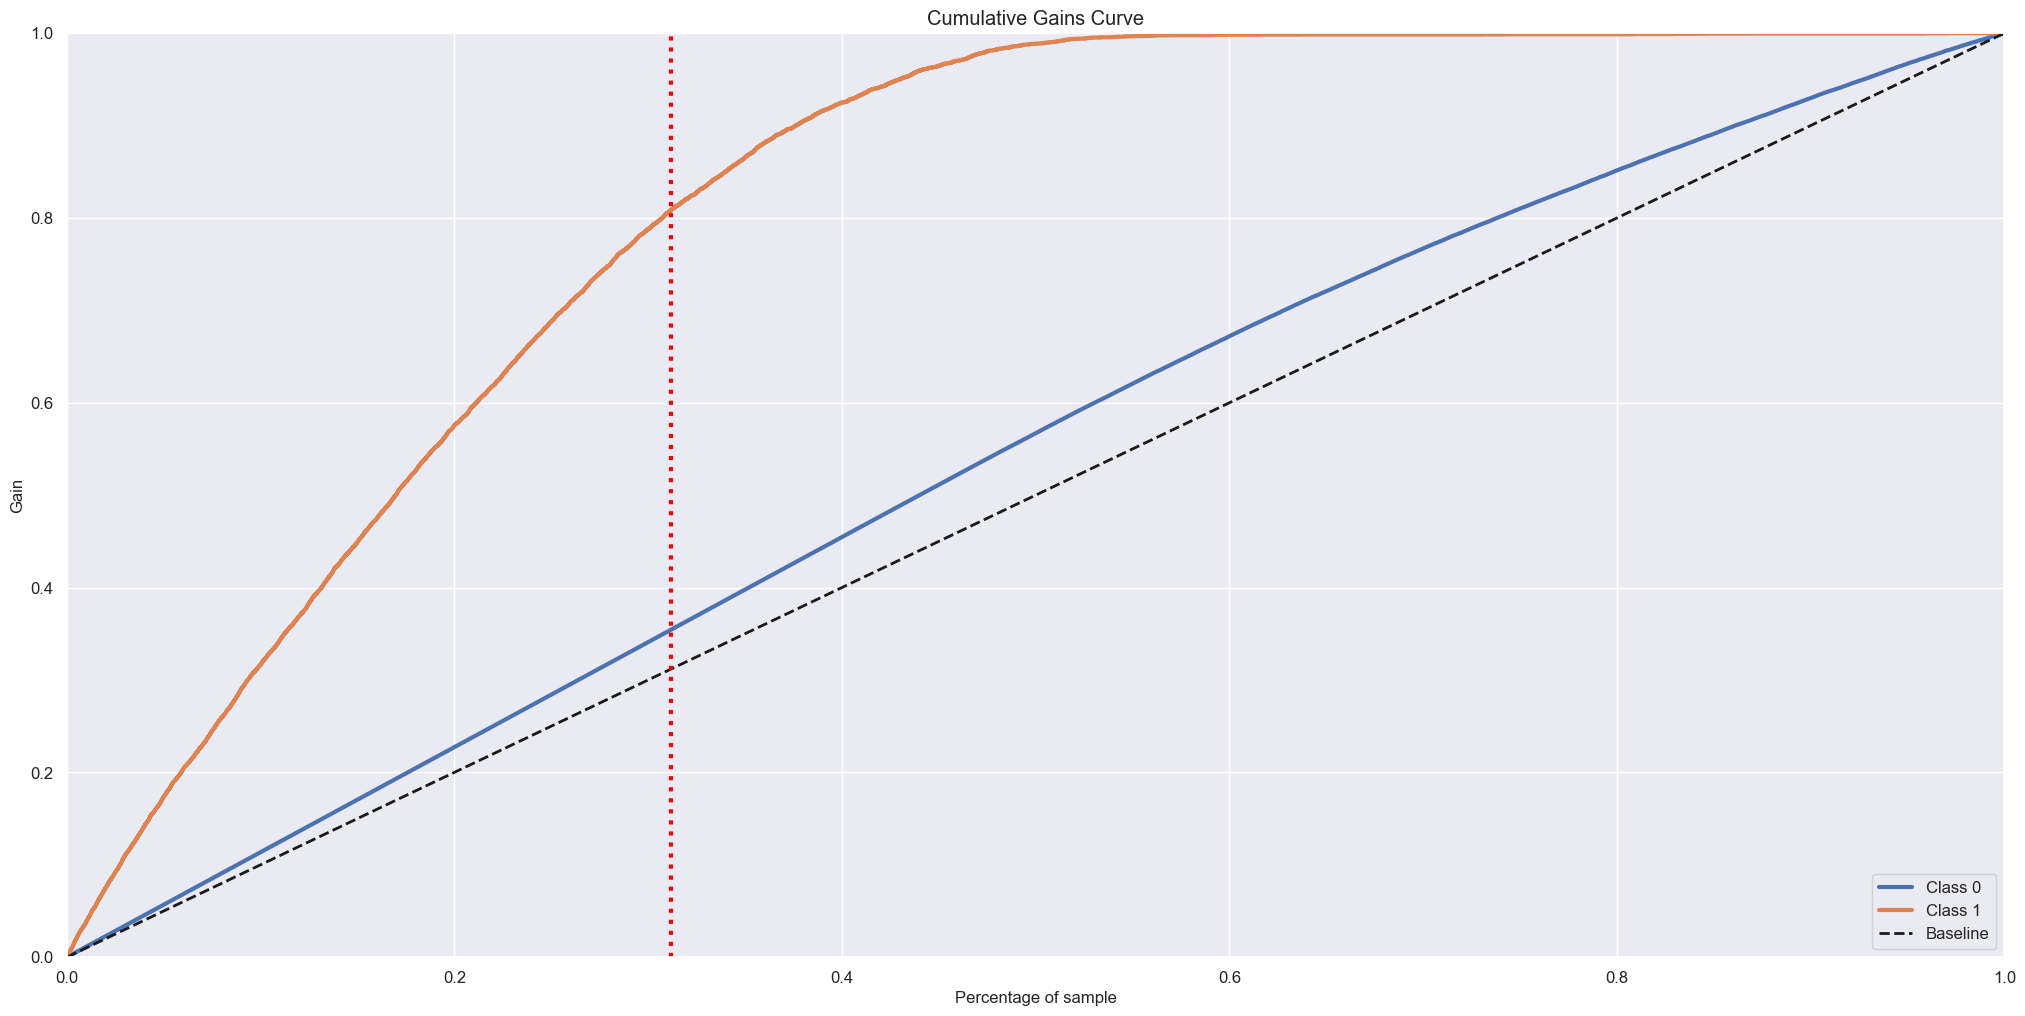

In [143]:
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm)
plt.axvline(19000/len(df7), 0, 1, color='red', ls=':', lw=3)

# 9.0 Production Model 

In [119]:
pickle.dump(model_f, open('C:/Users/PICHAU/repos/pa_hi/pa_hi/src/models/model_lgbm_final.pkl', 'wb'))

# 10.0 Health Insurance Class Create

In [120]:
import pickle
import pandas as pd
import numpy as np

class HIClass():
    def __init__(self):
        self.home_path = 'C:/Users/PICHAU/repos/pa_hi/pa_hi/'
        self.annual_premium_scaler = pickle.load(open(self.home_path + 'src/features/annual_premium_scaler.pkl'))
        self.age_scaler            = pickle.load(open(self.home_path + 'src/features/age_scaler.pkl'))
        self.vintage_scaler        = pickle.load(open(self.home_path + 'src/features/vintage_scaler.pkl'))
        self.target_encode_region_code_scaler = pickle.load(open(self.home_path + 'src/features/target_encode_region_code_scaler.pkl'))
        self.target_encode_gender_scaler      = pickle.load(open(self.home_path + 'src/features/target_encode_gender_scaler.pkl'))
        self.fe_policy_sales_channel_scaler   = pickle.load(open(self.home_path + 'src/features/fe_policy_sales_channel_scaler.pkl'))
    
    def feature_engineering(self, df1):
        
        df1['Vehicle_Age'] = df1['Vehicle_Age'].apply(lambda x: 'over_2_years' if x== '> 2 Years' 
                                                      else 'between_1_2_years' if x== '1-2 Year'  
                                                      else 'below_1_year')
        
        df1['Vehicle_Damage'] = df1['Vehicle_Damage'].apply(lambda x: 1 if x== 'Yes' else 0)
        
        return df1
    
    def data_preparatiob(self, df2):
        # Standardization
        #Annual Premium
        df2['Annual_Premium'] =  self.annual_premium_scaler.transform(df2[['Annual_Premium']].values)
        
        # Rescaling
        #Age
        df2['Age'] = self.age_scaler.transform(df2[['Age']].values)
        
        #Vintage
        df2['Vintage'] = self.vintage_scaler.transform(df2[['Vintage']].values)
        
        # Encoding
        #Gender
        df2.loc[:,'Gender'] = df2['Gender'].map(self.target_encode_gender)
        
        #Region_Code
        df2.loc[:,'Region_Code'] = df2['Region_Code'].map(self.target_encode_region_code)
        
        #Policy_Sales_Channel
        df2.loc[:,'Policy_Sales_Channel'] = df2['Policy_Sales_Channel'].map(self.fe_policy_sales_channel)
        
        #Vehicle_Age
        df2 = pd.get_dummies(df2, prefix='Vehicle_Age', columns=['Vehicle_Age'])
        
        cols_selected = ['Vintage', 'Annual_Premium', 'Age', 'Region_Code', 
                         'Vehicle_Damage', 'Policy_Sales_Channel', 'Previously_Insured']
        
        return df2[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = pred[:, 1].tolist()
        
        return original_data.to_json(orient='records', date_format='iso')

# 10.1 API Handler

In [121]:
import pickle
import requests
import pandas as pd
from flask import Flask, request, Response
from health_insurance.HIClass import HIClass

# loading model
model = pickle.load(open('C:/Users/PICHAU/repos/pa_hi/pa_hi/src/models/model_lgbm_final.pkl', 'rb'))

# initialize API
app = Flask( __name__ )
@app.route('/healthinsurance/predict', methods=['POST'])

def pahi_predict():
    test_json = request.get_json()
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys())
            
        # Instantiate HIClass class
        pipeline = HIClass()

        # feature engineering
        df1 = pipeline.feature_engineering(test_raw)

        # data preparation
        df2 = pipeline.data_preparation(df1)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df2)
        return df_response
    
    else:
        return Reponse('{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    app.run('192.168.0.118', debug=True)

ModuleNotFoundError: No module named 'health_insurance'

# 10.2 API Tester 

In [122]:
 import requests

In [123]:
 # loading test dataset
df_test = x_test
df_test['response'] = y_test

In [124]:
df_test = df_test.sample(10)

In [125]:
 # convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [126]:
data

'[{"id": 45156, "Gender": "Male", "Age": 38, "Driving_License": 1, "Region_Code": 28.0, "Previously_Insured": 0, "Vehicle_Age": "between_1_2_years", "Vehicle_Damage": 1, "Annual_Premium": 39328.0, "Policy_Sales_Channel": 26.0, "Vintage": 231, "response": 0}, {"id": 64412, "Gender": "Male", "Age": 69, "Driving_License": 1, "Region_Code": 8.0, "Previously_Insured": 0, "Vehicle_Age": "between_1_2_years", "Vehicle_Damage": 1, "Annual_Premium": 2630.0, "Policy_Sales_Channel": 7.0, "Vintage": 84, "response": 0}, {"id": 163385, "Gender": "Male", "Age": 21, "Driving_License": 1, "Region_Code": 29.0, "Previously_Insured": 0, "Vehicle_Age": "below_1_year", "Vehicle_Damage": 1, "Annual_Premium": 38767.0, "Policy_Sales_Channel": 152.0, "Vintage": 289, "response": 1}, {"id": 149113, "Gender": "Female", "Age": 26, "Driving_License": 1, "Region_Code": 47.0, "Previously_Insured": 0, "Vehicle_Age": "between_1_2_years", "Vehicle_Damage": 0, "Annual_Premium": 38456.0, "Policy_Sales_Channel": 16.0, "Vinta

In [127]:
# API Call
url = 'http://192.168.0.118:5000/healthinsurance/predict'
#url = 'https://health-insurance-model.herokuapp.com/predict'
header = {'Content-type': 'application/json'}

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [128]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.sort_values('prediction', ascending=False).head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,response,prediction
4,62014,0.104080,0.169231,1,0.187414,0,below_1_year,0,0.592009,0.194318,0.681661,1,0.054779
9,362022,0.104080,0.107692,1,0.187414,0,below_1_year,0,1.620082,0.026174,0.034602,0,0.031324
0,45156,0.138803,0.276923,1,0.187414,0,below_1_year,0,0.510736,0.208660,0.764706,0,0.029633
8,106448,0.138803,0.523077,1,0.090398,0,below_1_year,0,0.575009,0.194318,0.093426,0,0.022108
6,342695,0.138803,0.661538,1,0.187414,0,below_1_year,0,0.098960,0.194318,0.391003,0,0.022077
